<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Extension/blob/main/Adult_Transductive_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##STAT 561 Project Extension - Adult

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C5XW20):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)



{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [4]:
X

age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2                Divorced  Handlers-cleaners   Not-in-family   
3      Married-civ-spouse  Handlers-cleaners         Husband   
4      Married-civ-spouse     Prof-specialty            Wife   
...                   ...                ...             ...   
48837            Divorced     Prof-specialty   Not-in-family   
48838             Widowed                NaN  Other-relative   
48839  Married-civ-spouse     Prof-specialty         Husband   
48840            Divorced       Adm-clerical       Own-child   
48841  Married-civ-spouse    Exec-managerial         Husband   

                     race     sex  capital-gain  capital-loss  hours-per-week  \
0                   White    Male          2174             0              40   
1                   White    Male             0             0              13   
2                   White    Male             0             0              40   
3                   Black    Male             0             0              40   
4                   Black  Female             0             0              40   
...                   ...     ...           ...           ...             ...   
48837               White  Female             0             0              36   
48838               Black    Male             0             0              40   
48839               White    Male             0             0              50   
48840  Asian-Pac-Islander    Male          5455             0              40   
48841               White    Male             0             0              60   

      native-country  
0      United-States  
1      United-States  
2      United-States  
3      United-States  
4               Cuba  
...              ...  
48837  United-States  
48838  United-States  
48839  United-States  
48840  United-States  
48841  United-States  

[48842 rows x 14 columns]

In [5]:
y['income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [6]:
for i in range(len(X.columns)):
  print(X.columns[i])
  print(X.iloc[:, i].unique())
  print('------------------')

age
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]
------------------
workclass
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
------------------
fnlwgt
[ 77516  83311 215646 ... 173449  89686 350977]
------------------
education
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
------------------
education-num
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
------------------
marital-status
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
------------------
occupation
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-s

In [7]:
X_numeric = pd.DataFrame()

## Age:
X_numeric['age'] = X['age']

## Working class:
X_numeric['workclass'] = X['workclass']
X_numeric['workclass'].replace(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', '?',
                                'Self-emp-inc', 'Without-pay', 'Never-worked'],
                                [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

## Fnlwgt:

X_numeric['fnlwgt'] = X['fnlwgt']

## Education:
X_numeric['education_num'] = X['education-num']

## Marital Status:
X_numeric['marital_status'] = X['marital-status']
X_numeric['marital_status'].replace(['Never-married', 'Married-civ-spouse', 'Divorced', 'Married-spouse-absent',
                                     'Separated', 'Married-AF-spouse', 'Widowed'],
                                    [0, 1, 2, 3, 4, 5, 6], inplace=True)

## Occupation:
X_numeric['occupation'] = X['occupation']
X_numeric['occupation'].replace(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty',
                                 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving',
                                 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', '?',
                                 'Protective-serv', 'Armed-Forces', 'Priv-house-serv'],
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], inplace=True)

## Relationship:
X_numeric['relationship'] = X['relationship']
X_numeric['relationship'].replace(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'],
                                    [0, 1, 2, 3, 4, 5], inplace=True)

## Race:
X_numeric['race'] = X['race']
X_numeric['race'].replace(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
                          [0, 1, 2, 3, 4], inplace=True)

## Sex:
X_numeric['sex'] = X['sex']
X_numeric['sex'].replace(['Male', 'Female'],
                          [0, 1], inplace=True)

## Capital Gain/Loss:
X_numeric['capital_gain'] = X['capital-gain']
X_numeric['capital_loss'] = X['capital-loss']


## Hours worked:
X_numeric['hours_per_week'] = X['hours-per-week']


## Nationality:
X_numeric['native_country'] = X['native-country']
X_numeric['native_country'].replace(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico', 'South',
                                     'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
                                     'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia', 'Thailand', 'Ecuador',
                                     'Laos', 'Taiwan', 'Haiti', 'Portugal', 'Dominican-Republic', 'El-Salvador',
                                     'France', 'Guatemala', 'China', 'Japan', 'Yugoslavia', 'Peru',
                                     'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago', 'Greece',
                                     'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary', 'Holand-Netherlands'],
                                     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                      24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], inplace=True)



## Income:
y_numeric = pd.DataFrame()
y_numeric['Y'] = y['income']
y_numeric['Y'].replace(['<=50K', '<=50K.', '>50K', '>50K.'],
                          [0, 0, 1, 1], inplace=True)

X_numeric





<ipython-input-7-a0113e57739f>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_numeric['workclass'].replace(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', '?',
<ipython-input-7-a0113e57739f>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_numeric['workclass'].replace(

age  workclass  fnlwgt  education_num  marital_status  occupation  \
0       39        0.0   77516             13               0         0.0   
1       50        1.0   83311             13               1         1.0   
2       38        2.0  215646              9               2         2.0   
3       53        2.0  234721              7               1         2.0   
4       28        2.0  338409             13               1         3.0   
...    ...        ...     ...            ...             ...         ...   
48837   39        2.0  215419             13               2         3.0   
48838   64        NaN  321403              9               6         NaN   
48839   38        2.0  374983             13               1         3.0   
48840   44        2.0   83891             13               2         0.0   
48841   35        6.0  182148             13               1         1.0   

       relationship  race  sex  capital_gain  capital_loss  hours_per_week  \
0                 0     0    0          2174             0              40   
1                 1     0    0             0             0              13   
2                 0     0    0             0             0              40   
3                 1     1    0             0             0              40   
4                 2     1    1             0             0              40   
...             ...   ...  ...           ...           ...             ...   
48837             0     0    1             0             0              36   
48838             5     1    0             0             0              40   
48839             1     0    0             0             0              50   
48840             3     2    0          5455             0              40   
48841             1     0    0             0             0              60   

       native_country  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 1.0  
...               ...  
48837             0.0  
48838             0.0  
48839             0.0  
48840             0.0  
48841             0.0  

[48842 rows x 13 columns]

In [8]:
y_numeric

Y
0      0
1      0
2      0
3      0
4      0
...   ..
48837  0
48838  0
48839  0
48840  0
48841  1

[48842 rows x 1 columns]

In [9]:
y_numeric['Y'].value_counts()

Y
0    37155
1    11687
Name: count, dtype: int64

In [10]:
data_total = pd.concat([X_numeric, y_numeric], axis=1)

data_total = data_total.dropna().reset_index(drop=True)


data_total

age  workclass  fnlwgt  education_num  marital_status  occupation  \
0       39        0.0   77516             13               0         0.0   
1       50        1.0   83311             13               1         1.0   
2       38        2.0  215646              9               2         2.0   
3       53        2.0  234721              7               1         2.0   
4       28        2.0  338409             13               1         3.0   
...    ...        ...     ...            ...             ...         ...   
47616   33        2.0  245211             13               0         3.0   
47617   39        2.0  215419             13               2         3.0   
47618   38        2.0  374983             13               1         3.0   
47619   44        2.0   83891             13               2         0.0   
47620   35        6.0  182148             13               1         1.0   

       relationship  race  sex  capital_gain  capital_loss  hours_per_week  \
0                 0     0    0          2174             0              40   
1                 1     0    0             0             0              13   
2                 0     0    0             0             0              40   
3                 1     1    0             0             0              40   
4                 2     1    1             0             0              40   
...             ...   ...  ...           ...           ...             ...   
47616             3     0    0             0             0              40   
47617             0     0    1             0             0              36   
47618             1     0    0             0             0              50   
47619             3     2    0          5455             0              40   
47620             1     0    0             0             0              60   

       native_country  Y  
0                 0.0  0  
1                 0.0  0  
2                 0.0  0  
3                 0.0  0  
4                 1.0  0  
...               ... ..  
47616             0.0  0  
47617             0.0  0  
47618             0.0  0  
47619             0.0  0  
47620             0.0  1  

[47621 rows x 14 columns]

In [11]:
X = data_total.iloc[:, :-1]
y = data_total.iloc[:,-1]
y

0        0
1        0
2        0
3        0
4        0
        ..
47616    0
47617    0
47618    0
47619    0
47620    1
Name: Y, Length: 47621, dtype: int64

In [12]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [13]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

0      1         2         3         4         5    6     7  \
0      0.301370  0.000  0.044131  0.800000  0.000000  0.000000  0.0  0.00   
1      0.452055  0.125  0.048052  0.800000  0.166667  0.071429  0.2  0.00   
2      0.287671  0.250  0.137581  0.533333  0.333333  0.142857  0.0  0.00   
3      0.493151  0.250  0.150486  0.400000  0.166667  0.142857  0.2  0.25   
4      0.150685  0.250  0.220635  0.800000  0.166667  0.214286  0.4  0.25   
...         ...    ...       ...       ...       ...       ...  ...   ...   
47616  0.219178  0.250  0.157583  0.800000  0.000000  0.214286  0.6  0.00   
47617  0.301370  0.250  0.137428  0.800000  0.333333  0.214286  0.0  0.00   
47618  0.287671  0.250  0.245379  0.800000  0.166667  0.214286  0.2  0.00   
47619  0.369863  0.250  0.048444  0.800000  0.333333  0.000000  0.6  0.50   
47620  0.246575  0.750  0.114919  0.800000  0.166667  0.071429  0.2  0.00   

         8         9   10        11       12  Y  
0      0.0  0.021740  0.0  0.397959  0.00000  0  
1      0.0  0.000000  0.0  0.122449  0.00000  0  
2      0.0  0.000000  0.0  0.397959  0.00000  0  
3      0.0  0.000000  0.0  0.397959  0.00000  0  
4      1.0  0.000000  0.0  0.397959  0.02439  0  
...    ...       ...  ...       ...      ... ..  
47616  0.0  0.000000  0.0  0.397959  0.00000  0  
47617  1.0  0.000000  0.0  0.357143  0.00000  0  
47618  0.0  0.000000  0.0  0.500000  0.00000  0  
47619  0.0  0.054551  0.0  0.397959  0.00000  0  
47620  0.0  0.000000  0.0  0.602041  0.00000  1  

[47621 rows x 14 columns]

In [14]:
y.value_counts()

Y
0    36080
1    11541
Name: count, dtype: int64

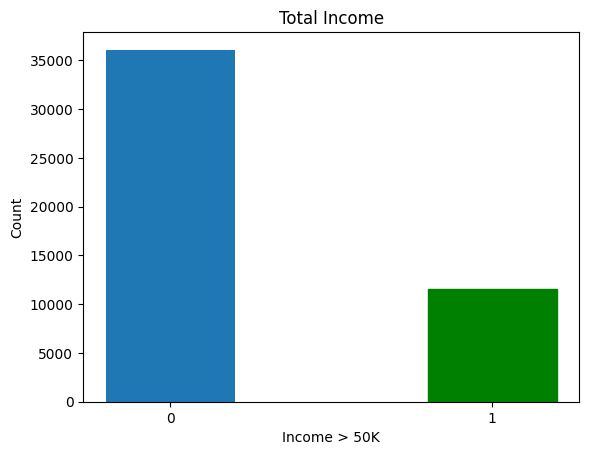

In [15]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Income > 50K")
plt.ylabel("Count")
plt.title("Total Income")
plt.show()

In [16]:
data_total

age  workclass  fnlwgt  education_num  marital_status  occupation  \
0       39        0.0   77516             13               0         0.0   
1       50        1.0   83311             13               1         1.0   
2       38        2.0  215646              9               2         2.0   
3       53        2.0  234721              7               1         2.0   
4       28        2.0  338409             13               1         3.0   
...    ...        ...     ...            ...             ...         ...   
47616   33        2.0  245211             13               0         3.0   
47617   39        2.0  215419             13               2         3.0   
47618   38        2.0  374983             13               1         3.0   
47619   44        2.0   83891             13               2         0.0   
47620   35        6.0  182148             13               1         1.0   

       relationship  race  sex  capital_gain  capital_loss  hours_per_week  \
0                 0     0    0          2174             0              40   
1                 1     0    0             0             0              13   
2                 0     0    0             0             0              40   
3                 1     1    0             0             0              40   
4                 2     1    1             0             0              40   
...             ...   ...  ...           ...           ...             ...   
47616             3     0    0             0             0              40   
47617             0     0    1             0             0              36   
47618             1     0    0             0             0              50   
47619             3     2    0          5455             0              40   
47620             1     0    0             0             0              60   

       native_country  Y  
0                 0.0  0  
1                 0.0  0  
2                 0.0  0  
3                 0.0  0  
4                 1.0  0  
...               ... ..  
47616             0.0  0  
47617             0.0  0  
47618             0.0  0  
47619             0.0  0  
47620             0.0  1  

[47621 rows x 14 columns]

In [17]:
data_total.iloc[:, 8].value_counts()

sex
0    31937
1    15684
Name: count, dtype: int64

In [18]:
data2.iloc[:, 8].value_counts()

8
0.0    31937
1.0    15684
Name: count, dtype: int64

# Splitting for Source and Target Domains:


# Full Dataset:

Grouping by gender: Men are 0, Women are 1

In [19]:
data_S = data2[data2.iloc[:,8] <= 0.5].reset_index(drop=True)  ## Source domain and classification - Male
data_T = data2[data2.iloc[:,8] > 0.5].reset_index(drop=True)  ## Target domain and classification - Female

In [20]:
data_S

0      1         2         3         4         5    6     7  \
0      0.301370  0.000  0.044131  0.800000  0.000000  0.000000  0.0  0.00   
1      0.452055  0.125  0.048052  0.800000  0.166667  0.071429  0.2  0.00   
2      0.287671  0.250  0.137581  0.533333  0.333333  0.142857  0.0  0.00   
3      0.493151  0.250  0.150486  0.400000  0.166667  0.142857  0.2  0.25   
4      0.479452  0.125  0.133519  0.533333  0.166667  0.071429  0.2  0.00   
...         ...    ...       ...       ...       ...       ...  ...   ...   
31932  0.424658  0.500  0.227956  0.866667  0.333333  0.285714  0.0  0.00   
31933  0.219178  0.250  0.157583  0.800000  0.000000  0.214286  0.6  0.00   
31934  0.287671  0.250  0.245379  0.800000  0.166667  0.214286  0.2  0.00   
31935  0.369863  0.250  0.048444  0.800000  0.333333  0.000000  0.6  0.50   
31936  0.246575  0.750  0.114919  0.800000  0.166667  0.071429  0.2  0.00   

         8         9   10        11   12  Y  
0      0.0  0.021740  0.0  0.397959  0.0  0  
1      0.0  0.000000  0.0  0.122449  0.0  0  
2      0.0  0.000000  0.0  0.397959  0.0  0  
3      0.0  0.000000  0.0  0.397959  0.0  0  
4      0.0  0.000000  0.0  0.448980  0.0  1  
...    ...       ...  ...       ...  ... ..  
31932  0.0  0.000000  0.0  0.397959  0.0  0  
31933  0.0  0.000000  0.0  0.397959  0.0  0  
31934  0.0  0.000000  0.0  0.500000  0.0  0  
31935  0.0  0.054551  0.0  0.397959  0.0  0  
31936  0.0  0.000000  0.0  0.602041  0.0  1  

[31937 rows x 14 columns]

In [21]:
data_T

0     1         2         3         4         5    6     7    8  \
0      0.150685  0.25  0.220635  0.800000  0.166667  0.214286  0.4  0.25  1.0   
1      0.273973  0.25  0.184219  0.866667  0.166667  0.071429  0.4  0.00  1.0   
2      0.438356  0.25  0.100061  0.266667  0.500000  0.285714  0.0  0.25  1.0   
3      0.191781  0.25  0.022661  0.866667  0.000000  0.214286  0.0  0.00  1.0   
4      0.082192  0.25  0.074410  0.800000  0.000000  0.000000  0.6  0.00  1.0   
...         ...   ...       ...       ...       ...       ...  ...   ...  ...   
15679  0.136986  0.25  0.282830  0.600000  0.000000  0.357143  0.0  0.00  1.0   
15680  0.520548  0.25  0.143676  0.533333  0.666667  1.000000  0.0  0.00  1.0   
15681  0.287671  0.25  0.159164  0.666667  0.000000  0.000000  0.8  0.25  1.0   
15682  0.109589  0.25  0.229138  0.533333  0.000000  0.285714  0.6  0.00  1.0   
15683  0.301370  0.25  0.137428  0.800000  0.333333  0.214286  0.0  0.00  1.0   

              9   10        11       12  Y  
0      0.000000  0.0  0.397959  0.02439  0  
1      0.000000  0.0  0.397959  0.00000  0  
2      0.000000  0.0  0.153061  0.04878  0  
3      0.140841  0.0  0.500000  0.00000  1  
4      0.000000  0.0  0.295918  0.00000  0  
...         ...  ...       ...      ... ..  
15679  0.000000  0.0  0.448980  0.00000  0  
15680  0.000000  0.0  0.316327  0.00000  0  
15681  0.000000  0.0  0.397959  0.00000  0  
15682  0.000000  0.0  0.397959  0.00000  0  
15683  0.000000  0.0  0.357143  0.00000  0  

[15684 rows x 14 columns]

## Source domain and task labels:

In [22]:
X_S_full = data_S.iloc[:, :-1]
X_S_full       ## Source domain


y_S_full = data_S.iloc[:, -1]
y_S_full       ## Source classification (response)

0        0
1        0
2        0
3        0
4        1
        ..
31932    0
31933    0
31934    0
31935    0
31936    1
Name: Y, Length: 31937, dtype: int64

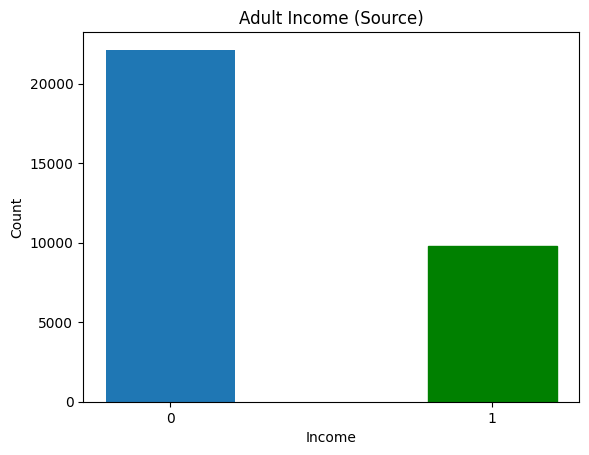

In [24]:
barlist_S = plt.bar([str(0),str(1)], y_S_full.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("Count")
plt.title("Adult Income (Source)")
plt.show()

## Target domain and task labels:

In [25]:
X_T_full = data_T.iloc[:, :-1]
X_T_full       ## Target domain


y_T_full = data_T.iloc[:, -1]
y_T_full       ## Target classification (response)

0        0
1        0
2        0
3        1
4        0
        ..
15679    0
15680    0
15681    0
15682    0
15683    0
Name: Y, Length: 15684, dtype: int64

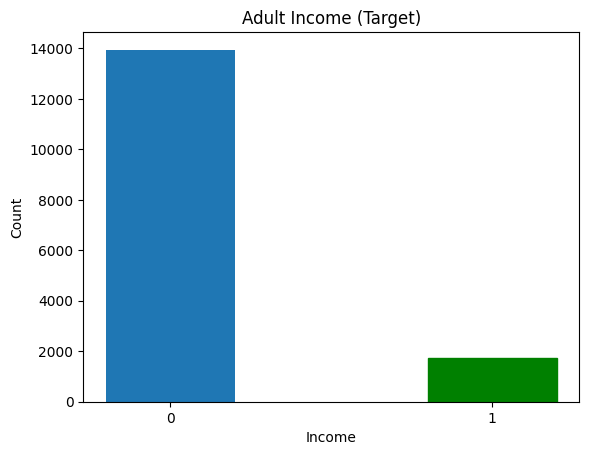

In [26]:
barlist_T = plt.bar([str(0),str(1)], y_T_full.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("Count")
plt.title("Adult Income (Target)")
plt.show()

## Updated Code (Modified from Shreya's code):

In [27]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)
    return time_elapsed


In [28]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)

    return fpr, tnr, fnr, tpr, time_elapsed

In [29]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)

In [30]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (25549, 13)
y_S_train: (25549,)
X_S_test: (6388, 13)
y_S_test: (6388,)


In [31]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.6933 - loss: 0.5515 - val_AUC: 0.8720 - val_loss: 0.4098
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8687 - loss: 0.4064 - val_AUC: 0.8771 - val_loss: 0.4160
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8744 - loss: 0.3963 - val_AUC: 0.8762 - val_loss: 0.3990
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8695 - loss: 0.4050 - val_AUC: 0.8776 - val_loss: 0.3988
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8764 - loss: 0.3940 - val_AUC: 0.8784 - val_loss: 0.3998
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8776 - loss: 0.3947 - val_AUC: 0.8783 - val_loss: 0.3959
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8710 - loss: 0.3984 - val_AUC: 0.8785 - val_loss: 0.3996
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8777 - loss: 0.3865 - val_AUC: 0.8791 - val_loss: 0.3945
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AU

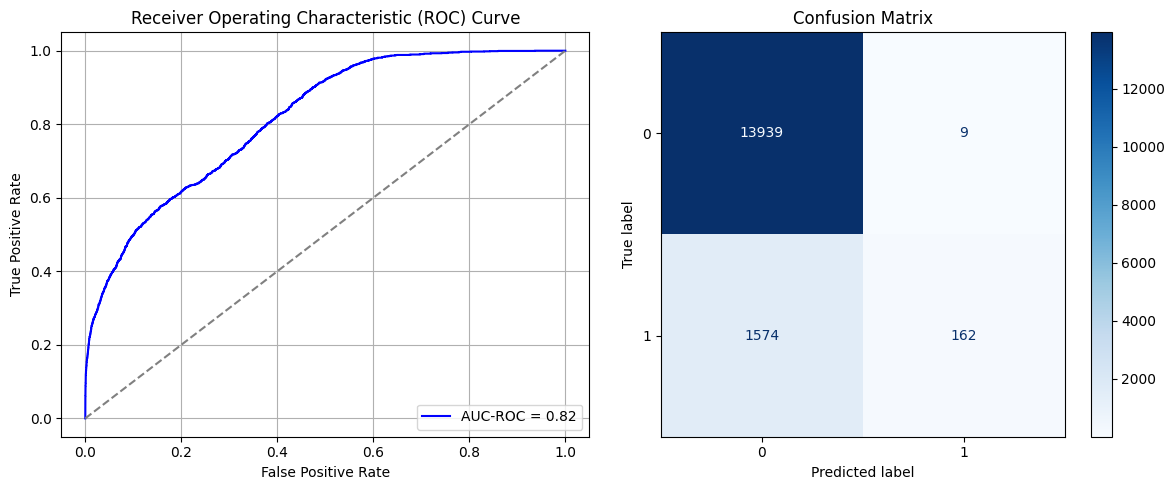

Best threshold based on F1-score: 0.03215319663286209
False Negative Rate: 0.9066820276497696
Time elapsed (performance): 1.597914516000003
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7014 - loss: 0.5506 - val_AUC: 0.8711 - val_loss: 0.4176
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8692 - loss: 0.4073 - val_AUC: 0.8767 - val_loss: 0.4095
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8711 - loss: 0.4002 - val_AUC: 0.8781 - val_loss: 0.4250
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8689 - loss: 0.4057 - val_AUC: 0.8785 - val_loss: 0.4025
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8748 - loss: 0.3974 - val_AUC: 0.8770 - val_loss: 0.4008
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8760 - loss: 0.3943 - val_AUC: 0.8796 - val_loss: 0.3944
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8760 - loss: 0.3919 - val_AUC: 0.8793 - val_loss: 0.3960
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8786 - loss: 0.3893 - val_AUC: 0.8795 - val_loss: 0.3961
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8769 -

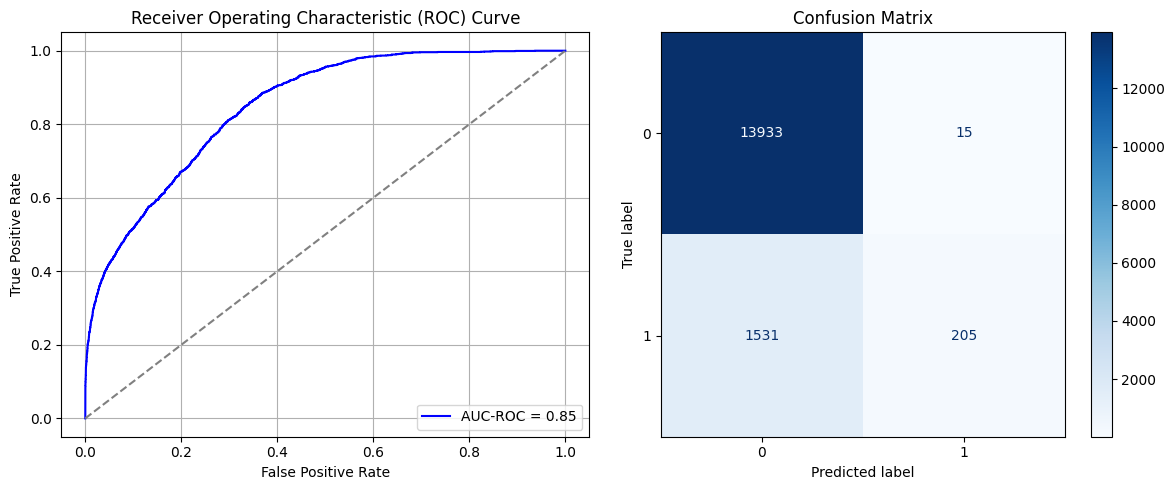

Best threshold based on F1-score: 0.10530772060155869
False Negative Rate: 0.8819124423963134
Time elapsed (performance): 1.2902542880000283
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6924 - loss: 0.5547 - val_AUC: 0.8712 - val_loss: 0.4121
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8672 - loss: 0.4080 - val_AUC: 0.8772 - val_loss: 0.3989
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8696 - loss: 0.4034 - val_AUC: 0.8783 - val_loss: 0.3974
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8797 - loss: 0.3901 - val_AUC: 0.8787 - val_loss: 0.3959
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8749 - loss: 0.3959 - val_AUC: 0.8764 - val_loss: 0.4013
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8706 - loss: 0.4003 - val_AUC: 0.8784 - val_loss: 0.4091
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8749 - loss: 0.3982 - val_AUC: 0.8791 - val_loss: 0.3968
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8743 - loss: 0.3972 - val_AUC: 0.8784 - val_loss: 0.3977
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8730 -

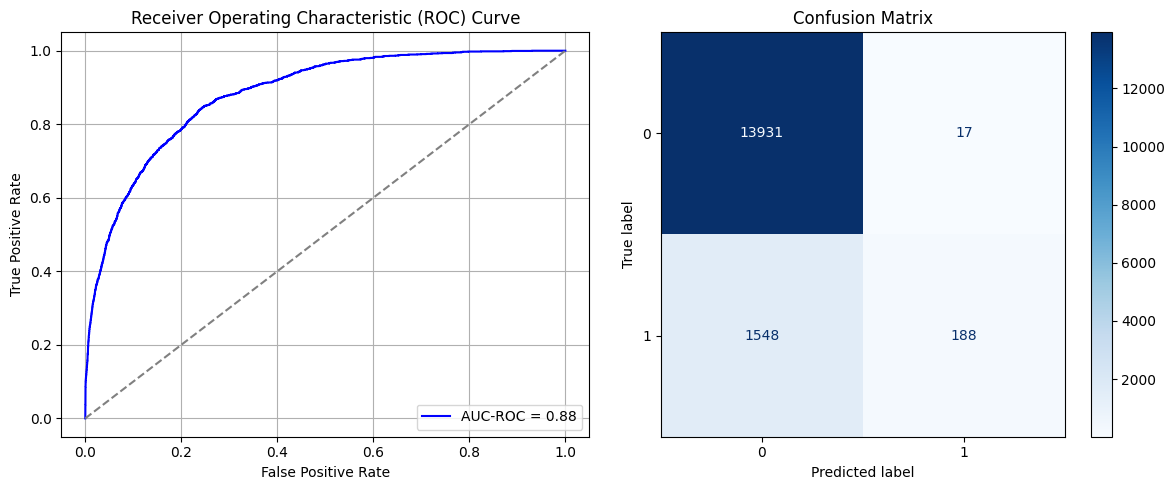

Best threshold based on F1-score: 0.06805304437875748
False Negative Rate: 0.8917050691244239
Time elapsed (performance): 2.5881037890000016
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7103 - loss: 0.5449 - val_AUC: 0.8737 - val_loss: 0.4130
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8628 - loss: 0.4150 - val_AUC: 0.8768 - val_loss: 0.4038
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8705 - loss: 0.4023 - val_AUC: 0.8784 - val_loss: 0.3975
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8774 - loss: 0.3907 - val_AUC: 0.8777 - val_loss: 0.4083
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8763 - loss: 0.3950 - val_AUC: 0.8776 - val_loss: 0.4170
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8727 - loss: 0.3976 - val_AUC: 0.8790 - val_loss: 0.4120
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8712 - loss: 0.4012 - val_AUC: 0.8794 - val_loss: 0.3944
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8736 - loss: 0.3994 - val_AUC: 0.8793 - val_loss: 0.3950
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8787 -

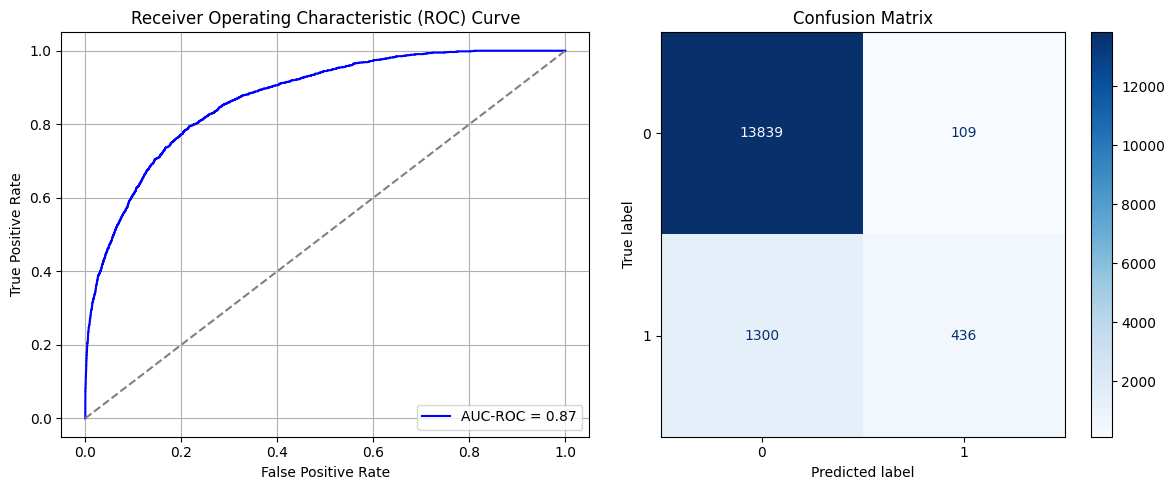

Best threshold based on F1-score: 0.21962293982505798
False Negative Rate: 0.7488479262672811
Time elapsed (performance): 1.731610638999996
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7158 - loss: 0.5465 - val_AUC: 0.8692 - val_loss: 0.4206
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8629 - loss: 0.4134 - val_AUC: 0.8771 - val_loss: 0.3981
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8732 - loss: 0.3999 - val_AUC: 0.8783 - val_loss: 0.3968
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8712 - loss: 0.4020 - val_AUC: 0.8776 - val_loss: 0.4014
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8765 - loss: 0.3946 - val_AUC: 0.8784 - val_loss: 0.3955
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8734 - loss: 0.3964 - val_AUC: 0.8789 - val_loss: 0.3965
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8789 - loss: 0.3881 - val_AUC: 0.8792 - val_loss: 0.3942
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8741 - loss: 0.3974 - val_AUC: 0.8787 - val_loss: 0.3947
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.8779 -

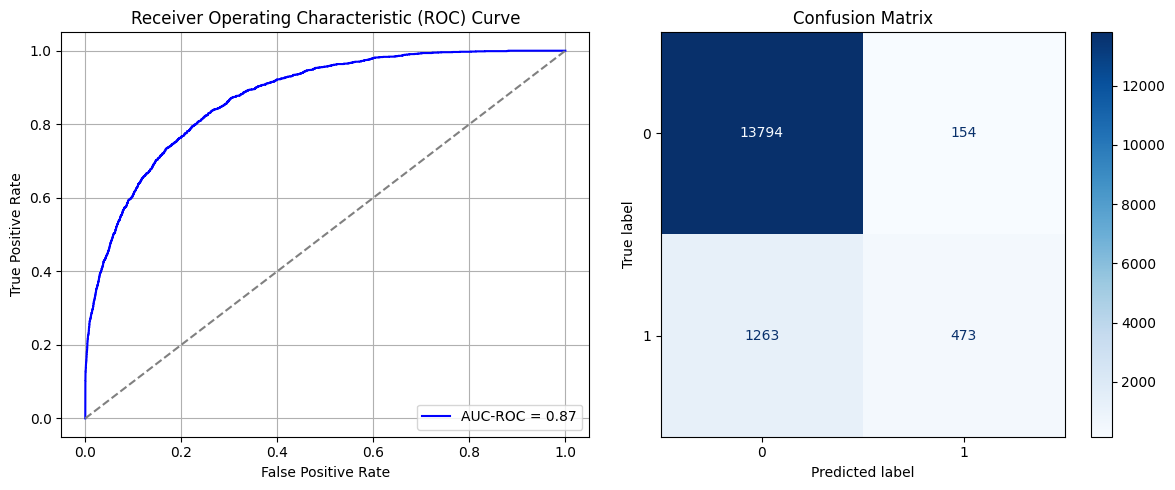

Best threshold based on F1-score: 0.20571371912956238
False Negative Rate: 0.7275345622119815
Time elapsed (performance): 1.7186234800000193
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7207 - loss: 0.5378 - val_AUC: 0.8735 - val_loss: 0.4102
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8687 - loss: 0.4084 - val_AUC: 0.8767 - val_loss: 0.4010
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8684 - loss: 0.4078 - val_AUC: 0.8773 - val_loss: 0.3977
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8732 - loss: 0.3963 - val_AUC: 0.8781 - val_loss: 0.4002
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8750 - loss: 0.3959 - val_AUC: 0.8780 - val_loss: 0.3993
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8736 - loss: 0.3975 - val_AUC: 0.8789 - val_loss: 0.3956
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8749 - loss: 0.3970 - val_AUC: 0.8792 - val_loss: 0.3956
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8714 - loss: 0.3999 - val_AUC: 0.8798 - val_loss: 0.3954
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8740 -

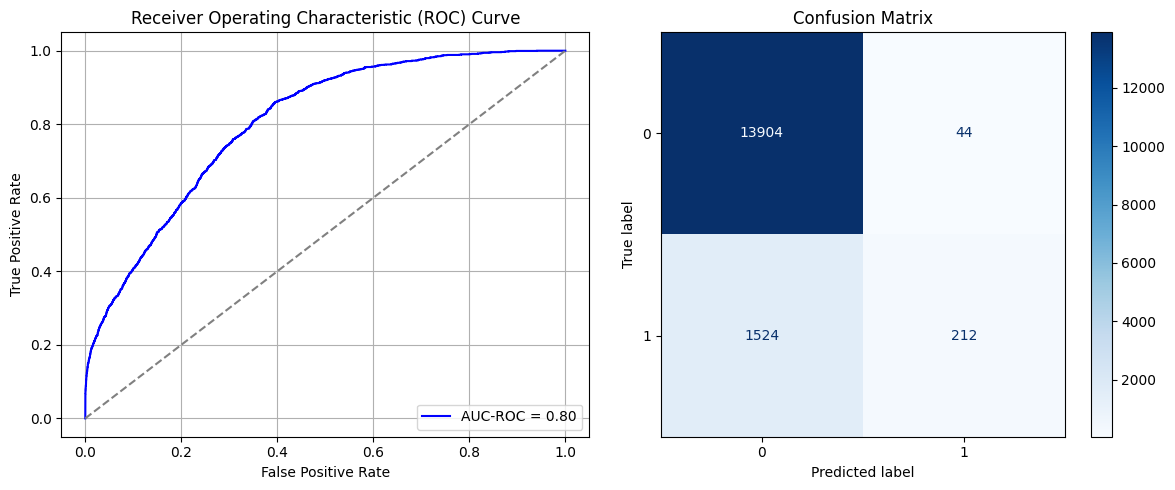

Best threshold based on F1-score: 0.07304814457893372
False Negative Rate: 0.8778801843317973
Time elapsed (performance): 1.710325135000062
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7173 - loss: 0.5401 - val_AUC: 0.8704 - val_loss: 0.4149
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8701 - loss: 0.4032 - val_AUC: 0.8778 - val_loss: 0.4088
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8662 - loss: 0.4044 - val_AUC: 0.8784 - val_loss: 0.3996
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8711 - loss: 0.3983 - val_AUC: 0.8788 - val_loss: 0.3977
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8746 - loss: 0.3977 - val_AUC: 0.8790 - val_loss: 0.4052
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8747 - loss: 0.3942 - val_AUC: 0.8798 - val_loss: 0.3952
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8770 - loss: 0.3935 - val_AUC: 0.8774 - val_loss: 0.3978
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8806 - loss: 0.3879 - val_AUC: 0.8803 - val_loss: 0.3932
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8790 -

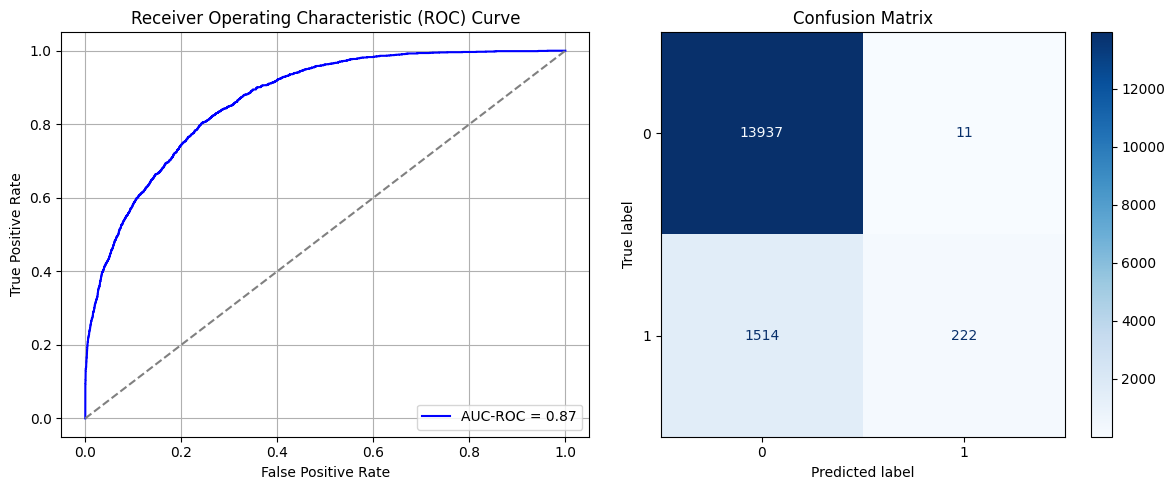

Best threshold based on F1-score: 0.06082378327846527
False Negative Rate: 0.8721198156682027
Time elapsed (performance): 1.7295845389999158
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6975 - loss: 0.5578 - val_AUC: 0.8709 - val_loss: 0.4186
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8713 - loss: 0.4040 - val_AUC: 0.8774 - val_loss: 0.3993
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8728 - loss: 0.4012 - val_AUC: 0.8780 - val_loss: 0.4100
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8716 - loss: 0.4017 - val_AUC: 0.8772 - val_loss: 0.3978
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8741 - loss: 0.3975 - val_AUC: 0.8779 - val_loss: 0.3978
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8756 - loss: 0.3952 - val_AUC: 0.8787 - val_loss: 0.3975
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8765 - loss: 0.3946 - val_AUC: 0.8790 - val_loss: 0.3961
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8739 - loss: 0.3957 - val_AUC: 0.8779 - val_loss: 0.4000
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8778 -

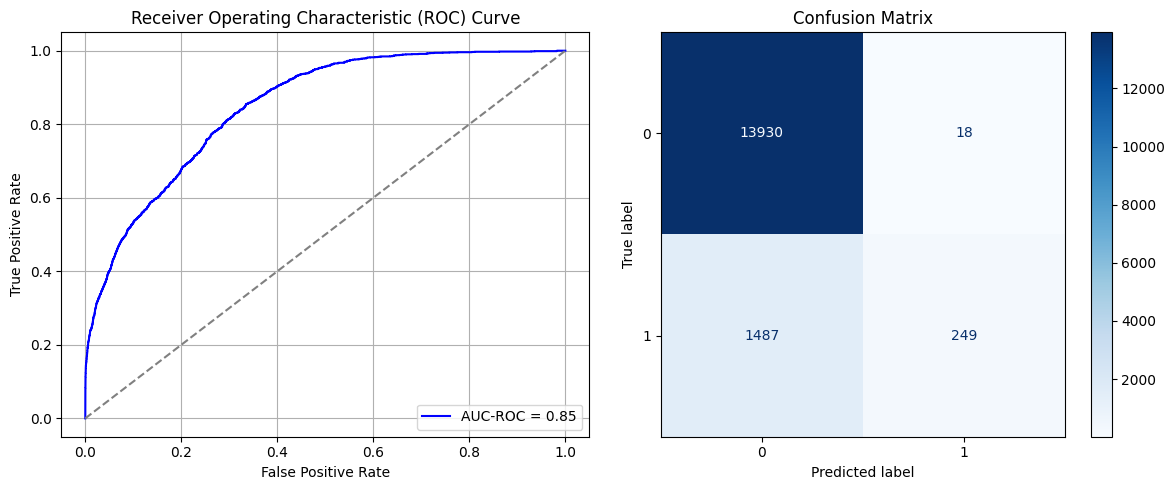

Best threshold based on F1-score: 0.08253281563520432
False Negative Rate: 0.8565668202764977
Time elapsed (performance): 1.263534748999973
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6941 - loss: 0.5509 - val_AUC: 0.8722 - val_loss: 0.4173
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8660 - loss: 0.4115 - val_AUC: 0.8755 - val_loss: 0.4004
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8703 - loss: 0.4031 - val_AUC: 0.8774 - val_loss: 0.4002
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8684 - loss: 0.4041 - val_AUC: 0.8778 - val_loss: 0.3963
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8739 - loss: 0.3975 - val_AUC: 0.8785 - val_loss: 0.3956
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8760 - loss: 0.3953 - val_AUC: 0.8774 - val_loss: 0.4041
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8746 - loss: 0.3933 - val_AUC: 0.8775 - val_loss: 0.3975
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8723 - loss: 0.4011 - val_AUC: 0.8794 - val_loss: 0.3990
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8813 -

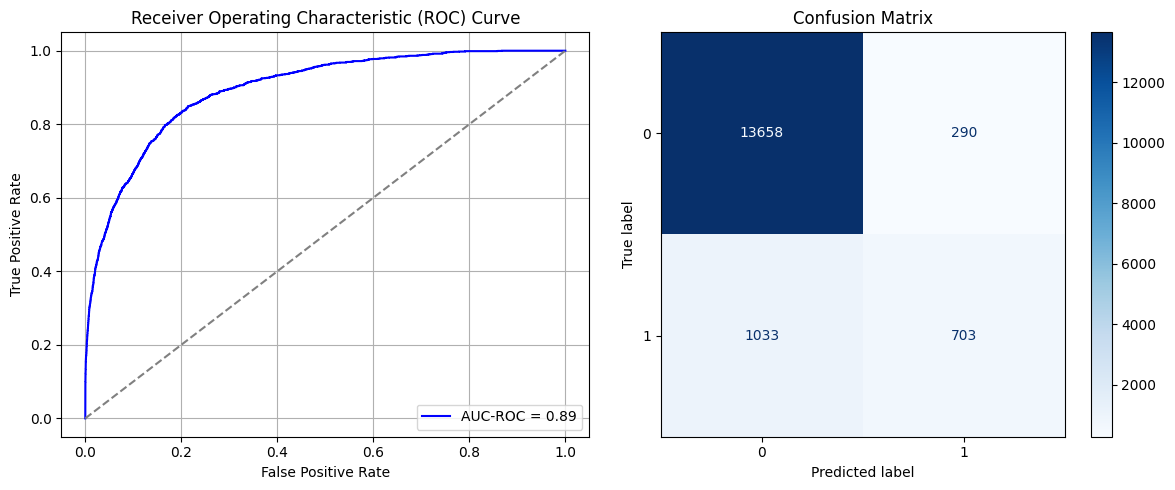

Best threshold based on F1-score: 0.36927923560142517
False Negative Rate: 0.5950460829493087
Time elapsed (performance): 1.301765817000046
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7094 - loss: 0.5379 - val_AUC: 0.8715 - val_loss: 0.4121
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8636 - loss: 0.4139 - val_AUC: 0.8767 - val_loss: 0.4003
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8724 - loss: 0.3988 - val_AUC: 0.8776 - val_loss: 0.3974
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8760 - loss: 0.3967 - val_AUC: 0.8770 - val_loss: 0.3980
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8725 - loss: 0.3996 - val_AUC: 0.8781 - val_loss: 0.3953
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8745 - loss: 0.3951 - val_AUC: 0.8764 - val_loss: 0.4171
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8759 - loss: 0.3946 - val_AUC: 0.8791 - val_loss: 0.3940
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8713 - loss: 0.4019 - val_AUC: 0.8792 - val_loss: 0.4029
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8782 -

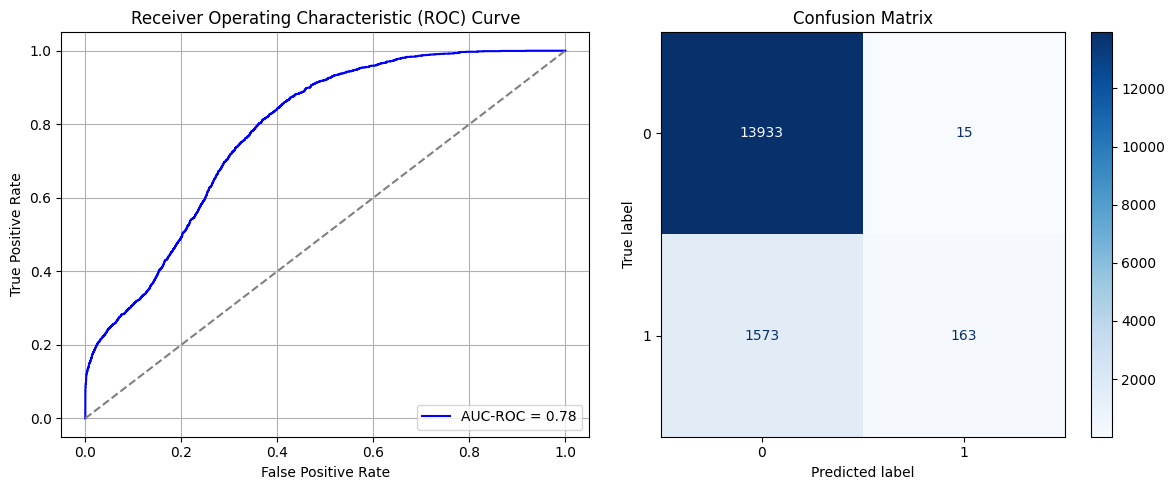

Best threshold based on F1-score: 0.005983585026115179
False Negative Rate: 0.9061059907834101
Time elapsed (performance): 1.4008133329999737


In [32]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)
    model_source = create_dnn_model(X_S_train.shape[1])
    result_imbalanced = train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    Training_time.append(result_imbalanced)
    FPR.append(result_TL_imbalanced[0])
    TNR.append(result_TL_imbalanced[1])
    FNR.append(result_TL_imbalanced[2])
    TPR.append(result_TL_imbalanced[3])
    TL_time.append(result_TL_imbalanced[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [33]:
print(ParamFit)
ParamFit.to_csv('Imbalanced.csv')

## Remember that TPR is actually TNR and TNR is actually TPR!!!

   Source time       FPR       TPR       FNR       TNR  Target time
0    34.397550  0.000645  0.093318  0.906682  0.999355     1.597915
1    31.922090  0.001075  0.118088  0.881912  0.998925     1.290254
2    36.560239  0.001219  0.108295  0.891705  0.998781     2.588104
3    28.749709  0.007815  0.251152  0.748848  0.992185     1.731611
4    31.780714  0.011041  0.272465  0.727535  0.988959     1.718623
5    29.595246  0.003155  0.122120  0.877880  0.996845     1.710325
6    32.416719  0.000789  0.127880  0.872120  0.999211     1.729585
7    28.235492  0.001291  0.143433  0.856567  0.998709     1.263535
8    30.828310  0.020792  0.404954  0.595046  0.979208     1.301766
9    30.528246  0.001075  0.093894  0.906106  0.998925     1.400813


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [34]:
data_S

0      1         2         3         4         5    6     7  \
0      0.301370  0.000  0.044131  0.800000  0.000000  0.000000  0.0  0.00   
1      0.452055  0.125  0.048052  0.800000  0.166667  0.071429  0.2  0.00   
2      0.287671  0.250  0.137581  0.533333  0.333333  0.142857  0.0  0.00   
3      0.493151  0.250  0.150486  0.400000  0.166667  0.142857  0.2  0.25   
4      0.479452  0.125  0.133519  0.533333  0.166667  0.071429  0.2  0.00   
...         ...    ...       ...       ...       ...       ...  ...   ...   
31932  0.424658  0.500  0.227956  0.866667  0.333333  0.285714  0.0  0.00   
31933  0.219178  0.250  0.157583  0.800000  0.000000  0.214286  0.6  0.00   
31934  0.287671  0.250  0.245379  0.800000  0.166667  0.214286  0.2  0.00   
31935  0.369863  0.250  0.048444  0.800000  0.333333  0.000000  0.6  0.50   
31936  0.246575  0.750  0.114919  0.800000  0.166667  0.071429  0.2  0.00   

         8         9   10        11   12  Y  
0      0.0  0.021740  0.0  0.397959  0.0  0  
1      0.0  0.000000  0.0  0.122449  0.0  0  
2      0.0  0.000000  0.0  0.397959  0.0  0  
3      0.0  0.000000  0.0  0.397959  0.0  0  
4      0.0  0.000000  0.0  0.448980  0.0  1  
...    ...       ...  ...       ...  ... ..  
31932  0.0  0.000000  0.0  0.397959  0.0  0  
31933  0.0  0.000000  0.0  0.397959  0.0  0  
31934  0.0  0.000000  0.0  0.500000  0.0  0  
31935  0.0  0.054551  0.0  0.397959  0.0  0  
31936  0.0  0.000000  0.0  0.602041  0.0  1  

[31937 rows x 14 columns]

In [35]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

9805
22132


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7315 - loss: 0.6101 - val_AUC: 0.8574 - val_loss: 0.4805
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8529 - loss: 0.4756 - val_AUC: 0.8773 - val_loss: 0.4346
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8708 - loss: 0.4434 - val_AUC: 0.8794 - val_loss: 0.4315
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8735 - loss: 0.4387 - val_AUC: 0.8808 - val_loss: 0.4287
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8782 - loss: 0.4325 - val_AUC: 0.8812 - val_loss: 0.4324
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8772 - loss: 0.4337 - val_AUC: 0.8808 - val_loss: 0.4300
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8746 - loss: 0.4375 - val_AUC: 0.8806 - val_loss: 0.4281
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8787 - loss: 0.4308 - val_AUC: 0.8822 - val_loss: 0.4371
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8763 -

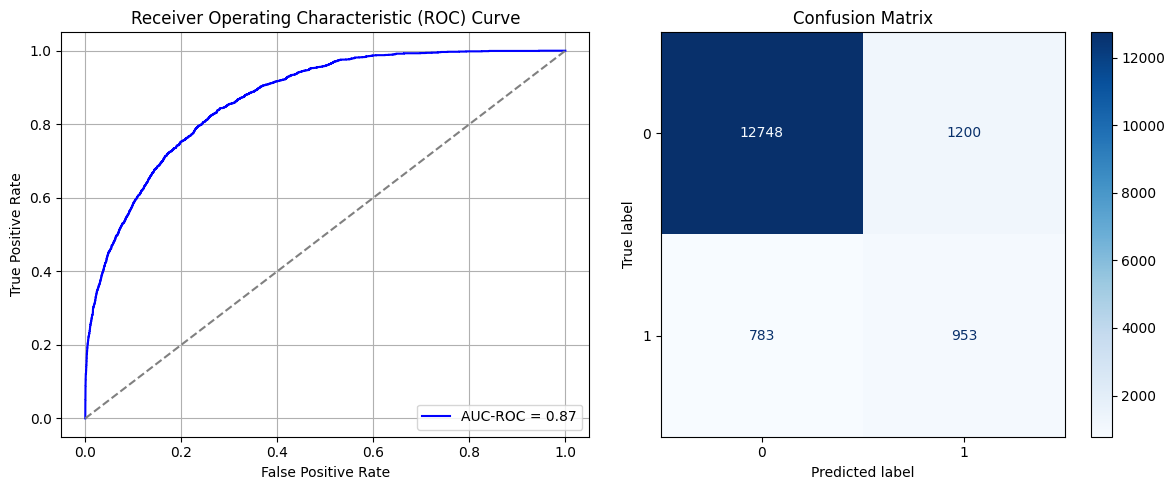

Best threshold based on F1-score: 0.5549534559249878
False Negative Rate: 0.451036866359447
Time elapsed (performance): 1.7218011889999616
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7390 - loss: 0.6090 - val_AUC: 0.8632 - val_loss: 0.4653
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8621 - loss: 0.4627 - val_AUC: 0.8798 - val_loss: 0.4329
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8722 - loss: 0.4428 - val_AUC: 0.8826 - val_loss: 0.4277
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8763 - loss: 0.4359 - val_AUC: 0.8833 - val_loss: 0.4262
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8771 - loss: 0.4344 - val_AUC: 0.8839 - val_loss: 0.4253
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8828 - loss: 0.4236 - val_AUC: 0.8829 - val_loss: 0.4313
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8779 - loss: 0.4332 - val_AUC: 0.8837 - val_loss: 0.4263
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8856 - loss: 0.4188 - val_AUC: 0.8833 - val_loss: 0.4263
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8797 -

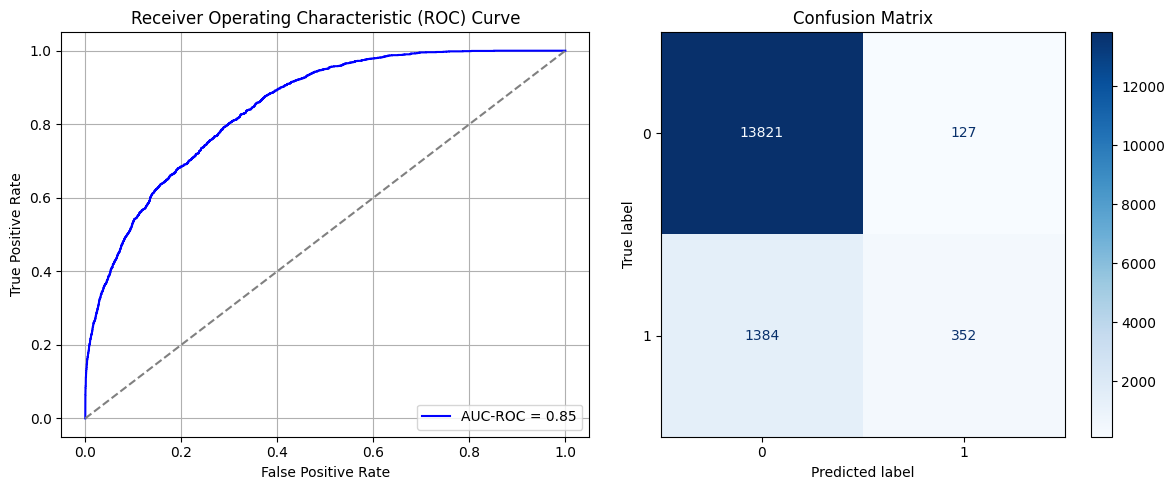

Best threshold based on F1-score: 0.15915106236934662
False Negative Rate: 0.7972350230414746
Time elapsed (performance): 1.3869515110000066
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7221 - loss: 0.6174 - val_AUC: 0.8473 - val_loss: 0.4893
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8531 - loss: 0.4752 - val_AUC: 0.8705 - val_loss: 0.4473
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8697 - loss: 0.4484 - val_AUC: 0.8732 - val_loss: 0.4408
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8685 - loss: 0.4472 - val_AUC: 0.8747 - val_loss: 0.4377
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8764 - loss: 0.4343 - val_AUC: 0.8747 - val_loss: 0.4390
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8761 - loss: 0.4349 - val_AUC: 0.8755 - val_loss: 0.4402
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8794 - loss: 0.4295 - val_AUC: 0.8749 - val_loss: 0.4411
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8814 - loss: 0.4248 - val_AUC: 0.8770 - val_loss: 0.4341
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8842 -

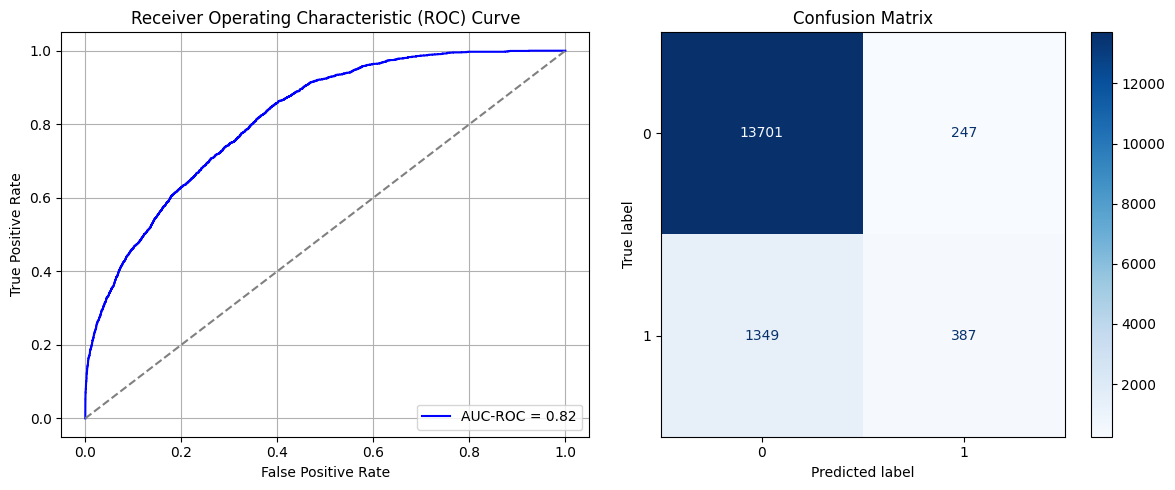

Best threshold based on F1-score: 0.2572278082370758
False Negative Rate: 0.777073732718894
Time elapsed (performance): 1.721454116000018
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7656 - loss: 0.6073 - val_AUC: 0.8577 - val_loss: 0.4734
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8643 - loss: 0.4577 - val_AUC: 0.8748 - val_loss: 0.4395
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8712 - loss: 0.4424 - val_AUC: 0.8775 - val_loss: 0.4461
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4342 - val_AUC: 0.8773 - val_loss: 0.4337
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8810 - loss: 0.4256 - val_AUC: 0.8791 - val_loss: 0.4325
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8682 - loss: 0.4472 - val_AUC: 0.8788 - val_loss: 0.4472
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8743 - loss: 0.4394 - val_AUC: 0.8797 - val_loss: 0.4320
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8738 - loss: 0.4363 - val_AUC: 0.8795 - val_loss: 0.4391
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8835 -

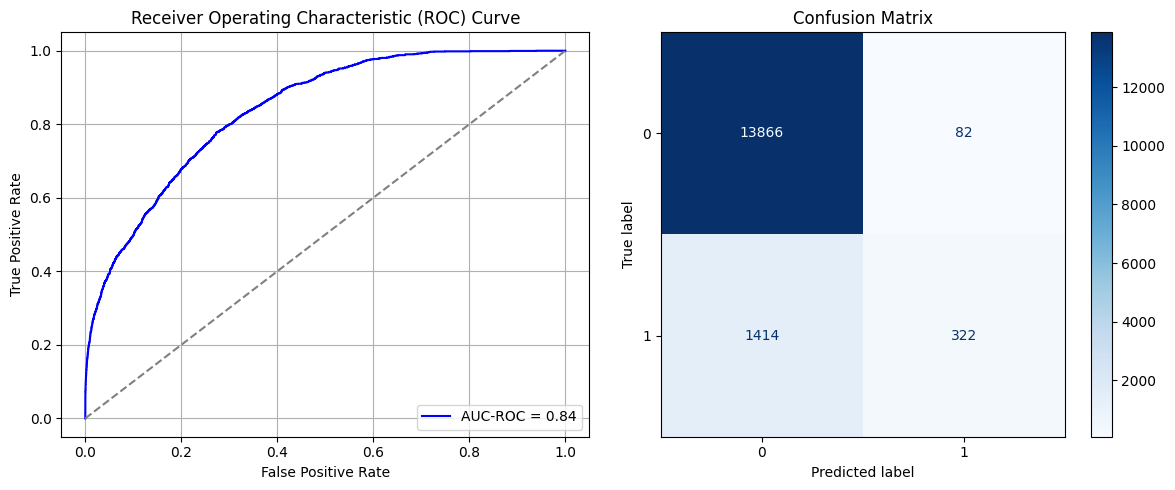

Best threshold based on F1-score: 0.13188505172729492
False Negative Rate: 0.8145161290322581
Time elapsed (performance): 1.736914922999972
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7579 - loss: 0.6040 - val_AUC: 0.8599 - val_loss: 0.4697
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8572 - loss: 0.4668 - val_AUC: 0.8724 - val_loss: 0.4473
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8720 - loss: 0.4400 - val_AUC: 0.8747 - val_loss: 0.4605
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8738 - loss: 0.4382 - val_AUC: 0.8761 - val_loss: 0.4431
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8683 - loss: 0.4477 - val_AUC: 0.8773 - val_loss: 0.4342
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8742 - loss: 0.4373 - val_AUC: 0.8758 - val_loss: 0.4452
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.8754 - loss: 0.4352 - val_AUC: 0.8772 - val_loss: 0.4356
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8801 - loss: 0.4306 - val_AUC: 0.8772 - val_loss: 0.4346
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8749 -

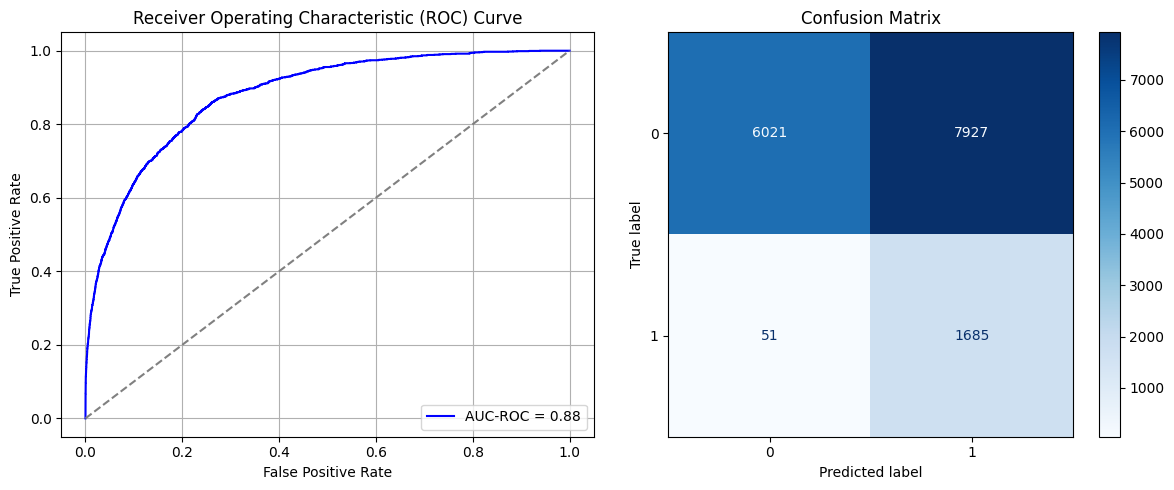

Best threshold based on F1-score: 0.8584370613098145
False Negative Rate: 0.0293778801843318
Time elapsed (performance): 1.3359052179999935
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7490 - loss: 0.6205 - val_AUC: 0.8513 - val_loss: 0.4812
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8577 - loss: 0.4671 - val_AUC: 0.8688 - val_loss: 0.4560
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8708 - loss: 0.4433 - val_AUC: 0.8737 - val_loss: 0.4439
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8768 - loss: 0.4335 - val_AUC: 0.8751 - val_loss: 0.4491
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8732 - loss: 0.4398 - val_AUC: 0.8751 - val_loss: 0.4380
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8718 - loss: 0.4402 - val_AUC: 0.8760 - val_loss: 0.4589
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4354 - val_AUC: 0.8756 - val_loss: 0.4416
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8757 - loss: 0.4356 - val_AUC: 0.8765 - val_loss: 0.4360
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 -

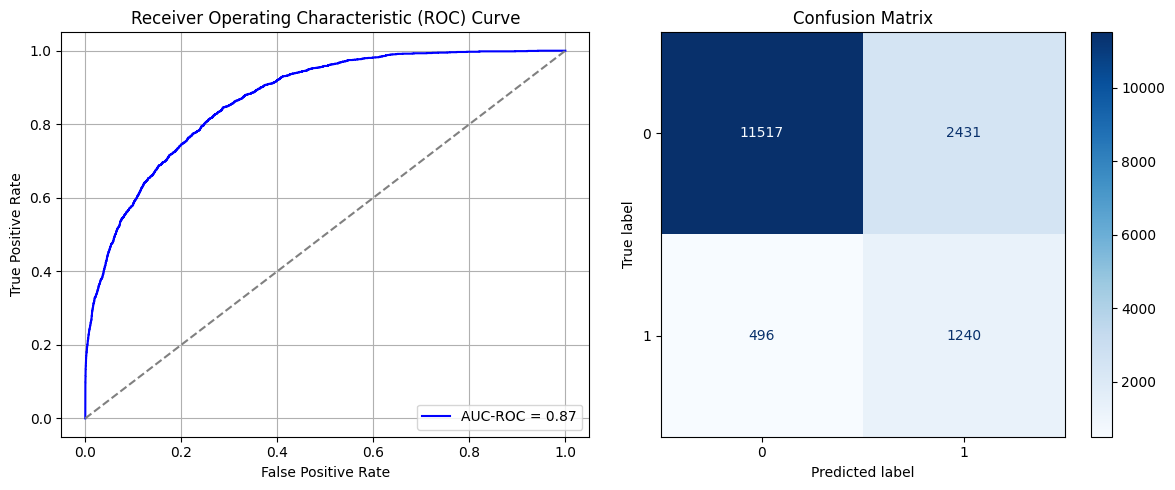

Best threshold based on F1-score: 0.6696138381958008
False Negative Rate: 0.2857142857142857
Time elapsed (performance): 1.268372402999944
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7569 - loss: 0.6060 - val_AUC: 0.8558 - val_loss: 0.4776
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8575 - loss: 0.4691 - val_AUC: 0.8751 - val_loss: 0.4481
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8739 - loss: 0.4396 - val_AUC: 0.8765 - val_loss: 0.4384
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8749 - loss: 0.4386 - val_AUC: 0.8781 - val_loss: 0.4367
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8787 - loss: 0.4313 - val_AUC: 0.8787 - val_loss: 0.4541
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8792 - loss: 0.4289 - val_AUC: 0.8788 - val_loss: 0.4542
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8786 - loss: 0.4301 - val_AUC: 0.8789 - val_loss: 0.4319
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8825 - loss: 0.4248 - val_AUC: 0.8789 - val_loss: 0.4384
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8766 -

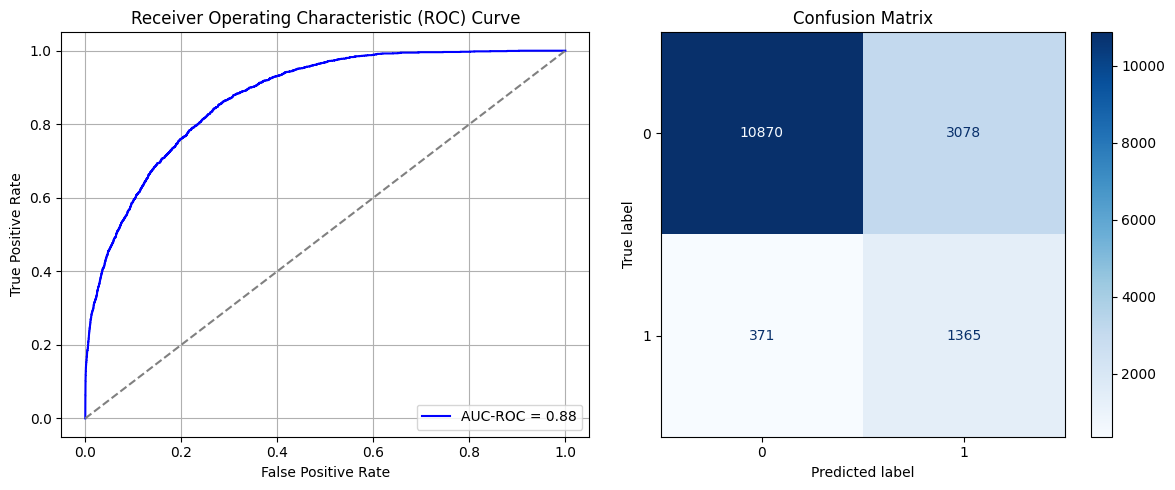

Best threshold based on F1-score: 0.683222770690918
False Negative Rate: 0.21370967741935484
Time elapsed (performance): 1.2595956610000485
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7584 - loss: 0.6043 - val_AUC: 0.8582 - val_loss: 0.4696
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8614 - loss: 0.4612 - val_AUC: 0.8739 - val_loss: 0.4404
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8681 - loss: 0.4469 - val_AUC: 0.8747 - val_loss: 0.4535
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8756 - loss: 0.4365 - val_AUC: 0.8769 - val_loss: 0.4365
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8689 - loss: 0.4437 - val_AUC: 0.8778 - val_loss: 0.4353
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8750 - loss: 0.4346 - val_AUC: 0.8773 - val_loss: 0.4352
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8732 - loss: 0.4387 - val_AUC: 0.8787 - val_loss: 0.4334
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8800 - loss: 0.4275 - val_AUC: 0.8782 - val_loss: 0.4364
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8782 -

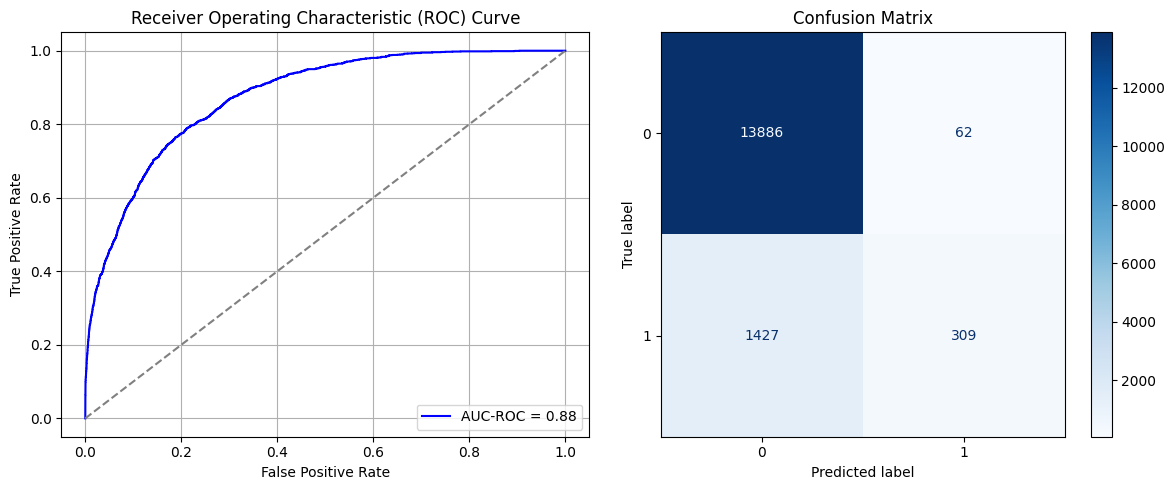

Best threshold based on F1-score: 0.0946173220872879
False Negative Rate: 0.8220046082949308
Time elapsed (performance): 1.6069118510000635
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7322 - loss: 0.6129 - val_AUC: 0.8622 - val_loss: 0.5053
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8571 - loss: 0.4664 - val_AUC: 0.8810 - val_loss: 0.4310
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8720 - loss: 0.4430 - val_AUC: 0.8832 - val_loss: 0.4334
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8733 - loss: 0.4389 - val_AUC: 0.8844 - val_loss: 0.4242
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8769 - loss: 0.4339 - val_AUC: 0.8837 - val_loss: 0.4255
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8809 - loss: 0.4277 - val_AUC: 0.8841 - val_loss: 0.4261
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8739 - loss: 0.4382 - val_AUC: 0.8855 - val_loss: 0.4273
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8732 - loss: 0.4402 - val_AUC: 0.8857 - val_loss: 0.4264
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8779 -

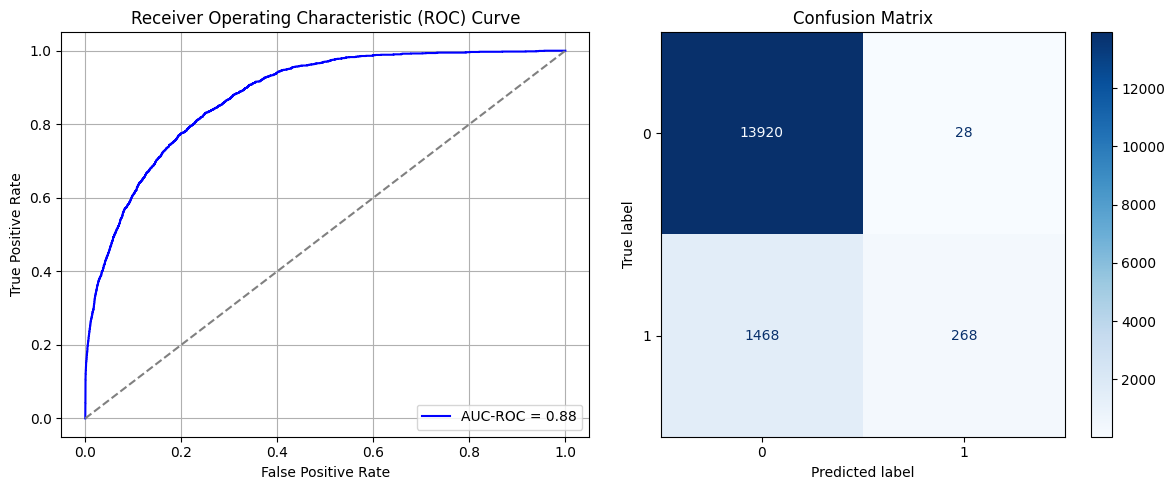

Best threshold based on F1-score: 0.12192771583795547
False Negative Rate: 0.8456221198156681
Time elapsed (performance): 1.2962579229999847
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7280 - loss: 0.6176 - val_AUC: 0.8675 - val_loss: 0.4709
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8557 - loss: 0.4689 - val_AUC: 0.8780 - val_loss: 0.4380
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8713 - loss: 0.4421 - val_AUC: 0.8798 - val_loss: 0.4469
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8636 - loss: 0.4538 - val_AUC: 0.8790 - val_loss: 0.4336
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8711 - loss: 0.4419 - val_AUC: 0.8798 - val_loss: 0.4312
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8700 - loss: 0.4433 - val_AUC: 0.8789 - val_loss: 0.4323
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8726 - loss: 0.4389 - val_AUC: 0.8796 - val_loss: 0.4312
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8760 - loss: 0.4349 - val_AUC: 0.8797 - val_loss: 0.4308
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8716 -

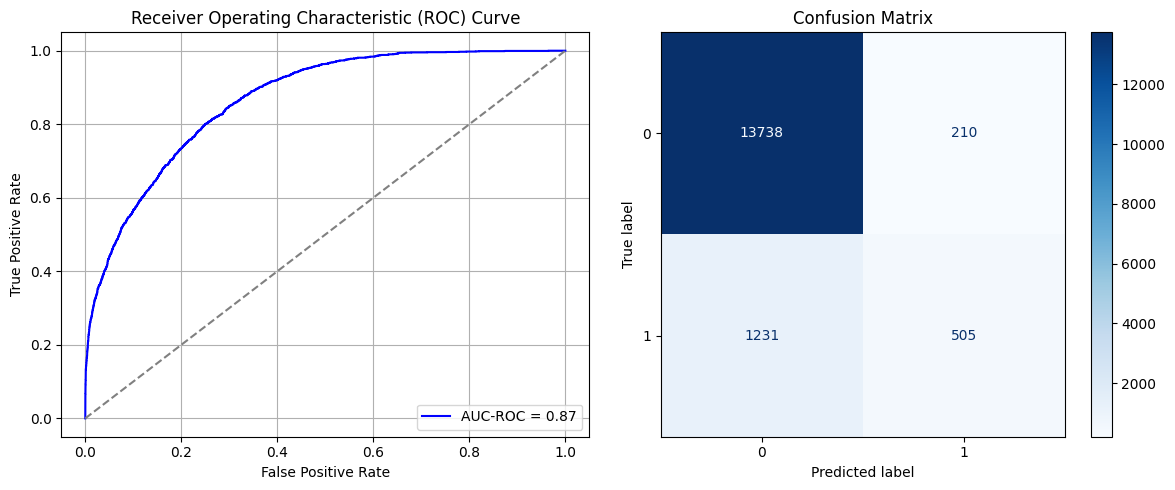

Best threshold based on F1-score: 0.24507081508636475
False Negative Rate: 0.7091013824884793
Time elapsed (performance): 1.3472786710000264


In [36]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
    data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRS = data_S_SRS_RUS.iloc[:, :-1]
    y_S_SRS = data_S_SRS_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
    model_SRS = create_dnn_model(X_S_train.shape[1])
    result_SRS = train_and_evaluate(model_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS = Transductive_TL(model_SRS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS)
    FPR.append(result_TL_SRS[0])
    TNR.append(result_TL_SRS[1])
    FNR.append(result_TL_SRS[2])
    TPR.append(result_TL_SRS[3])
    TL_time.append(result_TL_SRS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [37]:
print(ParamFit)
ParamFit.to_csv('SRS_RUS.csv')

   Source time       FPR       TPR       FNR       TNR  Target time
0    23.907917  0.086034  0.548963  0.451037  0.913966     1.721801
1    24.989450  0.009105  0.202765  0.797235  0.990895     1.386952
2    23.828851  0.017709  0.222926  0.777074  0.982291     1.721454
3    22.768284  0.005879  0.185484  0.814516  0.994121     1.736915
4    24.425879  0.568325  0.970622  0.029378  0.431675     1.335905
5    22.001305  0.174290  0.714286  0.285714  0.825710     1.268372
6    23.942252  0.220677  0.786290  0.213710  0.779323     1.259596
7    24.127066  0.004445  0.177995  0.822005  0.995555     1.606912
8    23.033637  0.002007  0.154378  0.845622  0.997993     1.296258
9    24.248949  0.015056  0.290899  0.709101  0.984944     1.347279


## Simple Random Sampling with Replacement:

In [38]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

9805
22132


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7684 - loss: 0.5991 - val_AUC: 0.8641 - val_loss: 0.4708
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8619 - loss: 0.4603 - val_AUC: 0.8753 - val_loss: 0.4376
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8755 - loss: 0.4360 - val_AUC: 0.8775 - val_loss: 0.4354
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8774 - loss: 0.4348 - val_AUC: 0.8771 - val_loss: 0.4506
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8811 - loss: 0.4276 - val_AUC: 0.8792 - val_loss: 0.4309
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8818 - loss: 0.4271 - val_AUC: 0.8797 - val_loss: 0.4305
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8787 - loss: 0.4299 - val_AUC: 0.8798 - val_loss: 0.4301
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8771 - loss: 0.4331 - val_AUC: 0.8801 - val_loss: 0.4383
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AU

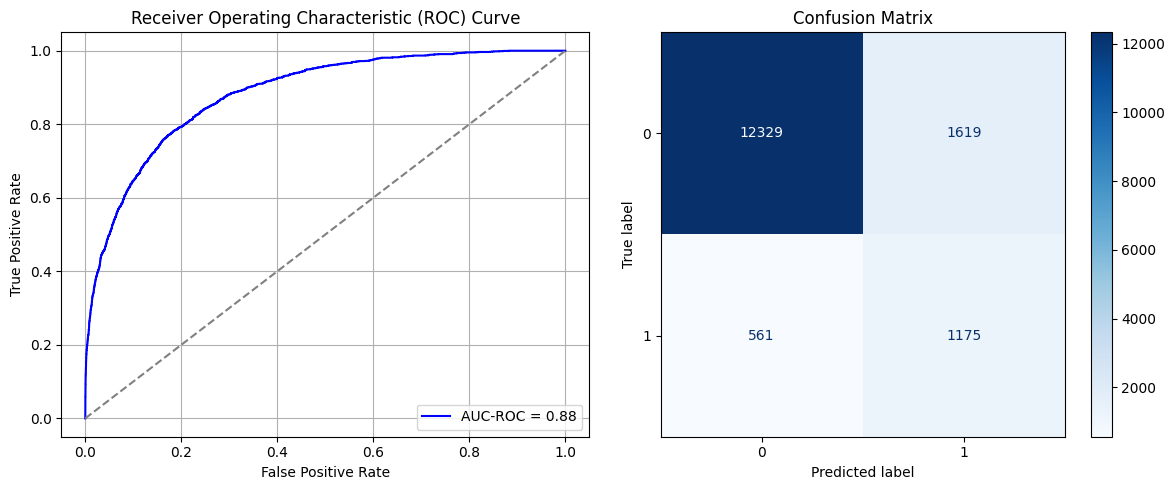

Best threshold based on F1-score: 0.5919749140739441
False Negative Rate: 0.32315668202764974
Time elapsed (performance): 1.7370315579998987
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7517 - loss: 0.6133 - val_AUC: 0.8594 - val_loss: 0.4733
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8638 - loss: 0.4559 - val_AUC: 0.8717 - val_loss: 0.4436
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8700 - loss: 0.4452 - val_AUC: 0.8746 - val_loss: 0.4385
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8775 - loss: 0.4336 - val_AUC: 0.8742 - val_loss: 0.4373
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8747 - loss: 0.4365 - val_AUC: 0.8759 - val_loss: 0.4380
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8686 - loss: 0.4461 - val_AUC: 0.8772 - val_loss: 0.4333
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8723 - loss: 0.4419 - val_AUC: 0.8776 - val_loss: 0.4366
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8777 - loss: 0.4310 - val_AUC: 0.8785 - val_loss: 0.4335
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8792 -

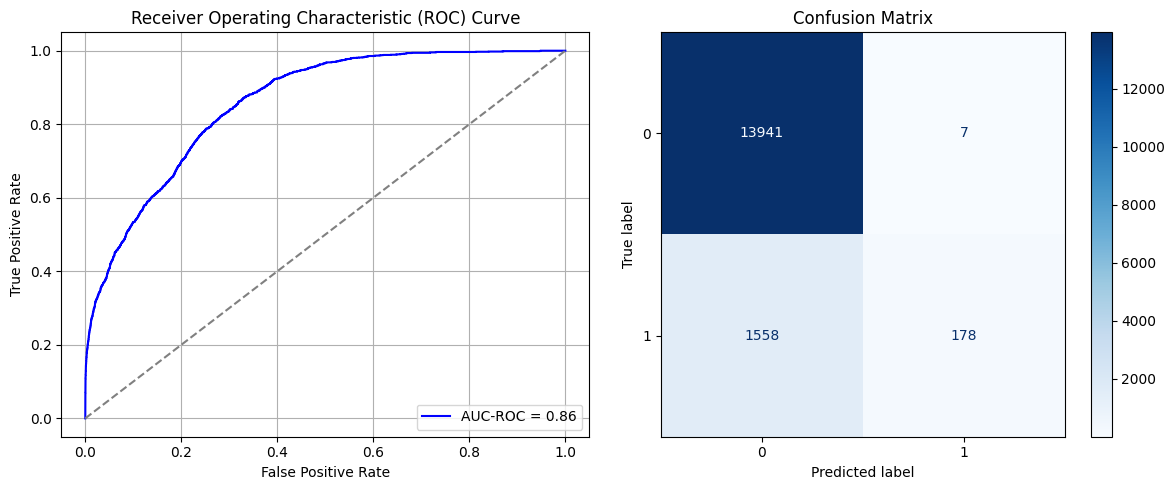

Best threshold based on F1-score: 0.04219472035765648
False Negative Rate: 0.8974654377880185
Time elapsed (performance): 1.3512714940000023
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7386 - loss: 0.6076 - val_AUC: 0.8635 - val_loss: 0.4783
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8628 - loss: 0.4638 - val_AUC: 0.8803 - val_loss: 0.4341
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8767 - loss: 0.4362 - val_AUC: 0.8812 - val_loss: 0.4415
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8746 - loss: 0.4363 - val_AUC: 0.8845 - val_loss: 0.4249
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8772 - loss: 0.4331 - val_AUC: 0.8822 - val_loss: 0.4321
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8783 - loss: 0.4313 - val_AUC: 0.8837 - val_loss: 0.4252
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8781 - loss: 0.4311 - val_AUC: 0.8831 - val_loss: 0.4261
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8805 - loss: 0.4276 - val_AUC: 0.8847 - val_loss: 0.4270
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8814 -

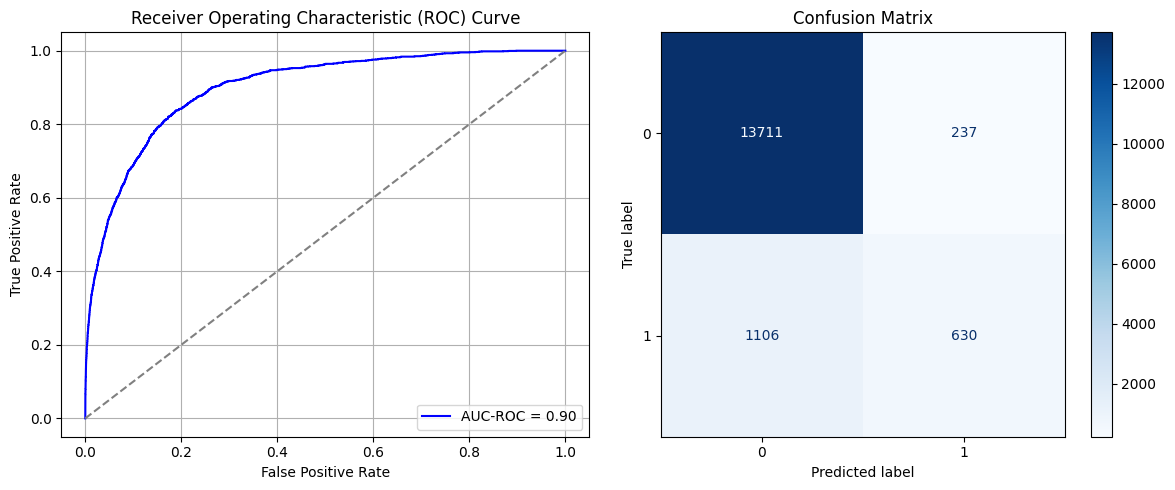

Best threshold based on F1-score: 0.3010421097278595
False Negative Rate: 0.6370967741935484
Time elapsed (performance): 1.3041871289999563
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7240 - loss: 0.6267 - val_AUC: 0.8574 - val_loss: 0.4821
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8641 - loss: 0.4612 - val_AUC: 0.8723 - val_loss: 0.4450
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8746 - loss: 0.4376 - val_AUC: 0.8741 - val_loss: 0.4407
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8761 - loss: 0.4338 - val_AUC: 0.8733 - val_loss: 0.4439
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8733 - loss: 0.4378 - val_AUC: 0.8751 - val_loss: 0.4388
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4280 - val_AUC: 0.8737 - val_loss: 0.4404
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8736 - loss: 0.4401 - val_AUC: 0.8752 - val_loss: 0.4436
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8806 - loss: 0.4269 - val_AUC: 0.8745 - val_loss: 0.4419
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8798 -

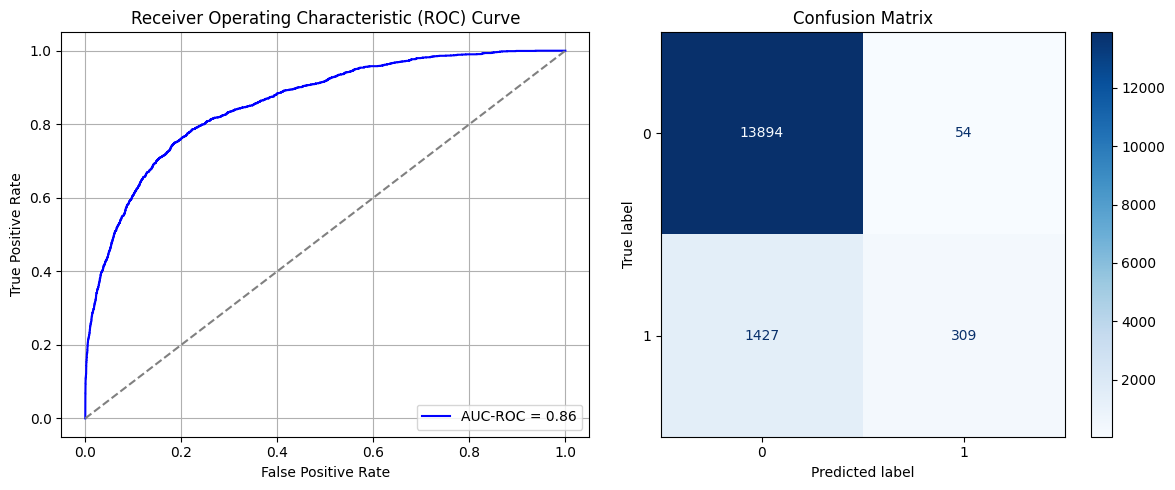

Best threshold based on F1-score: 0.13375671207904816
False Negative Rate: 0.8220046082949308
Time elapsed (performance): 1.2794709299998885
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7464 - loss: 0.6093 - val_AUC: 0.8617 - val_loss: 0.4758
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8611 - loss: 0.4608 - val_AUC: 0.8737 - val_loss: 0.4971
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8683 - loss: 0.4491 - val_AUC: 0.8772 - val_loss: 0.4357
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8752 - loss: 0.4370 - val_AUC: 0.8770 - val_loss: 0.4393
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8833 - loss: 0.4250 - val_AUC: 0.8781 - val_loss: 0.4338
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8801 - loss: 0.4281 - val_AUC: 0.8780 - val_loss: 0.4329
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8838 - loss: 0.4221 - val_AUC: 0.8790 - val_loss: 0.4308
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8807 - loss: 0.4279 - val_AUC: 0.8779 - val_loss: 0.4368
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8797 -

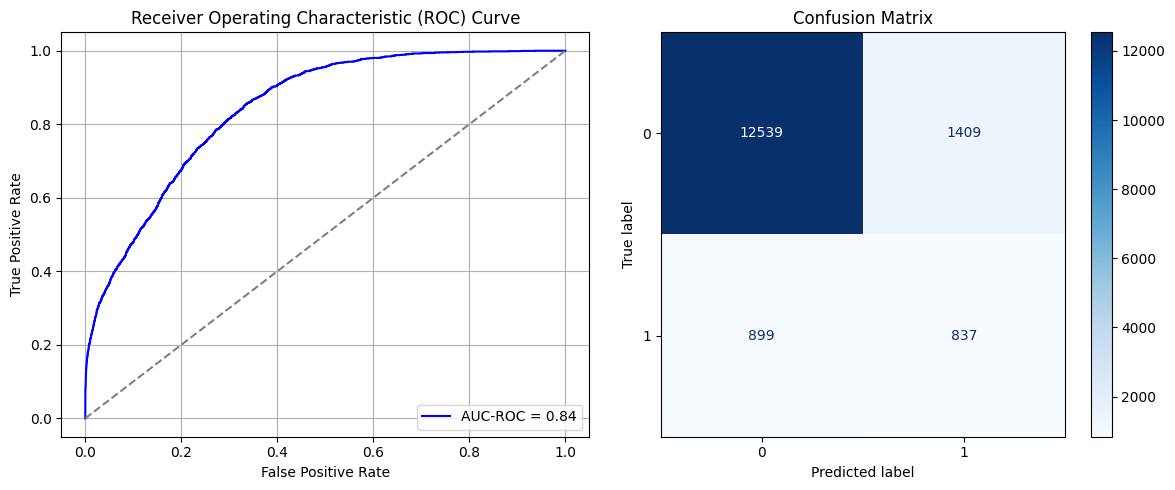

Best threshold based on F1-score: 0.5177943706512451
False Negative Rate: 0.5178571428571429
Time elapsed (performance): 1.3012499750000188
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6908 - loss: 0.6255 - val_AUC: 0.8499 - val_loss: 0.4862
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8534 - loss: 0.4768 - val_AUC: 0.8690 - val_loss: 0.4472
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8628 - loss: 0.4567 - val_AUC: 0.8731 - val_loss: 0.4401
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8707 - loss: 0.4431 - val_AUC: 0.8736 - val_loss: 0.4475
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8743 - loss: 0.4361 - val_AUC: 0.8746 - val_loss: 0.4378
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8640 - loss: 0.4510 - val_AUC: 0.8750 - val_loss: 0.4391
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8758 - loss: 0.4357 - val_AUC: 0.8742 - val_loss: 0.4388
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8731 - loss: 0.4369 - val_AUC: 0.8758 - val_loss: 0.4378
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8714 -

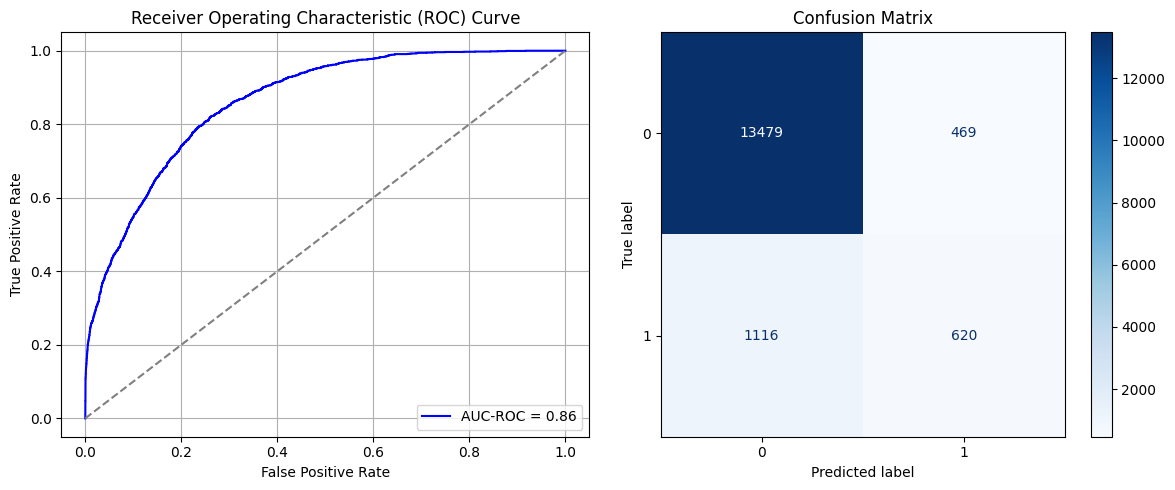

Best threshold based on F1-score: 0.35598379373550415
False Negative Rate: 0.6428571428571429
Time elapsed (performance): 1.7496809119998034
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7390 - loss: 0.6100 - val_AUC: 0.8555 - val_loss: 0.4800
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8597 - loss: 0.4654 - val_AUC: 0.8661 - val_loss: 0.4537
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8653 - loss: 0.4512 - val_AUC: 0.8712 - val_loss: 0.4506
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8662 - loss: 0.4481 - val_AUC: 0.8702 - val_loss: 0.4539
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8743 - loss: 0.4366 - val_AUC: 0.8714 - val_loss: 0.4446
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8789 - loss: 0.4309 - val_AUC: 0.8712 - val_loss: 0.4443
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8704 - loss: 0.4431 - val_AUC: 0.8727 - val_loss: 0.4498
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8791 - loss: 0.4287 - val_AUC: 0.8716 - val_loss: 0.4528
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8695 -

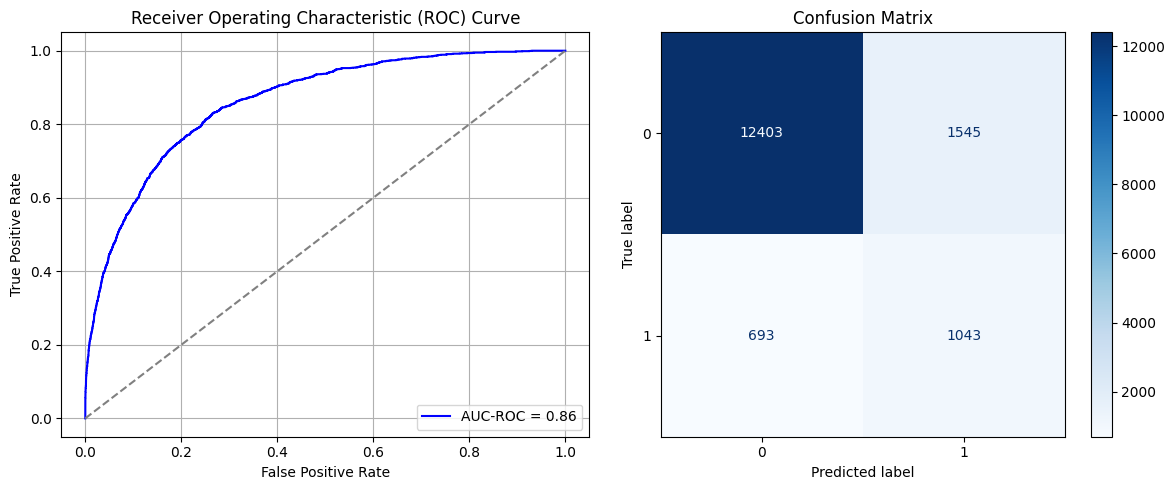

Best threshold based on F1-score: 0.5427102446556091
False Negative Rate: 0.39919354838709675
Time elapsed (performance): 1.383802937999917
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7435 - loss: 0.6090 - val_AUC: 0.8519 - val_loss: 0.4839
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8590 - loss: 0.4669 - val_AUC: 0.8731 - val_loss: 0.4427
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8768 - loss: 0.4354 - val_AUC: 0.8770 - val_loss: 0.4368
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8693 - loss: 0.4434 - val_AUC: 0.8797 - val_loss: 0.4322
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8745 - loss: 0.4374 - val_AUC: 0.8790 - val_loss: 0.4323
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8758 - loss: 0.4339 - val_AUC: 0.8782 - val_loss: 0.4329
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8774 - loss: 0.4319 - val_AUC: 0.8804 - val_loss: 0.4338
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8849 - loss: 0.4183 - val_AUC: 0.8804 - val_loss: 0.4330
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8836 -

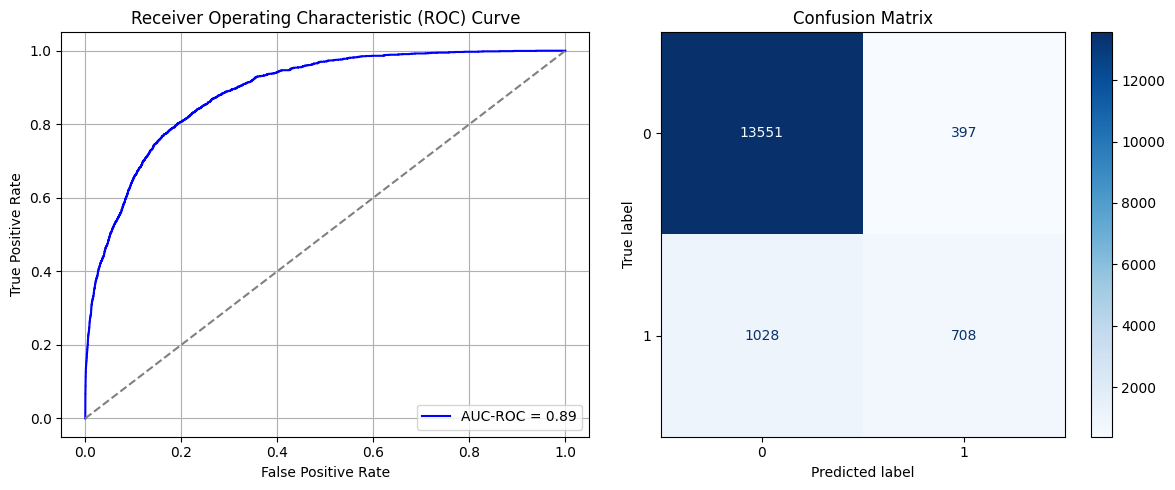

Best threshold based on F1-score: 0.30071163177490234
False Negative Rate: 0.5921658986175116
Time elapsed (performance): 1.335908279000023
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7154 - loss: 0.6247 - val_AUC: 0.8558 - val_loss: 0.4893
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8611 - loss: 0.4655 - val_AUC: 0.8748 - val_loss: 0.4450
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8724 - loss: 0.4417 - val_AUC: 0.8794 - val_loss: 0.4373
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8727 - loss: 0.4398 - val_AUC: 0.8780 - val_loss: 0.4359
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8726 - loss: 0.4424 - val_AUC: 0.8800 - val_loss: 0.4404
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8718 - loss: 0.4427 - val_AUC: 0.8796 - val_loss: 0.4315
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8746 - loss: 0.4358 - val_AUC: 0.8795 - val_loss: 0.4336
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8740 - loss: 0.4365 - val_AUC: 0.8811 - val_loss: 0.4350
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8798 -

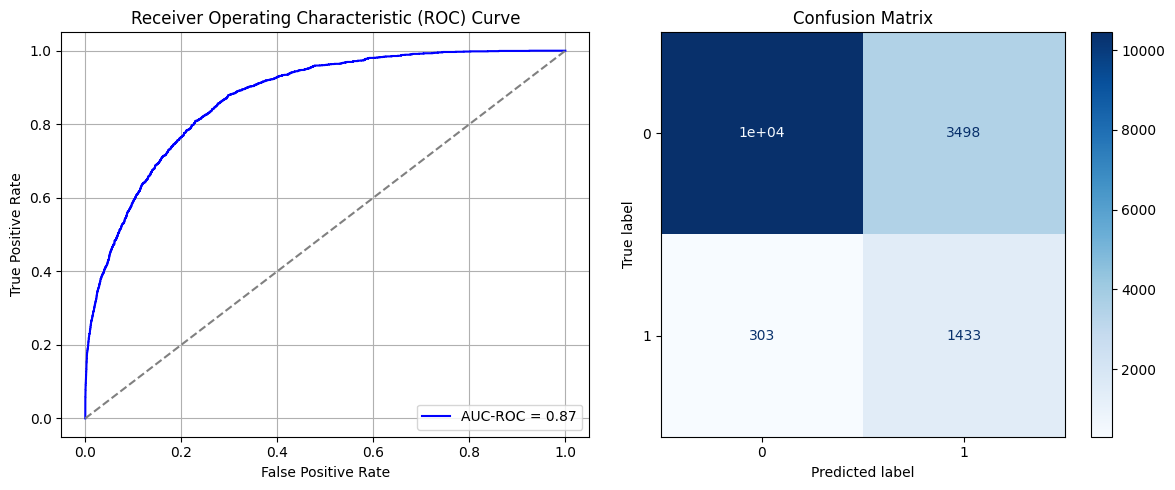

Best threshold based on F1-score: 0.7206210494041443
False Negative Rate: 0.17453917050691245
Time elapsed (performance): 1.3441111980000642
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7210 - loss: 0.6172 - val_AUC: 0.8567 - val_loss: 0.5147
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8672 - loss: 0.4557 - val_AUC: 0.8705 - val_loss: 0.4457
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8723 - loss: 0.4431 - val_AUC: 0.8721 - val_loss: 0.4431
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8701 - loss: 0.4458 - val_AUC: 0.8748 - val_loss: 0.4501
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8715 - loss: 0.4427 - val_AUC: 0.8749 - val_loss: 0.4489
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8756 - loss: 0.4382 - val_AUC: 0.8758 - val_loss: 0.4380
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4300 - val_AUC: 0.8754 - val_loss: 0.4364
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8855 - loss: 0.4203 - val_AUC: 0.8756 - val_loss: 0.4351
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 -

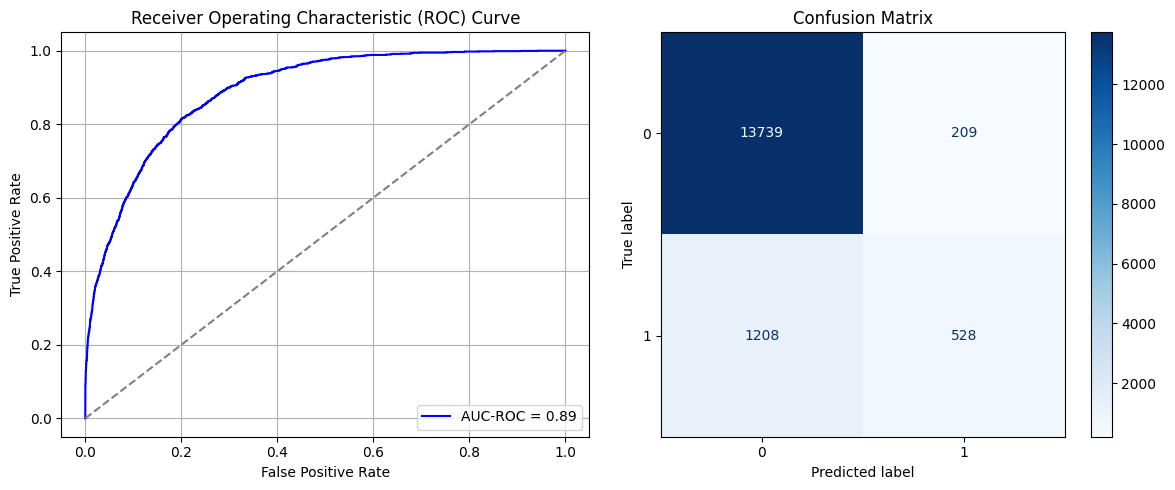

Best threshold based on F1-score: 0.20438939332962036
False Negative Rate: 0.695852534562212
Time elapsed (performance): 1.3214869660000659


In [39]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
    data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :-1]
    y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
    model_SRSwR = create_dnn_model(X_S_train.shape[1])
    result_SRSwR = train_and_evaluate(model_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRSwR = Transductive_TL(model_SRSwR, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRSwR)
    FPR.append(result_TL_SRSwR[0])
    TNR.append(result_TL_SRSwR[1])
    FNR.append(result_TL_SRSwR[2])
    TPR.append(result_TL_SRSwR[3])
    TL_time.append(result_TL_SRSwR[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [40]:
print(ParamFit)
ParamFit.to_csv('SRSwR_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    24.899585  0.116074  0.883926  0.323157  0.676843     1.737032
1    21.948042  0.000502  0.999498  0.897465  0.102535     1.351271
2    22.022633  0.016992  0.983008  0.637097  0.362903     1.304187
3    22.303183  0.003872  0.996128  0.822005  0.177995     1.279471
4    24.090175  0.101018  0.898982  0.517857  0.482143     1.301250
5    26.827394  0.033625  0.966375  0.642857  0.357143     1.749681
6    23.356412  0.110769  0.889231  0.399194  0.600806     1.383803
7    24.086390  0.028463  0.971537  0.592166  0.407834     1.335908
8    20.826784  0.250789  0.749211  0.174539  0.825461     1.344111
9    23.541164  0.014984  0.985016  0.695853  0.304147     1.321487


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

2.25721570627231
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7509 - loss: 0.6115 - val_AUC: 0.8640 - val_loss: 0.4642
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8574 - loss: 0.4655 - val_AUC: 0.8754 - val_loss: 0.4379
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8730 - loss: 0.4423 - val_AUC: 0.8778 - val_loss: 0.4439
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8696 - loss: 0.4461 - val_AUC: 0.8789 - val_loss: 0.4321
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8710 - loss: 0.4431 - val_AUC: 0.8792 - val_loss: 0.4304
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8742 - loss: 0.4402 - val_AUC: 0.8768 - val_loss: 0.4405
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8677 - loss: 0.4480 - val_AUC: 0.8801 - val_loss: 0.4289
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8693 - loss: 0.4463 - val_AUC: 0.8798 - val_loss: 0.4343
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8796 -

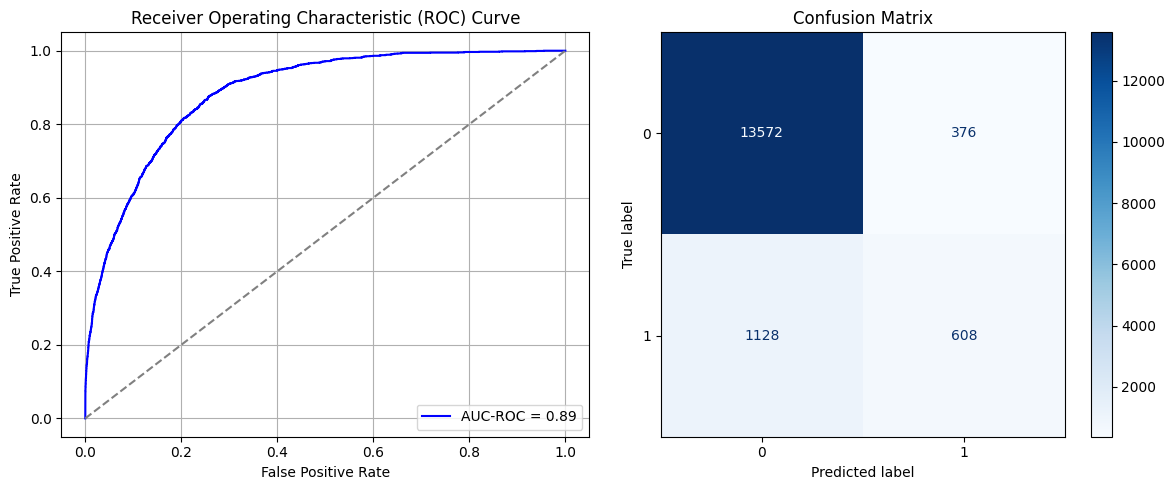

Best threshold based on F1-score: 0.29218336939811707
False Negative Rate: 0.6497695852534562
Time elapsed (performance): 1.7059552139999141
(np.float64(0.02695726985947806), np.float64(0.9730427301405219))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7389 - loss: 0.6202 - val_AUC: 0.8464 - val_loss: 0.4885
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8575 - loss: 0.4716 - val_AUC: 0.8630 - val_loss: 0.4587
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4409 - val_AUC: 0.8694 - val_loss: 0.4448
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8721 - loss: 0.4409 - val_AUC: 0.8702 - val_loss: 0.4518
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8758 - loss: 0.4347 - val_AUC: 0.8709 - val_loss: 0.4500
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8774 - loss: 0.4333 - val_AUC: 0.8717 - val_loss: 0.4579
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8746 - loss: 0.4368 - val_AUC: 0.8720 - val_loss: 0.4502
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8785 - loss: 0.4317 - val_AUC: 0.8734 - val_loss: 0.4392
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8812 -

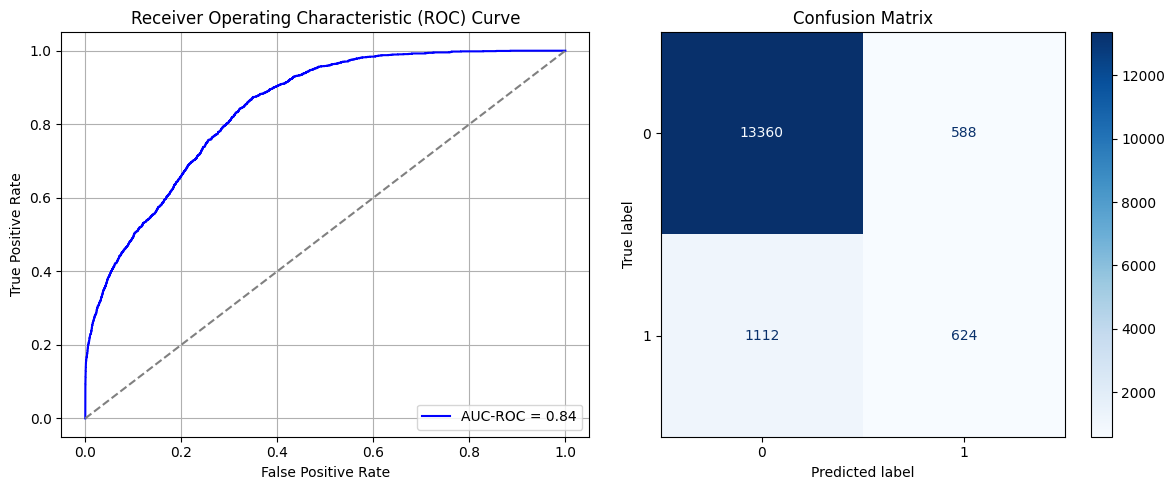

Best threshold based on F1-score: 0.420219749212265
False Negative Rate: 0.6405529953917051
Time elapsed (performance): 1.7122642520000682
(np.float64(0.04215658158875824), np.float64(0.9578434184112418))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7176 - loss: 0.6191 - val_AUC: 0.8451 - val_loss: 0.4836
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8610 - loss: 0.4638 - val_AUC: 0.8676 - val_loss: 0.4624
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8754 - loss: 0.4387 - val_AUC: 0.8686 - val_loss: 0.4528
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4428 - val_AUC: 0.8699 - val_loss: 0.4502
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8789 - loss: 0.4299 - val_AUC: 0.8708 - val_loss: 0.4446
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8776 - loss: 0.4339 - val_AUC: 0.8705 - val_loss: 0.4473
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8778 - loss: 0.4305 - val_AUC: 0.8729 - val_loss: 0.4464
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8746 - loss: 0.4384 - val_AUC: 0.8729 - val_loss: 0.4426
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8761 -

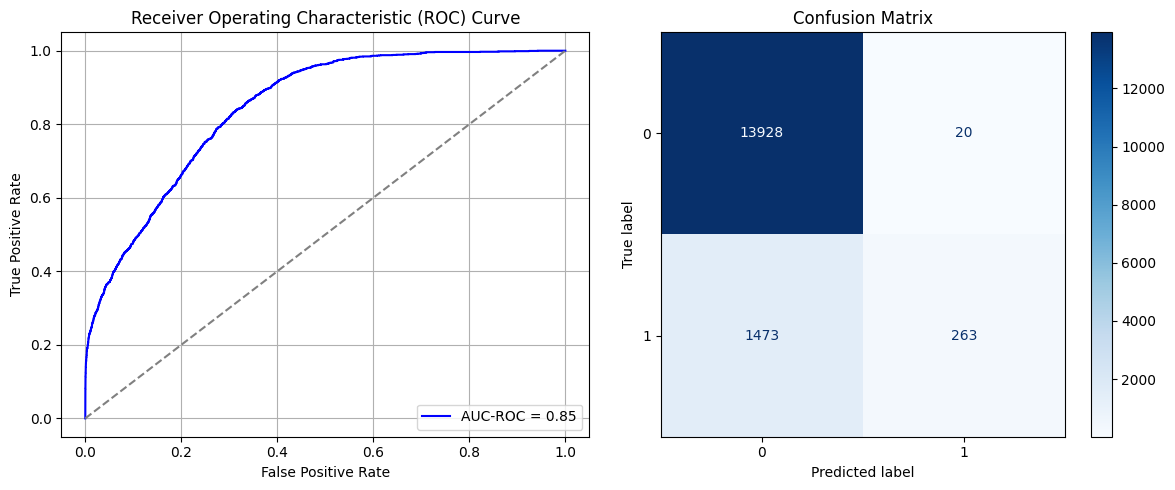

Best threshold based on F1-score: 0.09195590019226074
False Negative Rate: 0.8485023041474654
Time elapsed (performance): 1.2743290139999317
(np.float64(0.0014338973329509608), np.float64(0.998566102667049))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7360 - loss: 0.6156 - val_AUC: 0.8601 - val_loss: 0.4696
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8601 - loss: 0.4646 - val_AUC: 0.8765 - val_loss: 0.4372
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8716 - loss: 0.4428 - val_AUC: 0.8779 - val_loss: 0.4345
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4344 - val_AUC: 0.8780 - val_loss: 0.4325
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8700 - loss: 0.4433 - val_AUC: 0.8787 - val_loss: 0.4403
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8667 - loss: 0.4478 - val_AUC: 0.8791 - val_loss: 0.4353
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8745 - loss: 0.4377 - val_AUC: 0.8790 - val_loss: 0.4296
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8781 - loss: 0.4291 - val_AUC: 0.8782 - val_loss: 0.4342
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8730 -

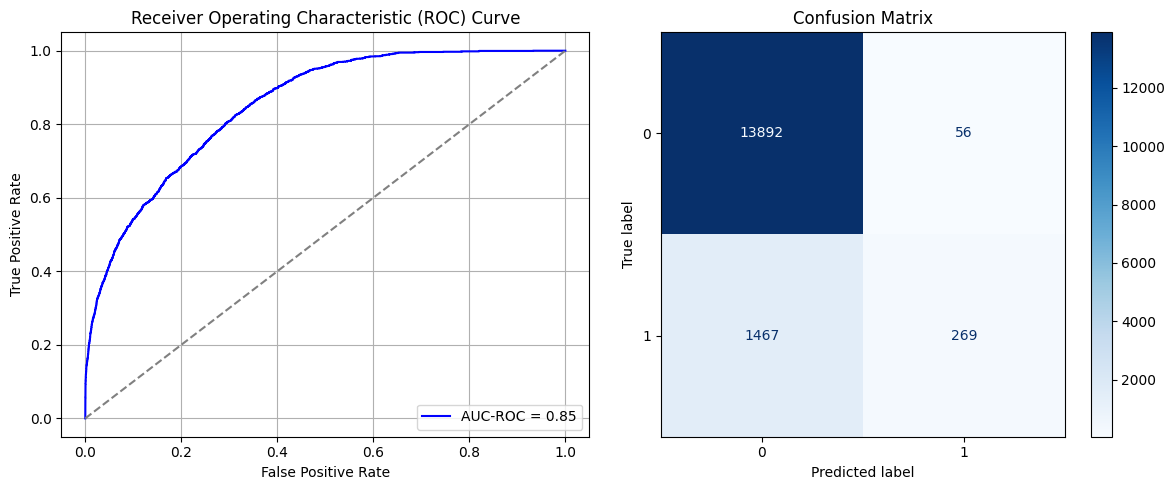

Best threshold based on F1-score: 0.10390069335699081
False Negative Rate: 0.8450460829493087
Time elapsed (performance): 1.279158440999936
(np.float64(0.00401491253226269), np.float64(0.9959850874677373))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7610 - loss: 0.6024 - val_AUC: 0.8682 - val_loss: 0.4592
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8581 - loss: 0.4685 - val_AUC: 0.8776 - val_loss: 0.4406
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8727 - loss: 0.4412 - val_AUC: 0.8797 - val_loss: 0.4312
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8737 - loss: 0.4409 - val_AUC: 0.8788 - val_loss: 0.4336
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8704 - loss: 0.4439 - val_AUC: 0.8794 - val_loss: 0.4327
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8741 - loss: 0.4369 - val_AUC: 0.8810 - val_loss: 0.4282
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.8804 - loss: 0.4275 - val_AUC: 0.8789 - val_loss: 0.4327
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8758 - loss: 0.4347 - val_AUC: 0.8798 - val_loss: 0.4304
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8760 -

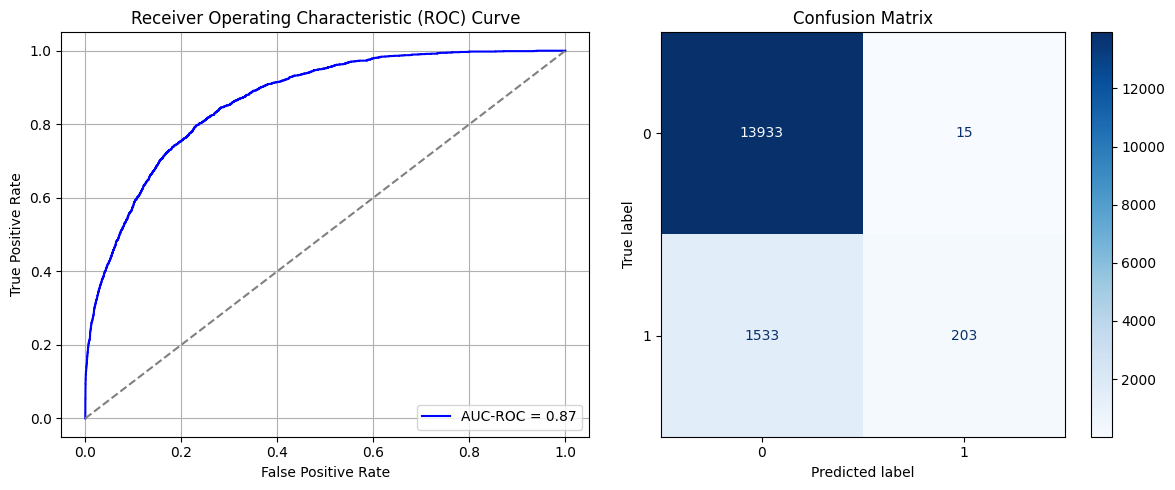

Best threshold based on F1-score: 0.06056631729006767
False Negative Rate: 0.8830645161290323
Time elapsed (performance): 2.5749607830000514
(np.float64(0.0010754229997132205), np.float64(0.9989245770002868))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7161 - loss: 0.6181 - val_AUC: 0.8486 - val_loss: 0.4825
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8563 - loss: 0.4709 - val_AUC: 0.8660 - val_loss: 0.4563
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8691 - loss: 0.4478 - val_AUC: 0.8696 - val_loss: 0.4459
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8810 - loss: 0.4283 - val_AUC: 0.8699 - val_loss: 0.4514
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8706 - loss: 0.4425 - val_AUC: 0.8715 - val_loss: 0.4412
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.8751 - loss: 0.4366 - val_AUC: 0.8721 - val_loss: 0.4403
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8801 - loss: 0.4295 - val_AUC: 0.8722 - val_loss: 0.4517
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8792 - loss: 0.4304 - val_AUC: 0.8732 - val_loss: 0.4378
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8774 -

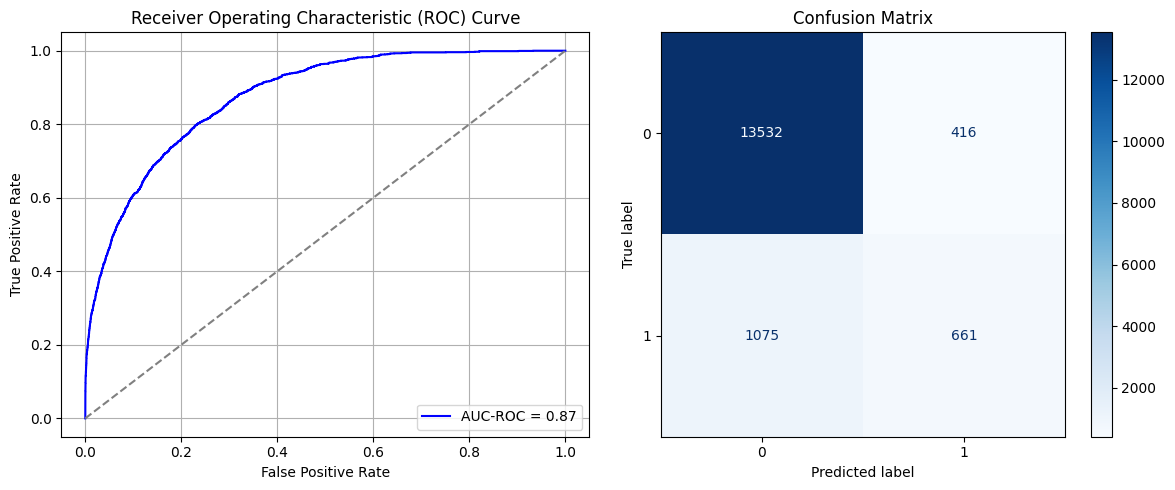

Best threshold based on F1-score: 0.3779400885105133
False Negative Rate: 0.6192396313364056
Time elapsed (performance): 1.711543913000014
(np.float64(0.029825064525379984), np.float64(0.97017493547462))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7207 - loss: 0.6184 - val_AUC: 0.8586 - val_loss: 0.4852
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8621 - loss: 0.4608 - val_AUC: 0.8704 - val_loss: 0.4554
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8711 - loss: 0.4450 - val_AUC: 0.8706 - val_loss: 0.4467
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8800 - loss: 0.4318 - val_AUC: 0.8723 - val_loss: 0.4427
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8789 - loss: 0.4304 - val_AUC: 0.8718 - val_loss: 0.4410
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8756 - loss: 0.4370 - val_AUC: 0.8717 - val_loss: 0.4586
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.8776 - loss: 0.4349 - val_AUC: 0.8718 - val_loss: 0.4460
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8837 - loss: 0.4218 - val_AUC: 0.8710 - val_loss: 0.4434
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8794 -

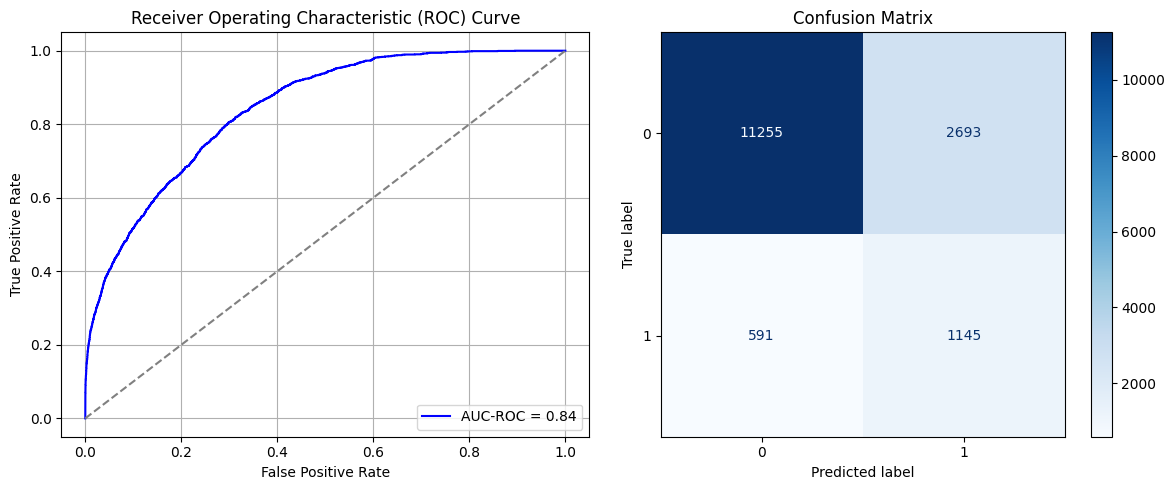

Best threshold based on F1-score: 0.6972577571868896
False Negative Rate: 0.34043778801843316
Time elapsed (performance): 1.3486450259999856
(np.float64(0.19307427588184686), np.float64(0.8069257241181531))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7328 - loss: 0.6231 - val_AUC: 0.8610 - val_loss: 0.4700
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8612 - loss: 0.4622 - val_AUC: 0.8744 - val_loss: 0.4397
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8688 - loss: 0.4469 - val_AUC: 0.8781 - val_loss: 0.4341
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8730 - loss: 0.4391 - val_AUC: 0.8799 - val_loss: 0.4301
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8708 - loss: 0.4444 - val_AUC: 0.8787 - val_loss: 0.4461
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8751 - loss: 0.4357 - val_AUC: 0.8806 - val_loss: 0.4314
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8792 - loss: 0.4311 - val_AUC: 0.8796 - val_loss: 0.4435
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8767 - loss: 0.4325 - val_AUC: 0.8799 - val_loss: 0.4390
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8779 -

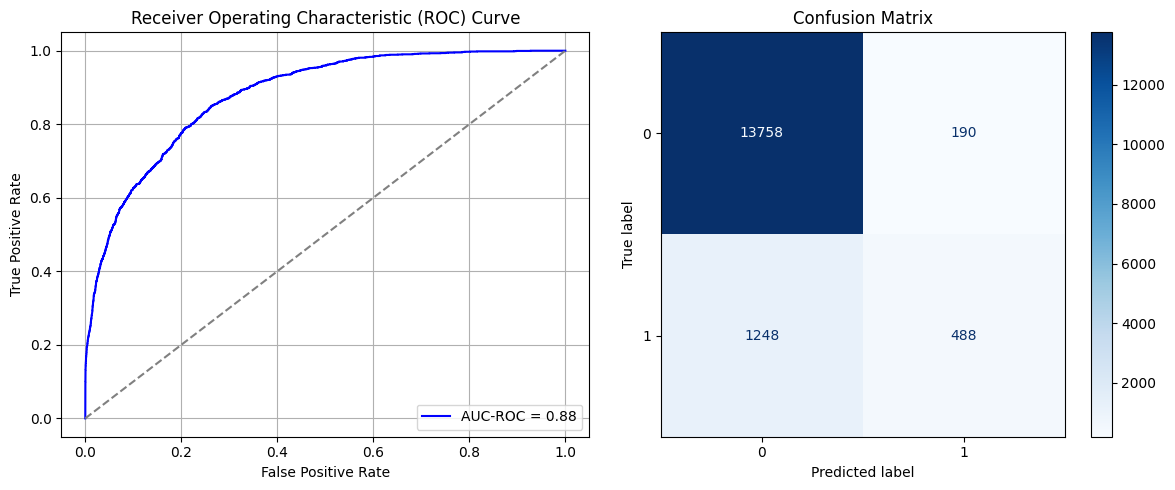

Best threshold based on F1-score: 0.2742277979850769
False Negative Rate: 0.7188940092165899
Time elapsed (performance): 1.343803165999816
(np.float64(0.013622024663034128), np.float64(0.9863779753369659))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7185 - loss: 0.6189 - val_AUC: 0.8640 - val_loss: 0.4805
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8523 - loss: 0.4738 - val_AUC: 0.8777 - val_loss: 0.4357
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8742 - loss: 0.4390 - val_AUC: 0.8779 - val_loss: 0.4502
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8728 - loss: 0.4397 - val_AUC: 0.8783 - val_loss: 0.4463
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8683 - loss: 0.4472 - val_AUC: 0.8790 - val_loss: 0.4307
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8761 - loss: 0.4347 - val_AUC: 0.8790 - val_loss: 0.4325
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8736 - loss: 0.4375 - val_AUC: 0.8792 - val_loss: 0.4327
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8725 - loss: 0.4410 - val_AUC: 0.8796 - val_loss: 0.4363
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8782 -

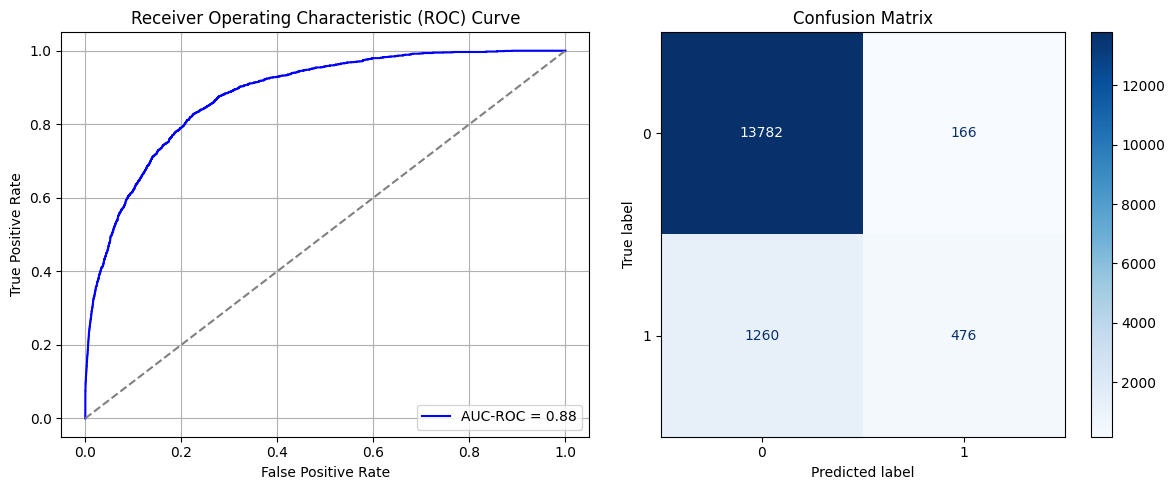

Best threshold based on F1-score: 0.20522494614124298
False Negative Rate: 0.7258064516129032
Time elapsed (performance): 1.399881606000008
(np.float64(0.011901347863492975), np.float64(0.988098652136507))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7172 - loss: 0.6195 - val_AUC: 0.8628 - val_loss: 0.4687
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8627 - loss: 0.4618 - val_AUC: 0.8764 - val_loss: 0.4473
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8707 - loss: 0.4444 - val_AUC: 0.8790 - val_loss: 0.4370
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8751 - loss: 0.4360 - val_AUC: 0.8794 - val_loss: 0.4323
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8765 - loss: 0.4324 - val_AUC: 0.8796 - val_loss: 0.4370
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8816 - loss: 0.4263 - val_AUC: 0.8795 - val_loss: 0.4300
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8715 - loss: 0.4419 - val_AUC: 0.8793 - val_loss: 0.4294
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8800 - loss: 0.4266 - val_AUC: 0.8787 - val_loss: 0.4415
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8732 -

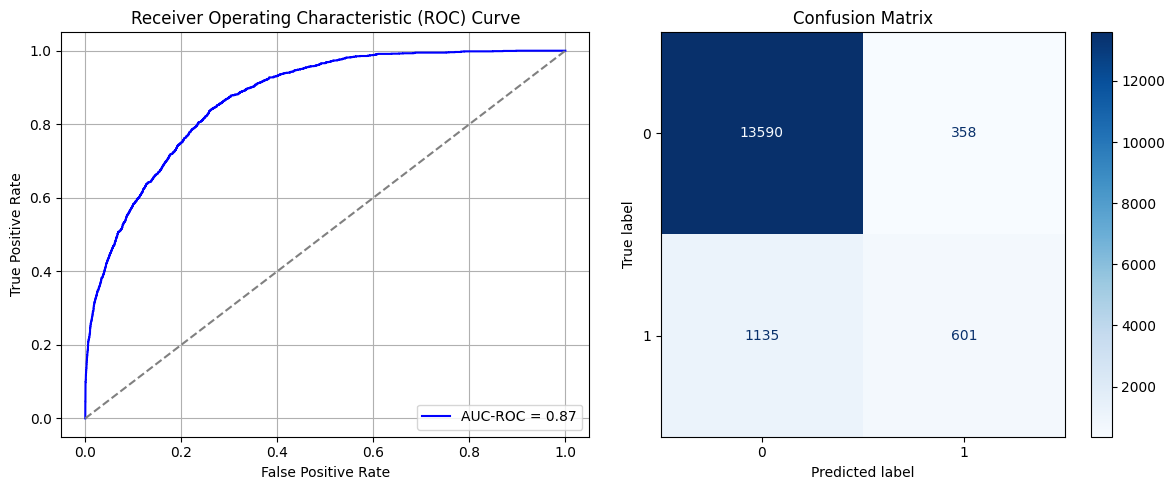

Best threshold based on F1-score: 0.37058767676353455
False Negative Rate: 0.6538018433179723
Time elapsed (performance): 1.392202220999934
(np.float64(0.025666762259822198), np.float64(0.9743332377401778))
   Source time       FPR       TNR       FNR       TPR  Target time
0    24.893438  0.026957  0.973043  0.649770  0.350230     1.705955
1    23.934124  0.042157  0.957843  0.640553  0.359447     1.712264
2    22.713106  0.001434  0.998566  0.848502  0.151498     1.274329
3    23.593169  0.004015  0.995985  0.845046  0.154954     1.279158
4    24.422346  0.001075  0.998925  0.883065  0.116935     2.574961
5    23.198550  0.029825  0.970175  0.619240  0.380760     1.711544
6    25.756878  0.193074  0.806926  0.340438  0.659562     1.348645
7    22.959928  0.013622  0.986378  0.718894  0.281106     1.343803
8    25.120401  0.011901  0.988099  0.725806  0.274194     1.399882
9    23.884903  0.025667  0.974333  0.653802  0.346198     1.392202


In [41]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)


In [42]:
print(ParamFit)
ParamFit.to_csv('Sy_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    24.893438  0.026957  0.973043  0.649770  0.350230     1.705955
1    23.934124  0.042157  0.957843  0.640553  0.359447     1.712264
2    22.713106  0.001434  0.998566  0.848502  0.151498     1.274329
3    23.593169  0.004015  0.995985  0.845046  0.154954     1.279158
4    24.422346  0.001075  0.998925  0.883065  0.116935     2.574961
5    23.198550  0.029825  0.970175  0.619240  0.380760     1.711544
6    25.756878  0.193074  0.806926  0.340438  0.659562     1.348645
7    22.959928  0.013622  0.986378  0.718894  0.281106     1.343803
8    25.120401  0.011901  0.988099  0.725806  0.274194     1.399882
9    23.884903  0.025667  0.974333  0.653802  0.346198     1.392202


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

22.5721570627231
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7420 - loss: 0.6073 - val_AUC: 0.8592 - val_loss: 0.4745
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8490 - loss: 0.4775 - val_AUC: 0.8779 - val_loss: 0.4416
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8698 - loss: 0.4443 - val_AUC: 0.8798 - val_loss: 0.4331
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8645 - loss: 0.4529 - val_AUC: 0.8806 - val_loss: 0.4322
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8675 - loss: 0.4476 - val_AUC: 0.8802 - val_loss: 0.4325
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8622 - loss: 0.4530 - val_AUC: 0.8804 - val_loss: 0.4312
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8710 - loss: 0.4425 - val_AUC: 0.8812 - val_loss: 0.4410
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8711 - loss: 0.4417 - val_AUC: 0.8828 - val_loss: 0.4300
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.8765 -

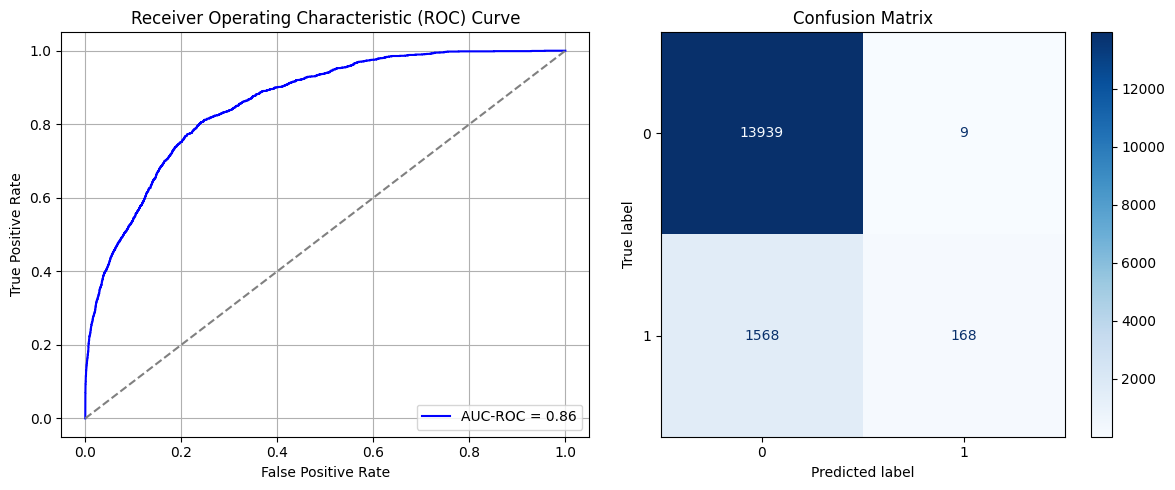

Best threshold based on F1-score: 0.0644705593585968
False Negative Rate: 0.9032258064516129
Time elapsed (performance): 1.7813063989999591
(np.float64(0.0006452537998279323), np.float64(0.9993547462001721))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7478 - loss: 0.6154 - val_AUC: 0.8594 - val_loss: 0.4811
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8588 - loss: 0.4643 - val_AUC: 0.8739 - val_loss: 0.4489
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8710 - loss: 0.4437 - val_AUC: 0.8770 - val_loss: 0.4391
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8745 - loss: 0.4371 - val_AUC: 0.8766 - val_loss: 0.4363
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8771 - loss: 0.4327 - val_AUC: 0.8774 - val_loss: 0.4380
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8737 - loss: 0.4381 - val_AUC: 0.8777 - val_loss: 0.4385
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8771 - loss: 0.4343 - val_AUC: 0.8788 - val_loss: 0.4354
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8762 - loss: 0.4341 - val_AUC: 0.8792 - val_loss: 0.4315
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8783 -

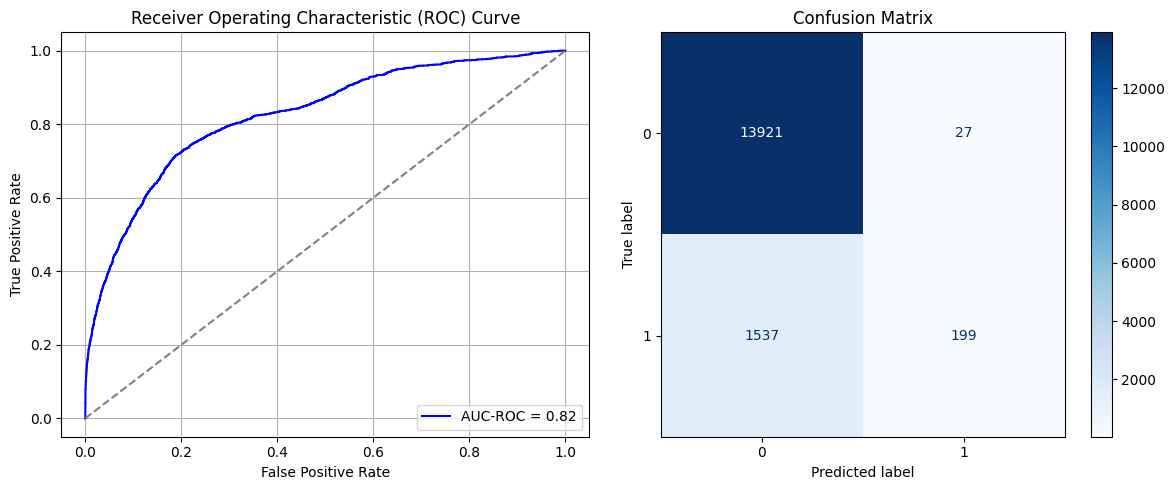

Best threshold based on F1-score: 0.0774705708026886
False Negative Rate: 0.8853686635944701
Time elapsed (performance): 1.7049688340000557
(np.float64(0.001935761399483797), np.float64(0.9980642386005162))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7272 - loss: 0.6267 - val_AUC: 0.8540 - val_loss: 0.4803
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8539 - loss: 0.4723 - val_AUC: 0.8759 - val_loss: 0.4397
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8663 - loss: 0.4512 - val_AUC: 0.8780 - val_loss: 0.4357
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8673 - loss: 0.4503 - val_AUC: 0.8778 - val_loss: 0.4427
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8705 - loss: 0.4448 - val_AUC: 0.8797 - val_loss: 0.4334
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8778 - loss: 0.4333 - val_AUC: 0.8802 - val_loss: 0.4293
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8755 - loss: 0.4386 - val_AUC: 0.8792 - val_loss: 0.4309
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8751 - loss: 0.4343 - val_AUC: 0.8796 - val_loss: 0.4330
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8749 -

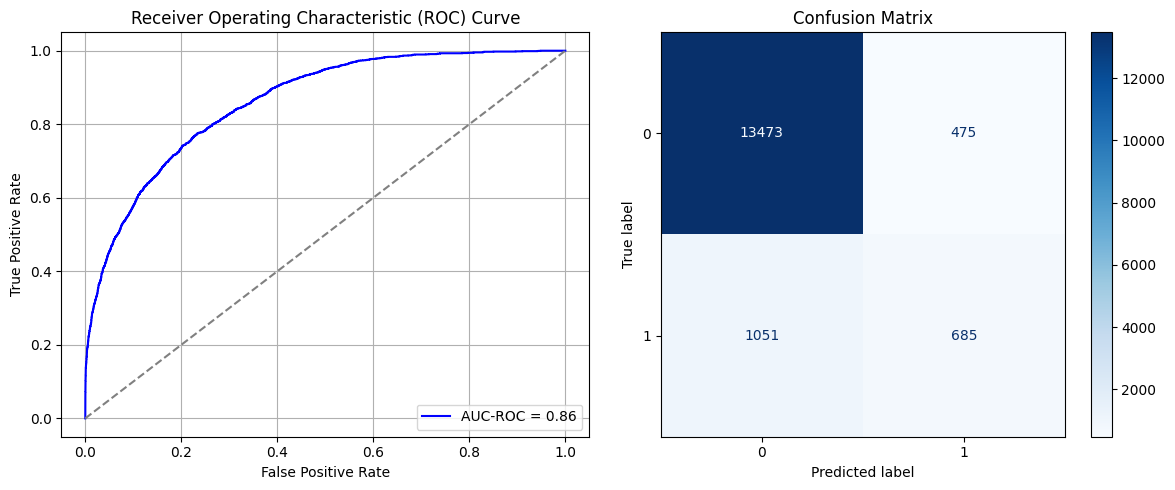

Best threshold based on F1-score: 0.404449462890625
False Negative Rate: 0.6054147465437788
Time elapsed (performance): 1.7093076510000174
(np.float64(0.03405506165758532), np.float64(0.9659449383424147))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7190 - loss: 0.6168 - val_AUC: 0.8660 - val_loss: 0.4922
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8602 - loss: 0.4626 - val_AUC: 0.8788 - val_loss: 0.4393
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8710 - loss: 0.4439 - val_AUC: 0.8802 - val_loss: 0.4335
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8738 - loss: 0.4376 - val_AUC: 0.8817 - val_loss: 0.4394
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8695 - loss: 0.4455 - val_AUC: 0.8803 - val_loss: 0.4323
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8767 - loss: 0.4347 - val_AUC: 0.8821 - val_loss: 0.4528
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4339 - val_AUC: 0.8821 - val_loss: 0.4297
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8769 - loss: 0.4324 - val_AUC: 0.8826 - val_loss: 0.4315
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8773 -

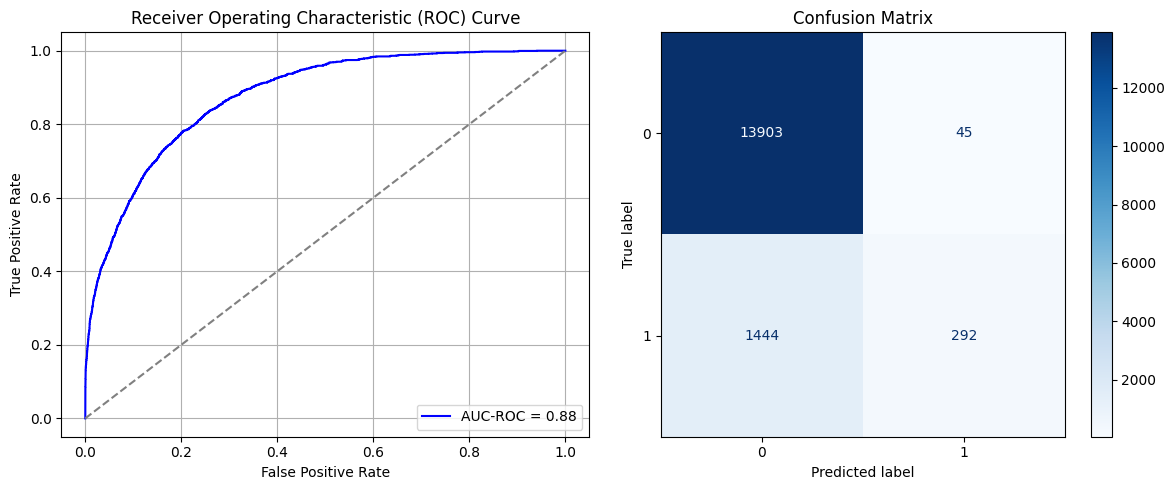

Best threshold based on F1-score: 0.10062018036842346
False Negative Rate: 0.8317972350230415
Time elapsed (performance): 1.7176396520001163
(np.float64(0.0032262689991396616), np.float64(0.9967737310008603))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7129 - loss: 0.6191 - val_AUC: 0.8577 - val_loss: 0.4768
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8569 - loss: 0.4665 - val_AUC: 0.8734 - val_loss: 0.4520
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8725 - loss: 0.4429 - val_AUC: 0.8741 - val_loss: 0.4449
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8790 - loss: 0.4305 - val_AUC: 0.8757 - val_loss: 0.4383
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8771 - loss: 0.4354 - val_AUC: 0.8769 - val_loss: 0.4503
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8798 - loss: 0.4287 - val_AUC: 0.8768 - val_loss: 0.4394
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4215 - val_AUC: 0.8771 - val_loss: 0.4366
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4240 - val_AUC: 0.8771 - val_loss: 0.4357
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8788 -

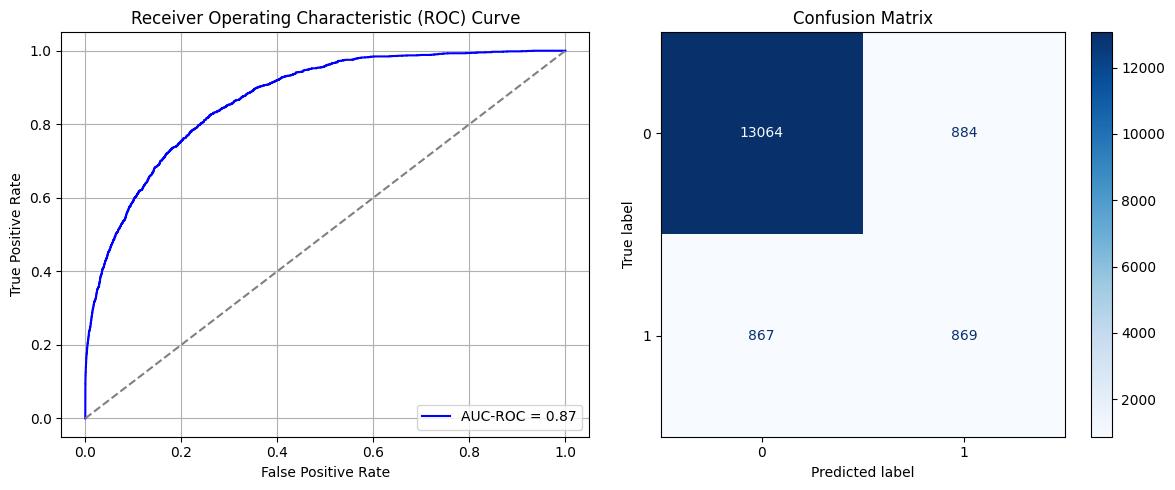

Best threshold based on F1-score: 0.4997496008872986
False Negative Rate: 0.49942396313364057
Time elapsed (performance): 1.7384466430000884
(np.float64(0.06337826211643247), np.float64(0.9366217378835675))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7050 - loss: 0.6243 - val_AUC: 0.8557 - val_loss: 0.4901
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8506 - loss: 0.4807 - val_AUC: 0.8773 - val_loss: 0.4414
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8676 - loss: 0.4502 - val_AUC: 0.8800 - val_loss: 0.4378
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8748 - loss: 0.4380 - val_AUC: 0.8807 - val_loss: 0.4357
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8728 - loss: 0.4410 - val_AUC: 0.8821 - val_loss: 0.4283
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8718 - loss: 0.4405 - val_AUC: 0.8823 - val_loss: 0.4264
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8713 - loss: 0.4417 - val_AUC: 0.8833 - val_loss: 0.4279
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8746 - loss: 0.4366 - val_AUC: 0.8841 - val_loss: 0.4229
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8733 -

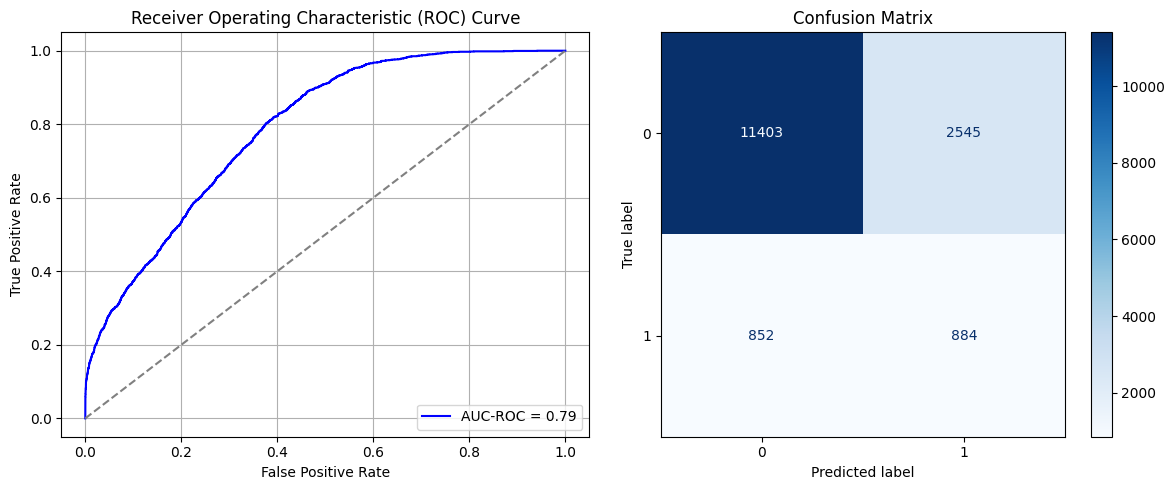

Best threshold based on F1-score: 0.4323946535587311
False Negative Rate: 0.49078341013824883
Time elapsed (performance): 1.6912030620001133
(np.float64(0.18246343561800976), np.float64(0.8175365643819903))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7373 - loss: 0.6194 - val_AUC: 0.8636 - val_loss: 0.4725
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8547 - loss: 0.4737 - val_AUC: 0.8770 - val_loss: 0.4365
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8624 - loss: 0.4562 - val_AUC: 0.8798 - val_loss: 0.4307
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8611 - loss: 0.4575 - val_AUC: 0.8809 - val_loss: 0.4356
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8711 - loss: 0.4444 - val_AUC: 0.8820 - val_loss: 0.4358
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8698 - loss: 0.4443 - val_AUC: 0.8826 - val_loss: 0.4278
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8654 - loss: 0.4485 - val_AUC: 0.8838 - val_loss: 0.4268
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8733 - loss: 0.4395 - val_AUC: 0.8836 - val_loss: 0.4267
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8722 -

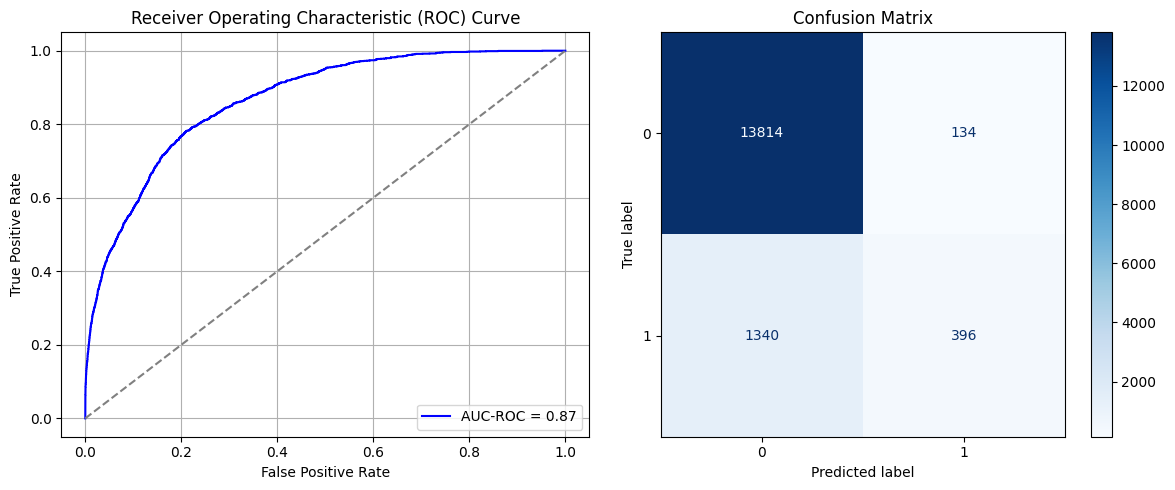

Best threshold based on F1-score: 0.13889646530151367
False Negative Rate: 0.771889400921659
Time elapsed (performance): 1.9254796489999535
(np.float64(0.009607112130771436), np.float64(0.9903928878692285))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7345 - loss: 0.6078 - val_AUC: 0.8638 - val_loss: 0.4856
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8624 - loss: 0.4608 - val_AUC: 0.8724 - val_loss: 0.4463
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8679 - loss: 0.4487 - val_AUC: 0.8747 - val_loss: 0.4626
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8719 - loss: 0.4404 - val_AUC: 0.8743 - val_loss: 0.4440
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8746 - loss: 0.4397 - val_AUC: 0.8754 - val_loss: 0.4397
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8754 - loss: 0.4350 - val_AUC: 0.8750 - val_loss: 0.4405
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8802 - loss: 0.4290 - val_AUC: 0.8757 - val_loss: 0.4513
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8781 - loss: 0.4339 - val_AUC: 0.8757 - val_loss: 0.4409
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8786 -

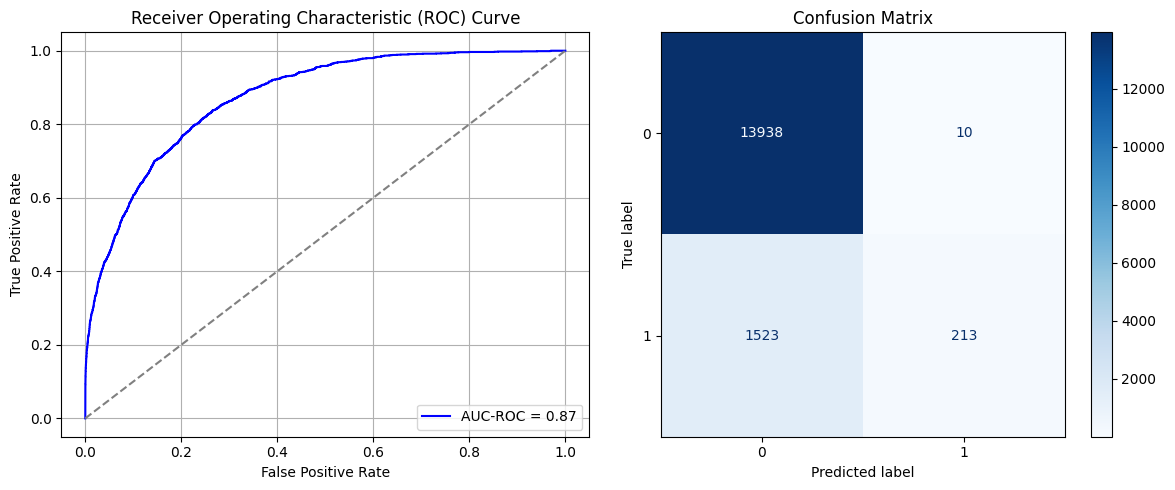

Best threshold based on F1-score: 0.03819632902741432
False Negative Rate: 0.8773041474654378
Time elapsed (performance): 1.7219834469999569
(np.float64(0.0007169486664754804), np.float64(0.9992830513335246))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.7435 - loss: 0.6118 - val_AUC: 0.8585 - val_loss: 0.4952
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8503 - loss: 0.4750 - val_AUC: 0.8727 - val_loss: 0.4451
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8614 - loss: 0.4579 - val_AUC: 0.8737 - val_loss: 0.4421
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8724 - loss: 0.4409 - val_AUC: 0.8746 - val_loss: 0.4384
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8774 - loss: 0.4312 - val_AUC: 0.8758 - val_loss: 0.4365
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8696 - loss: 0.4449 - val_AUC: 0.8748 - val_loss: 0.4446
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8753 - loss: 0.4363 - val_AUC: 0.8762 - val_loss: 0.4559
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8778 - loss: 0.4312 - val_AUC: 0.8763 - val_loss: 0.4564
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 -

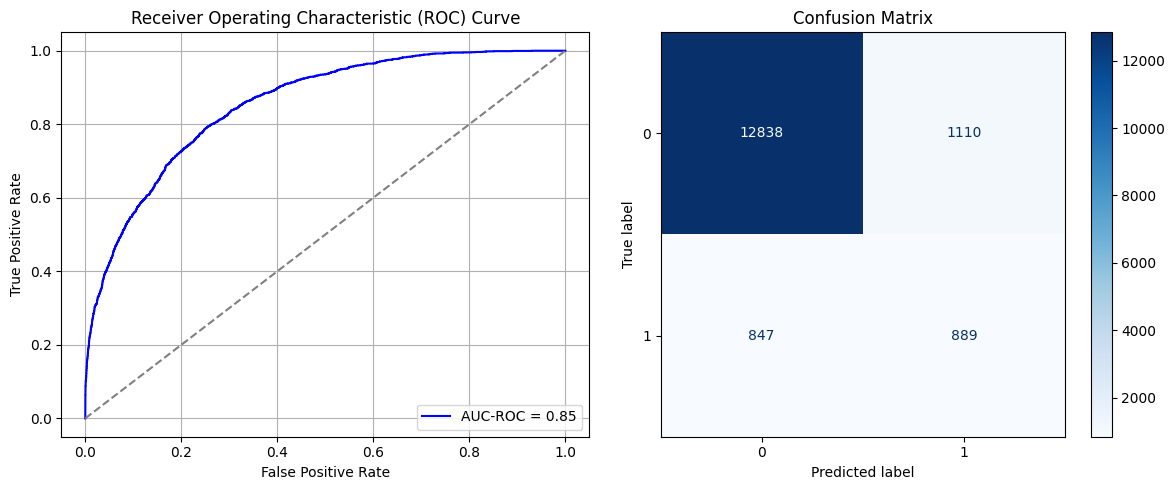

Best threshold based on F1-score: 0.4857352077960968
False Negative Rate: 0.4879032258064516
Time elapsed (performance): 1.7650064679999105
(np.float64(0.07958130197877832), np.float64(0.9204186980212217))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7267 - loss: 0.6112 - val_AUC: 0.8564 - val_loss: 0.4779
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8550 - loss: 0.4723 - val_AUC: 0.8774 - val_loss: 0.4373
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8702 - loss: 0.4436 - val_AUC: 0.8800 - val_loss: 0.4340
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8784 - loss: 0.4291 - val_AUC: 0.8805 - val_loss: 0.4324
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8766 - loss: 0.4327 - val_AUC: 0.8810 - val_loss: 0.4292
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8770 - loss: 0.4321 - val_AUC: 0.8812 - val_loss: 0.4643
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8727 - loss: 0.4400 - val_AUC: 0.8815 - val_loss: 0.4317
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8738 - loss: 0.4378 - val_AUC: 0.8821 - val_loss: 0.4282
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8740 -

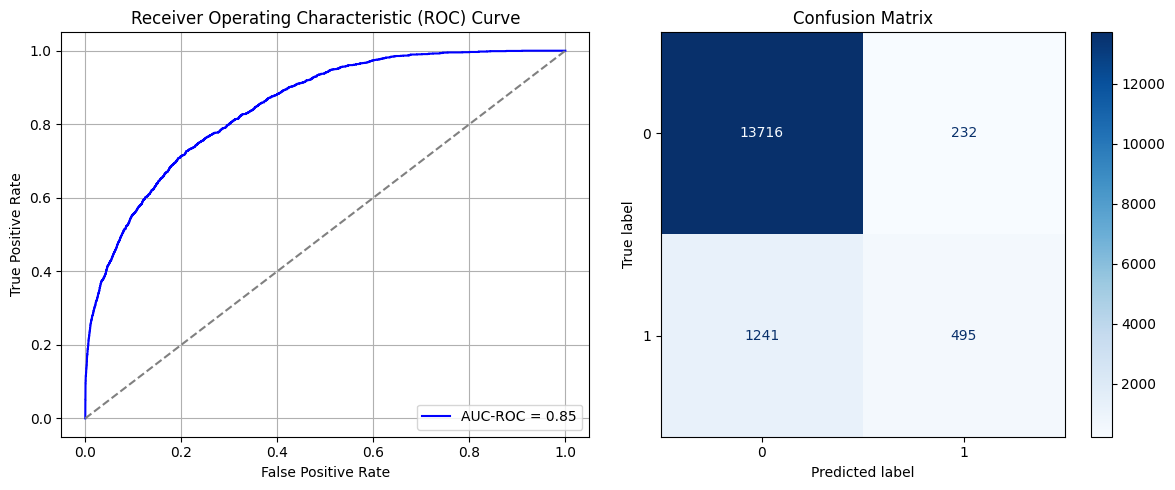

Best threshold based on F1-score: 0.2554883658885956
False Negative Rate: 0.7148617511520737
Time elapsed (performance): 1.7087005449998287
(np.float64(0.016633209062231143), np.float64(0.9833667909377689))
   Source time       FPR       TNR       FNR       TPR  Target time
0    30.221788  0.000645  0.999355  0.903226  0.096774     1.781306
1    25.218232  0.001936  0.998064  0.885369  0.114631     1.704969
2    27.982230  0.034055  0.965945  0.605415  0.394585     1.709308
3    25.096546  0.003226  0.996774  0.831797  0.168203     1.717640
4    23.173335  0.063378  0.936622  0.499424  0.500576     1.738447
5    21.560982  0.182463  0.817537  0.490783  0.509217     1.691203
6    26.747360  0.009607  0.990393  0.771889  0.228111     1.925480
7    24.645369  0.000717  0.999283  0.877304  0.122696     1.721983
8    26.721207  0.079581  0.920419  0.487903  0.512097     1.765006
9    22.213916  0.016633  0.983367  0.714862  0.285138     1.708701


In [43]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), 10)
    # print(start)

    Row = []

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)

In [44]:
print(ParamFit)
ParamFit.to_csv('Sy2_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    30.221788  0.000645  0.999355  0.903226  0.096774     1.781306
1    25.218232  0.001936  0.998064  0.885369  0.114631     1.704969
2    27.982230  0.034055  0.965945  0.605415  0.394585     1.709308
3    25.096546  0.003226  0.996774  0.831797  0.168203     1.717640
4    23.173335  0.063378  0.936622  0.499424  0.500576     1.738447
5    21.560982  0.182463  0.817537  0.490783  0.509217     1.691203
6    26.747360  0.009607  0.990393  0.771889  0.228111     1.925480
7    24.645369  0.000717  0.999283  0.877304  0.122696     1.721983
8    26.721207  0.079581  0.920419  0.487903  0.512097     1.765006
9    22.213916  0.016633  0.983367  0.714862  0.285138     1.708701


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [45]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

9805
22132


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7875 - loss: 0.5535 - val_AUC: 0.8750 - val_loss: 0.4391
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8745 - loss: 0.4394 - val_AUC: 0.8767 - val_loss: 0.4340
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8780 - loss: 0.4322 - val_AUC: 0.8793 - val_loss: 0.4323
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8751 - loss: 0.4349 - val_AUC: 0.8803 - val_loss: 0.4352
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8783 - loss: 0.4297 - val_AUC: 0.8808 - val_loss: 0.4280
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8808 - loss: 0.4267 - val_AUC: 0.8797 - val_loss: 0.4489
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8780 - loss: 0.4301 - val_AUC: 0.8816 - val_loss: 0.4292
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8813 - loss: 0.4246 - val_AUC: 0.8814 - val_loss: 0.4323
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8824 -

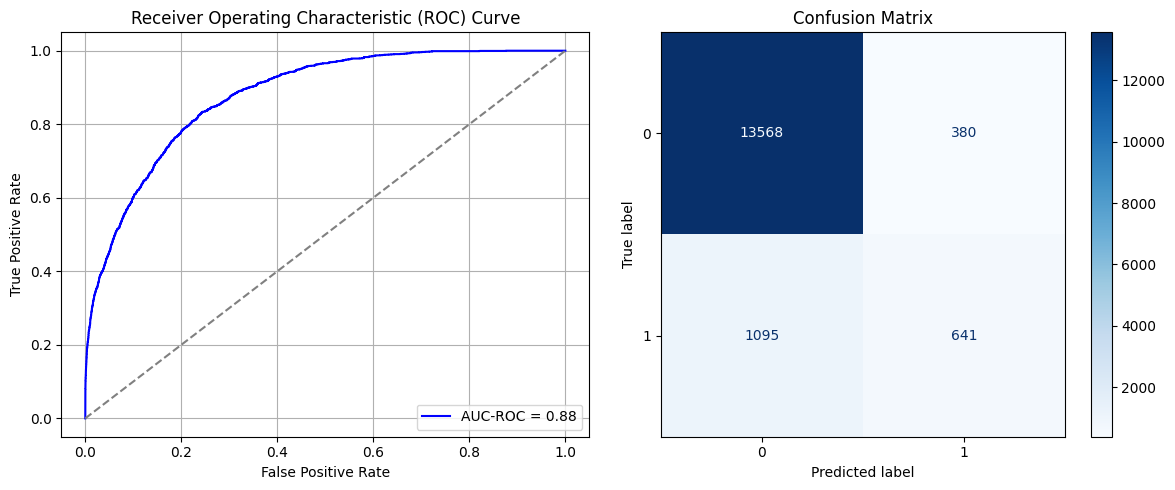

Best threshold based on F1-score: 0.3105584979057312
False Negative Rate: 0.6307603686635944
Time elapsed (performance): 1.2222956069999782
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7830 - loss: 0.5612 - val_AUC: 0.8721 - val_loss: 0.4573
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8713 - loss: 0.4423 - val_AUC: 0.8732 - val_loss: 0.4470
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8770 - loss: 0.4348 - val_AUC: 0.8768 - val_loss: 0.4344
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8746 - loss: 0.4363 - val_AUC: 0.8777 - val_loss: 0.4346
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8815 - loss: 0.4268 - val_AUC: 0.8785 - val_loss: 0.4314
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8798 - loss: 0.4289 - val_AUC: 0.8797 - val_loss: 0.4403
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8789 - loss: 0.4296 - val_AUC: 0.8802 - val_loss: 0.4279
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8807 - loss: 0.4267 - val_AUC: 0.8804 - val_loss: 0.4296
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8775 -

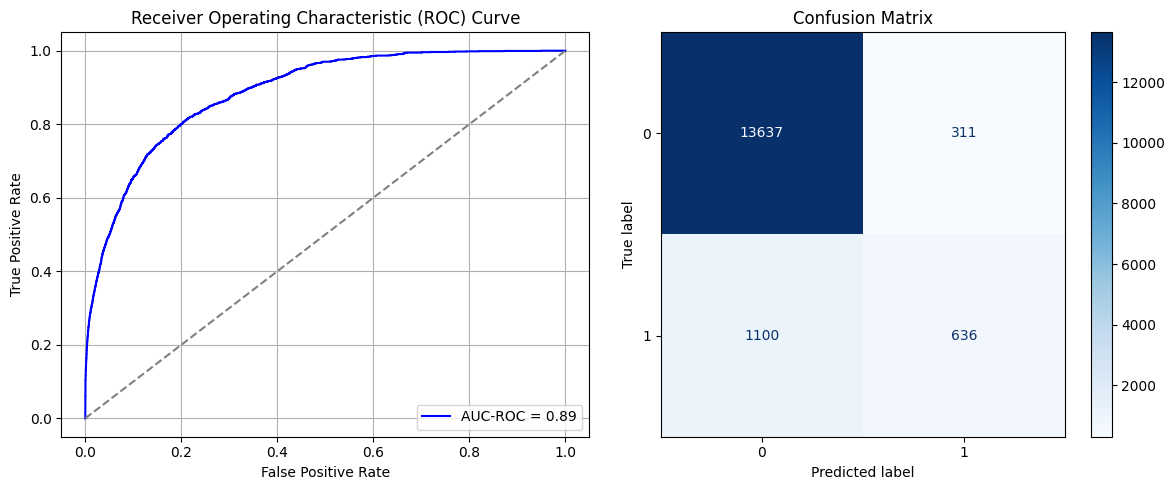

Best threshold based on F1-score: 0.32882097363471985
False Negative Rate: 0.6336405529953917
Time elapsed (performance): 1.7376060560000042
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7863 - loss: 0.5543 - val_AUC: 0.8686 - val_loss: 0.4471
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8693 - loss: 0.4452 - val_AUC: 0.8714 - val_loss: 0.4454
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8723 - loss: 0.4397 - val_AUC: 0.8713 - val_loss: 0.4453
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8786 - loss: 0.4292 - val_AUC: 0.8723 - val_loss: 0.4475
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8779 - loss: 0.4315 - val_AUC: 0.8722 - val_loss: 0.4421
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8772 - loss: 0.4312 - val_AUC: 0.8735 - val_loss: 0.4387
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8745 - loss: 0.4357 - val_AUC: 0.8748 - val_loss: 0.4363
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8746 - loss: 0.4342 - val_AUC: 0.8740 - val_loss: 0.4365
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8786 -

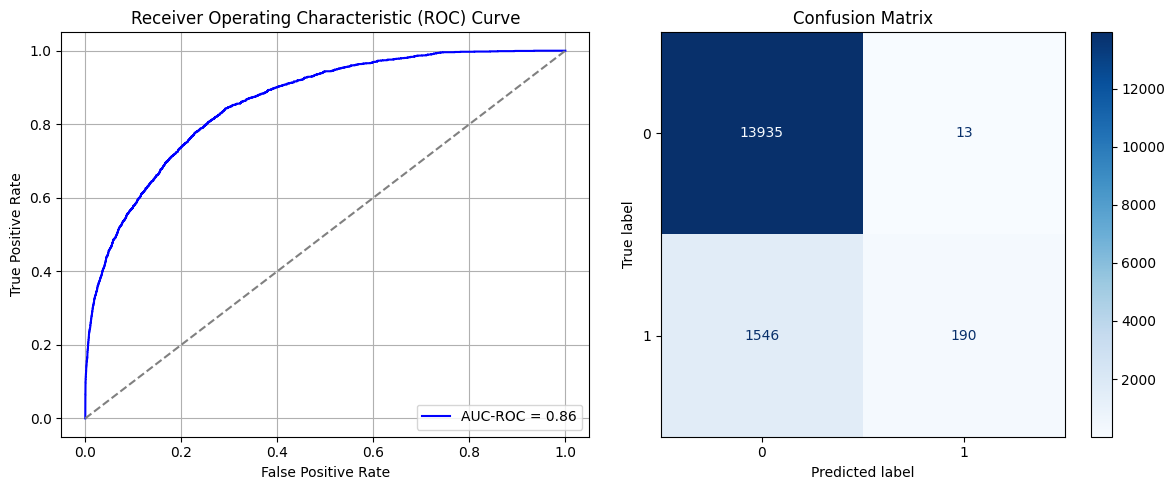

Best threshold based on F1-score: 0.04583362862467766
False Negative Rate: 0.8905529953917051
Time elapsed (performance): 1.2621869849999712
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7658 - loss: 0.5744 - val_AUC: 0.8700 - val_loss: 0.4450
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8692 - loss: 0.4460 - val_AUC: 0.8754 - val_loss: 0.4387
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8720 - loss: 0.4415 - val_AUC: 0.8766 - val_loss: 0.4399
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8713 - loss: 0.4414 - val_AUC: 0.8784 - val_loss: 0.4314
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8766 - loss: 0.4333 - val_AUC: 0.8793 - val_loss: 0.4402
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8754 - loss: 0.4352 - val_AUC: 0.8793 - val_loss: 0.4313
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8763 - loss: 0.4335 - val_AUC: 0.8792 - val_loss: 0.4279
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8769 - loss: 0.4316 - val_AUC: 0.8788 - val_loss: 0.4290
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8784 -

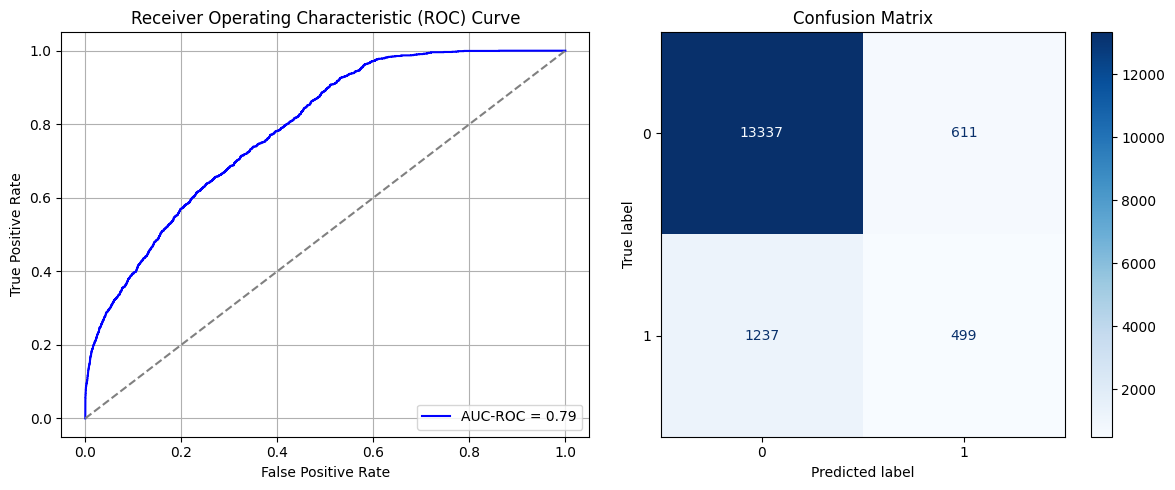

Best threshold based on F1-score: 0.19131694734096527
False Negative Rate: 0.7125576036866359
Time elapsed (performance): 1.9168741460000547
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7790 - loss: 0.5654 - val_AUC: 0.8710 - val_loss: 0.4415
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8757 - loss: 0.4356 - val_AUC: 0.8743 - val_loss: 0.4376
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8764 - loss: 0.4344 - val_AUC: 0.8754 - val_loss: 0.4352
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8760 - loss: 0.4351 - val_AUC: 0.8746 - val_loss: 0.4348
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8803 - loss: 0.4282 - val_AUC: 0.8763 - val_loss: 0.4389
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8777 - loss: 0.4320 - val_AUC: 0.8783 - val_loss: 0.4323
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8826 - loss: 0.4244 - val_AUC: 0.8779 - val_loss: 0.4289
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8805 - loss: 0.4265 - val_AUC: 0.8786 - val_loss: 0.4340
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8808 -

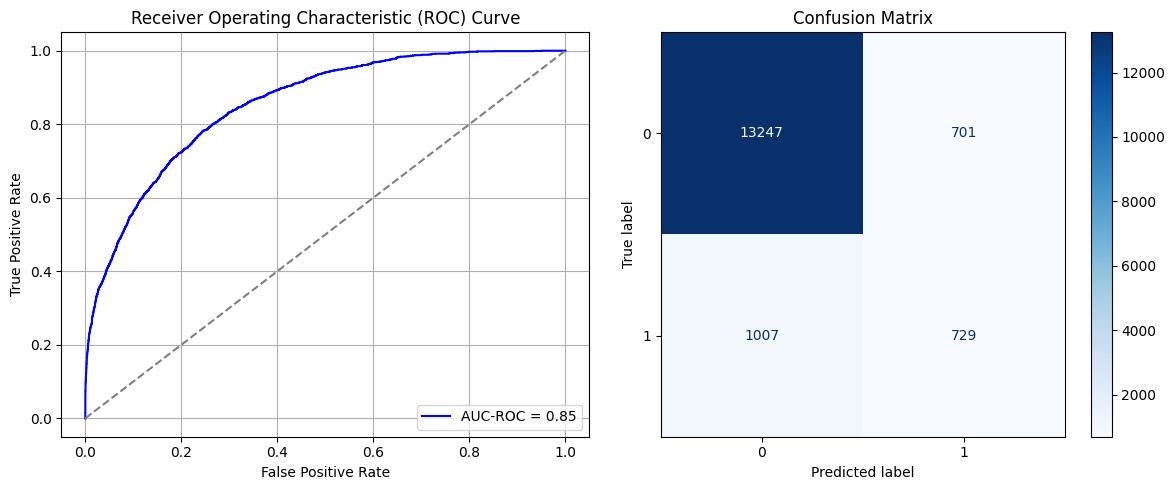

Best threshold based on F1-score: 0.3974507451057434
False Negative Rate: 0.5800691244239631
Time elapsed (performance): 1.719594448999942
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.7700 - loss: 0.5700 - val_AUC: 0.8711 - val_loss: 0.4463
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8715 - loss: 0.4433 - val_AUC: 0.8738 - val_loss: 0.4399
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8745 - loss: 0.4388 - val_AUC: 0.8746 - val_loss: 0.4410
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8770 - loss: 0.4328 - val_AUC: 0.8750 - val_loss: 0.4396
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8762 - loss: 0.4356 - val_AUC: 0.8762 - val_loss: 0.4538
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8751 - loss: 0.4363 - val_AUC: 0.8756 - val_loss: 0.4365
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8798 - loss: 0.4282 - val_AUC: 0.8771 - val_loss: 0.4338
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8784 - loss: 0.4308 - val_AUC: 0.8777 - val_loss: 0.4328
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8822 -

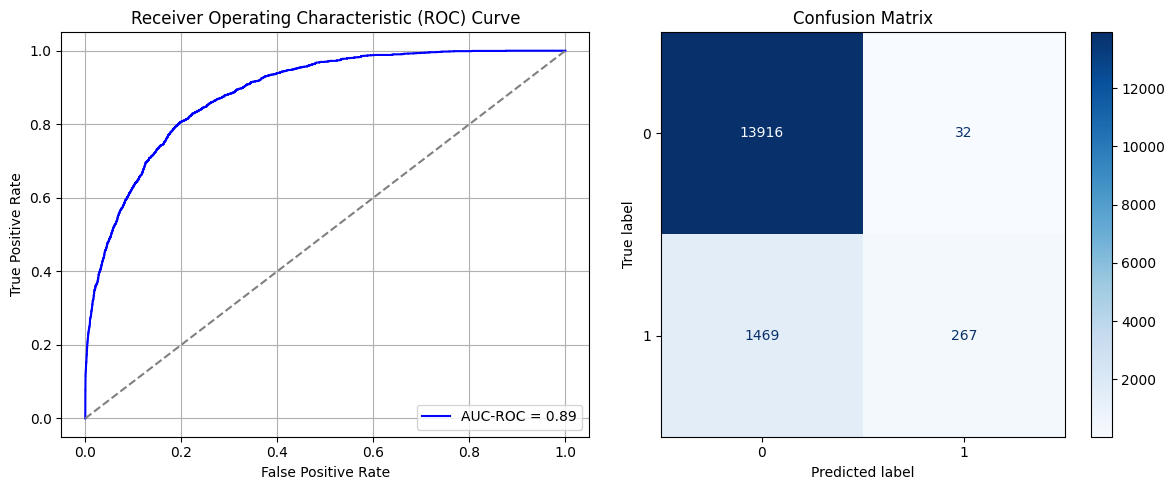

Best threshold based on F1-score: 0.10937805473804474
False Negative Rate: 0.8461981566820277
Time elapsed (performance): 1.3338850000000093
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7700 - loss: 0.5689 - val_AUC: 0.8729 - val_loss: 0.4551
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8694 - loss: 0.4452 - val_AUC: 0.8746 - val_loss: 0.4397
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8749 - loss: 0.4363 - val_AUC: 0.8760 - val_loss: 0.4421
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8758 - loss: 0.4345 - val_AUC: 0.8771 - val_loss: 0.4370
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8790 - loss: 0.4289 - val_AUC: 0.8781 - val_loss: 0.4314
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8780 - loss: 0.4304 - val_AUC: 0.8784 - val_loss: 0.4387
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8771 - loss: 0.4317 - val_AUC: 0.8783 - val_loss: 0.4302
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8792 - loss: 0.4281 - val_AUC: 0.8798 - val_loss: 0.4280
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8830 -

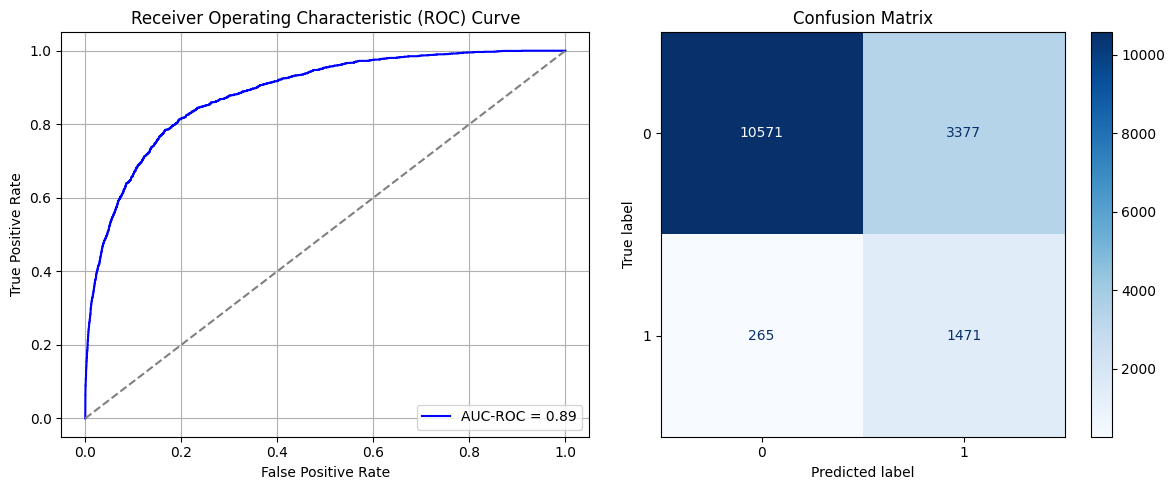

Best threshold based on F1-score: 0.7770625352859497
False Negative Rate: 0.15264976958525345
Time elapsed (performance): 3.0353956859999016
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7861 - loss: 0.5568 - val_AUC: 0.8727 - val_loss: 0.4427
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8740 - loss: 0.4376 - val_AUC: 0.8741 - val_loss: 0.4441
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8798 - loss: 0.4285 - val_AUC: 0.8756 - val_loss: 0.4533
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8713 - loss: 0.4413 - val_AUC: 0.8759 - val_loss: 0.4377
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8799 - loss: 0.4279 - val_AUC: 0.8772 - val_loss: 0.4332
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8816 - loss: 0.4260 - val_AUC: 0.8778 - val_loss: 0.4361
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8796 - loss: 0.4285 - val_AUC: 0.8781 - val_loss: 0.4489
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8811 - loss: 0.4255 - val_AUC: 0.8785 - val_loss: 0.4305
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8817 -

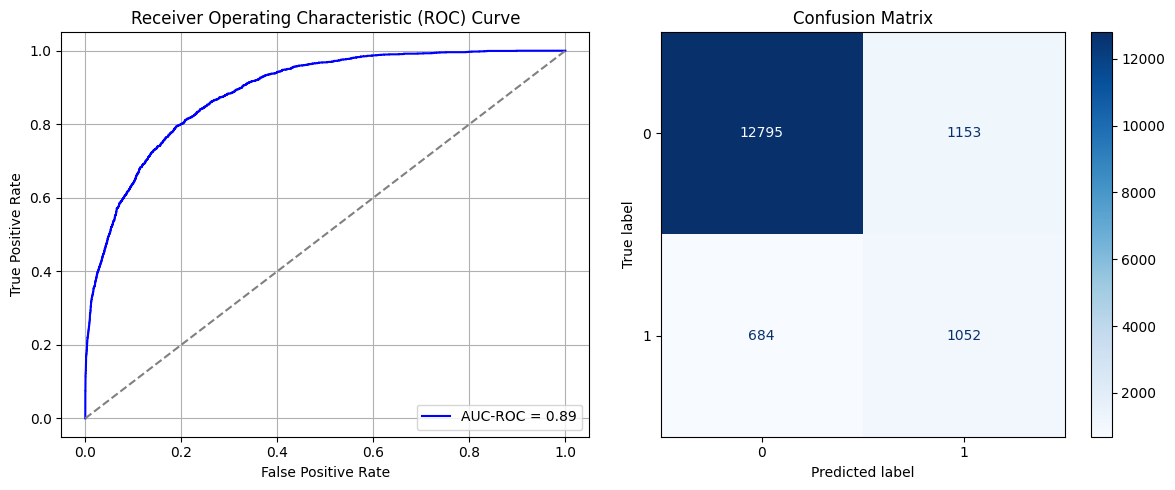

Best threshold based on F1-score: 0.5389895439147949
False Negative Rate: 0.39400921658986177
Time elapsed (performance): 1.7009610029999749
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7725 - loss: 0.5681 - val_AUC: 0.8753 - val_loss: 0.4430
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8719 - loss: 0.4423 - val_AUC: 0.8804 - val_loss: 0.4281
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8748 - loss: 0.4368 - val_AUC: 0.8805 - val_loss: 0.4276
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8721 - loss: 0.4409 - val_AUC: 0.8819 - val_loss: 0.4261
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8774 - loss: 0.4323 - val_AUC: 0.8821 - val_loss: 0.4242
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8791 - loss: 0.4300 - val_AUC: 0.8820 - val_loss: 0.4306
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8799 - loss: 0.4278 - val_AUC: 0.8829 - val_loss: 0.4256
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8808 - loss: 0.4268 - val_AUC: 0.8833 - val_loss: 0.4228
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8812 -

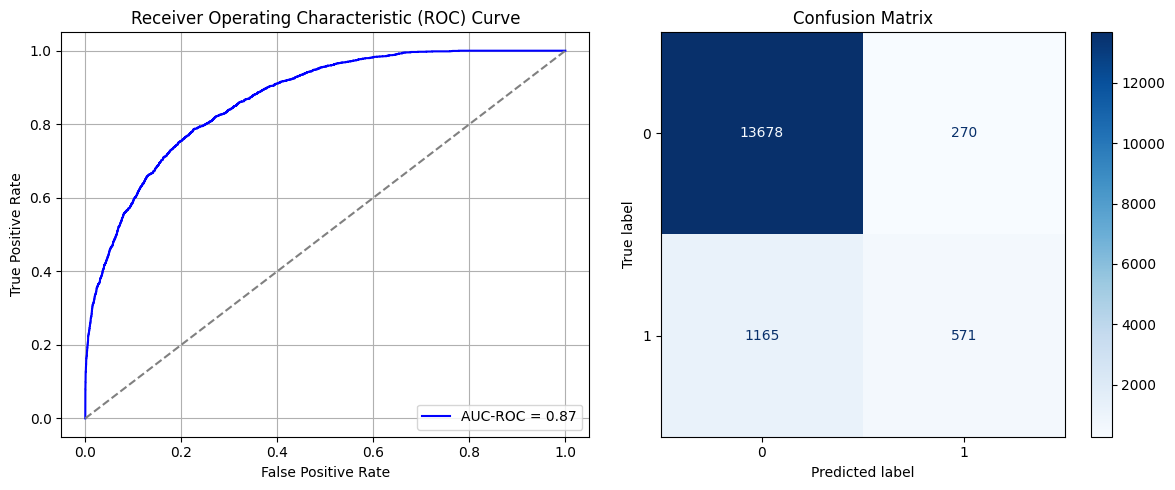

Best threshold based on F1-score: 0.2734714448451996
False Negative Rate: 0.6710829493087558
Time elapsed (performance): 3.0169110260003436
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7868 - loss: 0.5568 - val_AUC: 0.8719 - val_loss: 0.4486
Epoch 2/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8718 - loss: 0.4414 - val_AUC: 0.8734 - val_loss: 0.4426
Epoch 3/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8775 - loss: 0.4334 - val_AUC: 0.8753 - val_loss: 0.4437
Epoch 4/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8746 - loss: 0.4375 - val_AUC: 0.8754 - val_loss: 0.4405
Epoch 5/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8780 - loss: 0.4314 - val_AUC: 0.8769 - val_loss: 0.4344
Epoch 6/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8786 - loss: 0.4295 - val_AUC: 0.8767 - val_loss: 0.4367
Epoch 7/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8786 - loss: 0.4309 - val_AUC: 0.8753 - val_loss: 0.4366
Epoch 8/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8739 - loss: 0.4372 - val_AUC: 0.8776 - val_loss: 0.4333
Epoch 9/10
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8776 -

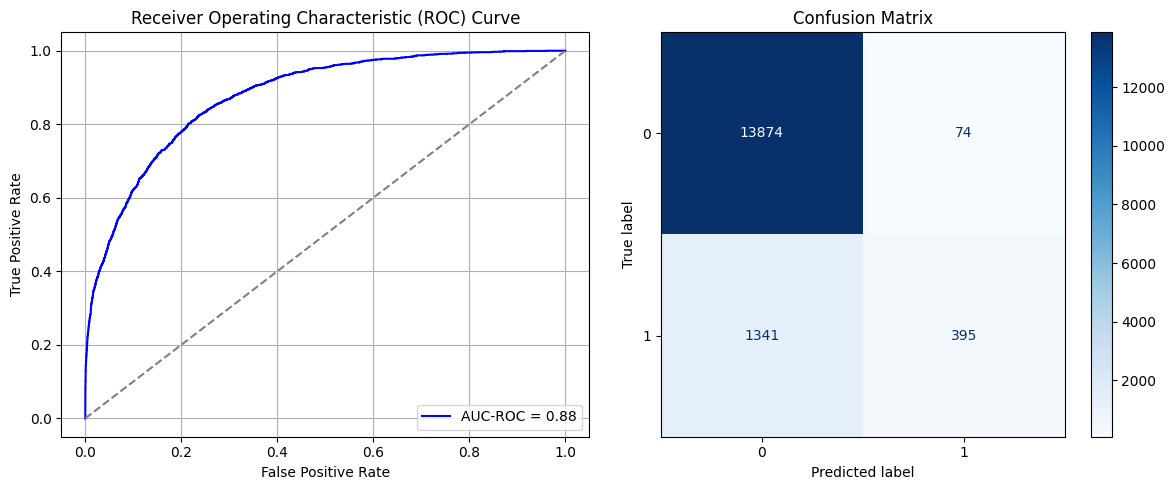

Best threshold based on F1-score: 0.11888095736503601
False Negative Rate: 0.7724654377880185
Time elapsed (performance): 1.2638417389998722


In [46]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_SRS_ROS = data_S_SRS_ROS.iloc[:, :-1]
    y_S_SRS_ROS = data_S_SRS_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS_ROS, y_S_SRS_ROS, test_size=0.20, random_state=0)
    model_SRS_ROS = create_dnn_model(X_S_train.shape[1])
    result_SRS_ROS = train_and_evaluate(model_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS_ROS = Transductive_TL(model_SRS_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS_ROS)
    FPR.append(result_TL_SRS_ROS[0])
    TNR.append(result_TL_SRS_ROS[1])
    FNR.append(result_TL_SRS_ROS[2])
    TPR.append(result_TL_SRS_ROS[3])
    TL_time.append(result_TL_SRS_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [47]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    46.092201  0.027244  0.972756  0.630760  0.369240     1.222296
1    40.974269  0.022297  0.977703  0.633641  0.366359     1.737606
2    46.747501  0.000932  0.999068  0.890553  0.109447     1.262187
3    48.013921  0.043806  0.956194  0.712558  0.287442     1.916874
4    46.120106  0.050258  0.949742  0.580069  0.419931     1.719594
5    49.345810  0.002294  0.997706  0.846198  0.153802     1.333885
6    47.735398  0.242114  0.757886  0.152650  0.847350     3.035396
7    47.729672  0.082664  0.917336  0.394009  0.605991     1.700961
8    46.510200  0.019358  0.980642  0.671083  0.328917     3.016911
9    51.203814  0.005305  0.994695  0.772465  0.227535     1.263842


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=10$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}= 11.05 \approx 11$, so we take $k=10$.

In [48]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

9805
22132


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7589 - loss: 0.5754 - val_AUC: 0.8709 - val_loss: 0.4470
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8730 - loss: 0.4405 - val_AUC: 0.8747 - val_loss: 0.4406
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8787 - loss: 0.4300 - val_AUC: 0.8759 - val_loss: 0.4405
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8753 - loss: 0.4355 - val_AUC: 0.8759 - val_loss: 0.4354
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8770 - loss: 0.4324 - val_AUC: 0.8761 - val_loss: 0.4404
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8784 - loss: 0.4305 - val_AUC: 0.8769 - val_loss: 0.4374
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8781 - loss: 0.4307 - val_AUC: 0.8767 - val_loss: 0.4339
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8830 - loss: 0.4224 - val_AUC: 0.8772 - val_loss: 0.4336
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8828 -

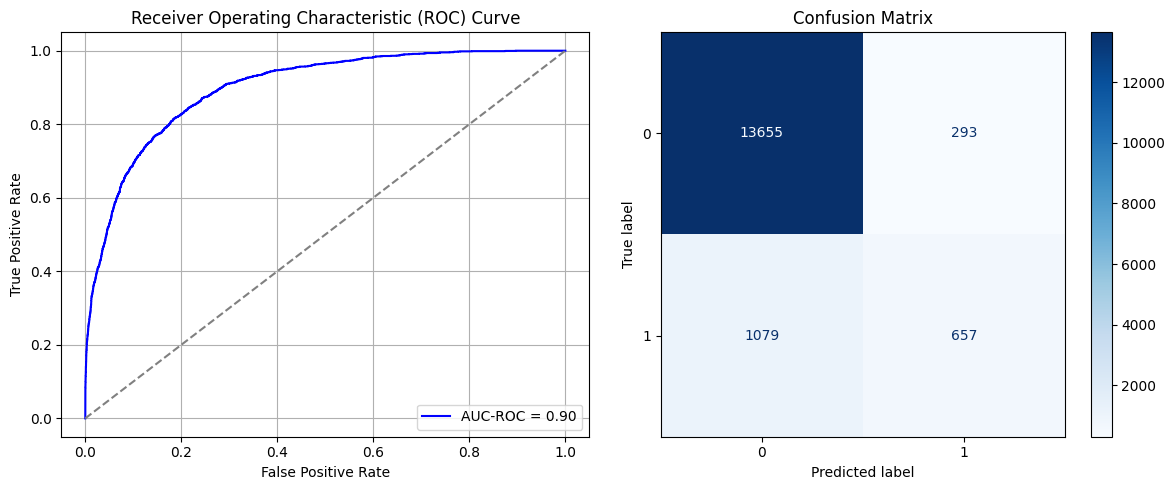

Best threshold based on F1-score: 0.2830769121646881
False Negative Rate: 0.6215437788018433
Time elapsed (performance): 1.257445030999861
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7836 - loss: 0.5628 - val_AUC: 0.8694 - val_loss: 0.4461
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8699 - loss: 0.4431 - val_AUC: 0.8729 - val_loss: 0.4395
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8738 - loss: 0.4385 - val_AUC: 0.8742 - val_loss: 0.4395
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8783 - loss: 0.4319 - val_AUC: 0.8746 - val_loss: 0.4384
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8782 - loss: 0.4317 - val_AUC: 0.8762 - val_loss: 0.4394
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8797 - loss: 0.4282 - val_AUC: 0.8765 - val_loss: 0.4348
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8774 - loss: 0.4323 - val_AUC: 0.8770 - val_loss: 0.4332
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8788 - loss: 0.4282 - val_AUC: 0.8780 - val_loss: 0.4309
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8795 -

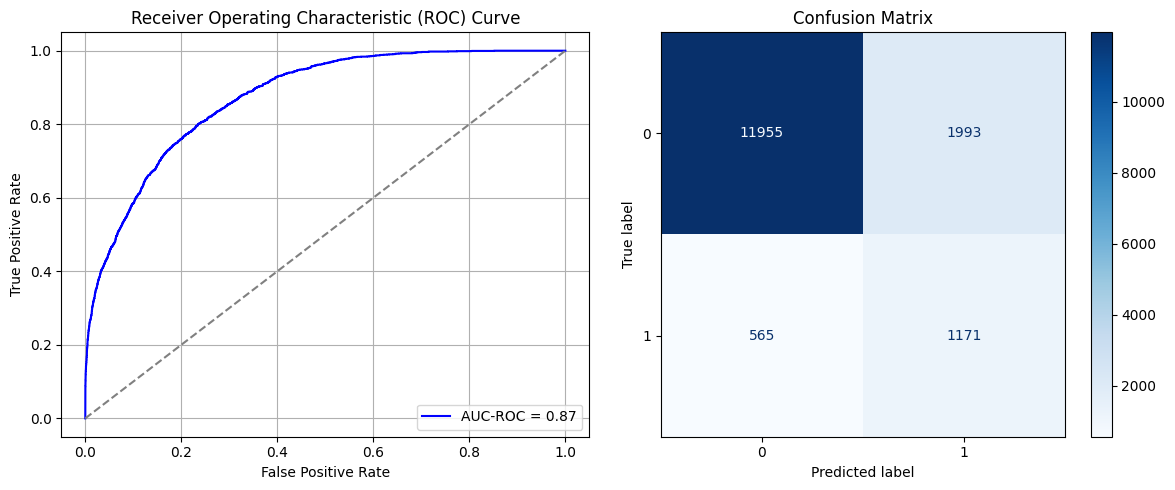

Best threshold based on F1-score: 0.6133044958114624
False Negative Rate: 0.3254608294930876
Time elapsed (performance): 1.2045331619997341
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7753 - loss: 0.5607 - val_AUC: 0.8720 - val_loss: 0.4497
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8716 - loss: 0.4432 - val_AUC: 0.8744 - val_loss: 0.4400
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8751 - loss: 0.4375 - val_AUC: 0.8749 - val_loss: 0.4435
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8789 - loss: 0.4307 - val_AUC: 0.8758 - val_loss: 0.4355
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8801 - loss: 0.4284 - val_AUC: 0.8752 - val_loss: 0.4415
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8757 - loss: 0.4345 - val_AUC: 0.8772 - val_loss: 0.4326
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8808 - loss: 0.4278 - val_AUC: 0.8777 - val_loss: 0.4330
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8807 - loss: 0.4274 - val_AUC: 0.8774 - val_loss: 0.4338
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8791 -

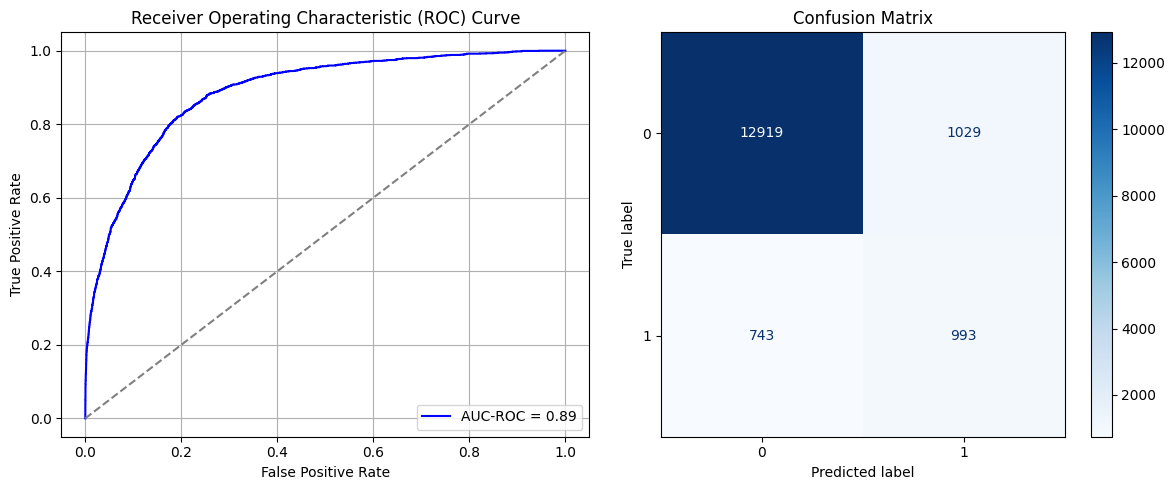

Best threshold based on F1-score: 0.5405446887016296
False Negative Rate: 0.4279953917050691
Time elapsed (performance): 1.3336450450001394
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7833 - loss: 0.5650 - val_AUC: 0.8704 - val_loss: 0.4440
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8766 - loss: 0.4342 - val_AUC: 0.8738 - val_loss: 0.4414
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8728 - loss: 0.4389 - val_AUC: 0.8741 - val_loss: 0.4386
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8807 - loss: 0.4271 - val_AUC: 0.8755 - val_loss: 0.4360
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8806 - loss: 0.4275 - val_AUC: 0.8754 - val_loss: 0.4441
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8795 - loss: 0.4273 - val_AUC: 0.8764 - val_loss: 0.4332
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8777 - loss: 0.4313 - val_AUC: 0.8765 - val_loss: 0.4341
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8796 - loss: 0.4282 - val_AUC: 0.8772 - val_loss: 0.4341
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8781 -

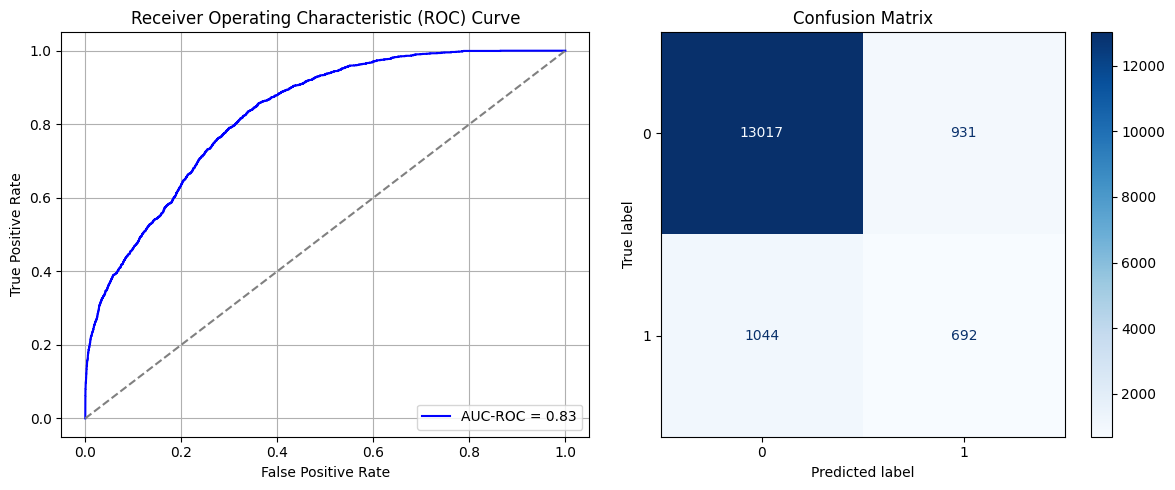

Best threshold based on F1-score: 0.522050142288208
False Negative Rate: 0.6013824884792627
Time elapsed (performance): 1.5418123710001055
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7904 - loss: 0.5551 - val_AUC: 0.8710 - val_loss: 0.4604
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8794 - loss: 0.4310 - val_AUC: 0.8733 - val_loss: 0.4407
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8760 - loss: 0.4345 - val_AUC: 0.8745 - val_loss: 0.4415
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8805 - loss: 0.4273 - val_AUC: 0.8734 - val_loss: 0.4432
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8801 - loss: 0.4277 - val_AUC: 0.8748 - val_loss: 0.4404
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8821 - loss: 0.4237 - val_AUC: 0.8755 - val_loss: 0.4394
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8821 - loss: 0.4253 - val_AUC: 0.8760 - val_loss: 0.4432
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8842 - loss: 0.4216 - val_AUC: 0.8752 - val_loss: 0.4363
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8809 -

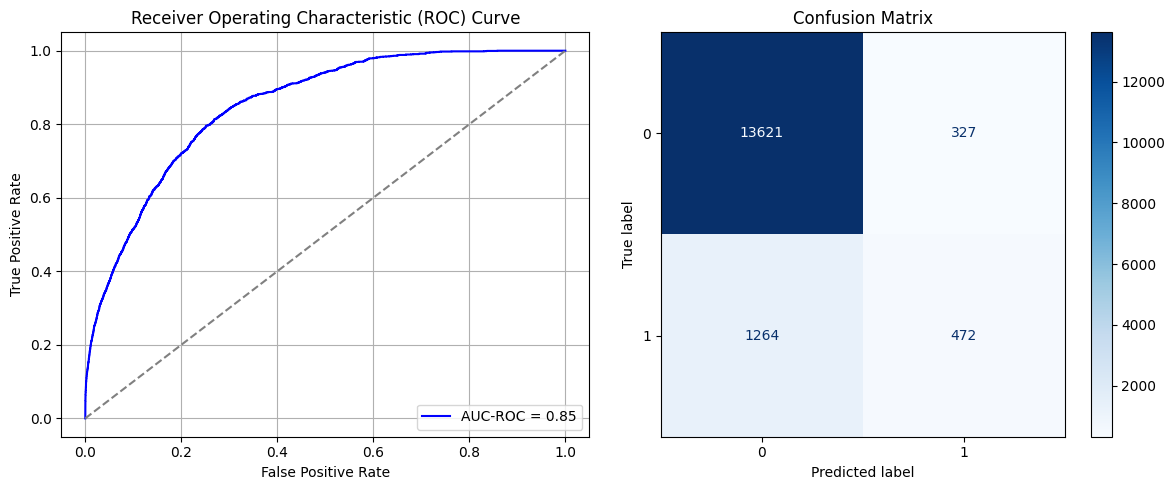

Best threshold based on F1-score: 0.17457859218120575
False Negative Rate: 0.728110599078341
Time elapsed (performance): 1.7142352519999804
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7824 - loss: 0.5623 - val_AUC: 0.8701 - val_loss: 0.4488
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8723 - loss: 0.4410 - val_AUC: 0.8732 - val_loss: 0.4414
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8731 - loss: 0.4396 - val_AUC: 0.8728 - val_loss: 0.4417
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8787 - loss: 0.4299 - val_AUC: 0.8755 - val_loss: 0.4352
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8767 - loss: 0.4331 - val_AUC: 0.8762 - val_loss: 0.4341
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8734 - loss: 0.4371 - val_AUC: 0.8755 - val_loss: 0.4357
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8769 - loss: 0.4332 - val_AUC: 0.8753 - val_loss: 0.4363
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8772 - loss: 0.4319 - val_AUC: 0.8774 - val_loss: 0.4315
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8811 -

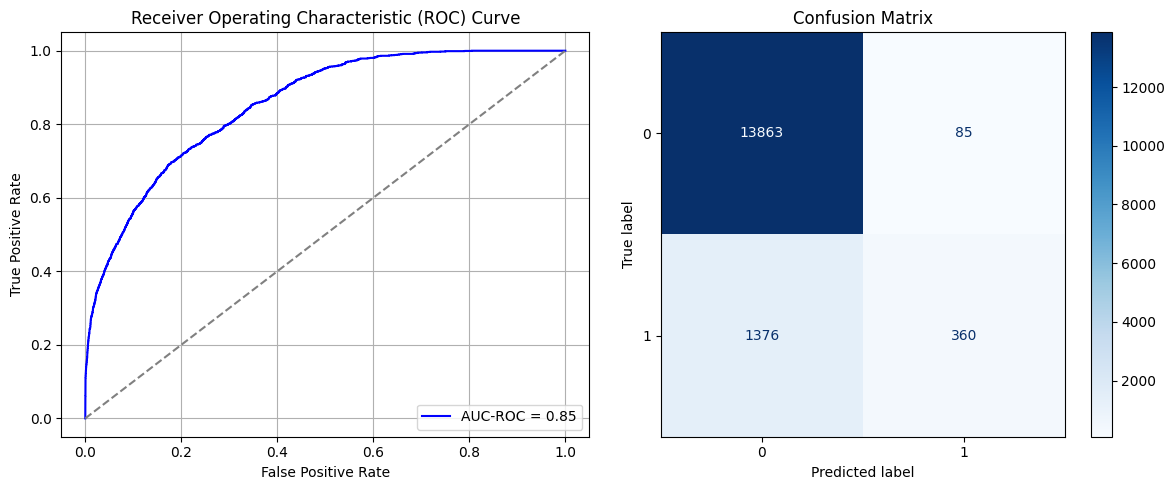

Best threshold based on F1-score: 0.1136605441570282
False Negative Rate: 0.7926267281105991
Time elapsed (performance): 1.706610334999823
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7725 - loss: 0.5652 - val_AUC: 0.8728 - val_loss: 0.4411
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8719 - loss: 0.4423 - val_AUC: 0.8751 - val_loss: 0.4373
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8786 - loss: 0.4310 - val_AUC: 0.8763 - val_loss: 0.4379
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8769 - loss: 0.4344 - val_AUC: 0.8772 - val_loss: 0.4326
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8796 - loss: 0.4287 - val_AUC: 0.8784 - val_loss: 0.4375
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8814 - loss: 0.4256 - val_AUC: 0.8778 - val_loss: 0.4347
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8800 - loss: 0.4276 - val_AUC: 0.8791 - val_loss: 0.4334
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8818 - loss: 0.4250 - val_AUC: 0.8791 - val_loss: 0.4387
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8842 -

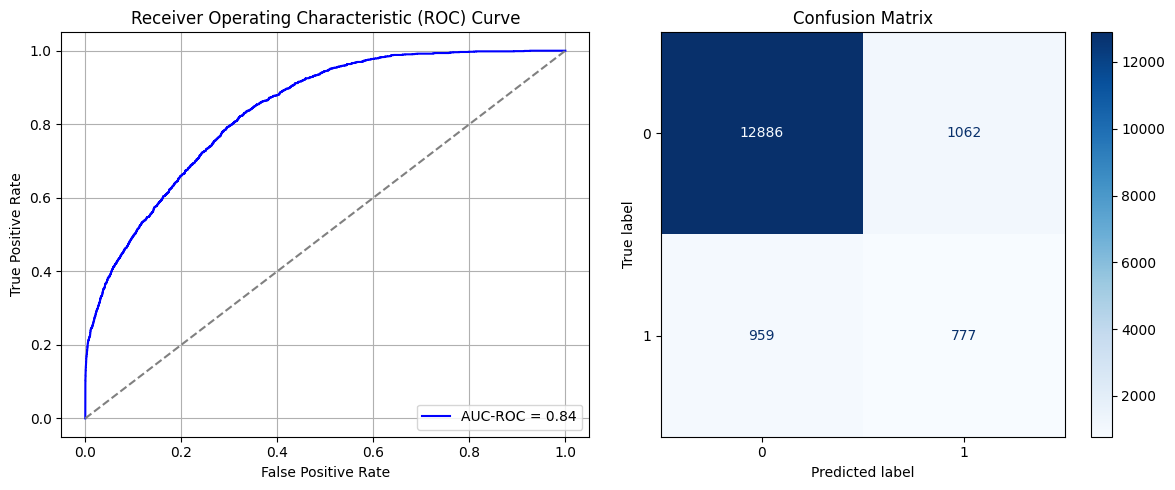

Best threshold based on F1-score: 0.5359179973602295
False Negative Rate: 0.5524193548387096
Time elapsed (performance): 1.9280583049999223
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7842 - loss: 0.5624 - val_AUC: 0.8711 - val_loss: 0.4464
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8722 - loss: 0.4428 - val_AUC: 0.8737 - val_loss: 0.4409
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8777 - loss: 0.4326 - val_AUC: 0.8766 - val_loss: 0.4351
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8795 - loss: 0.4299 - val_AUC: 0.8764 - val_loss: 0.4341
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8819 - loss: 0.4256 - val_AUC: 0.8780 - val_loss: 0.4416
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8784 - loss: 0.4316 - val_AUC: 0.8785 - val_loss: 0.4417
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8770 - loss: 0.4340 - val_AUC: 0.8789 - val_loss: 0.4395
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8815 - loss: 0.4257 - val_AUC: 0.8787 - val_loss: 0.4297
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8804 -

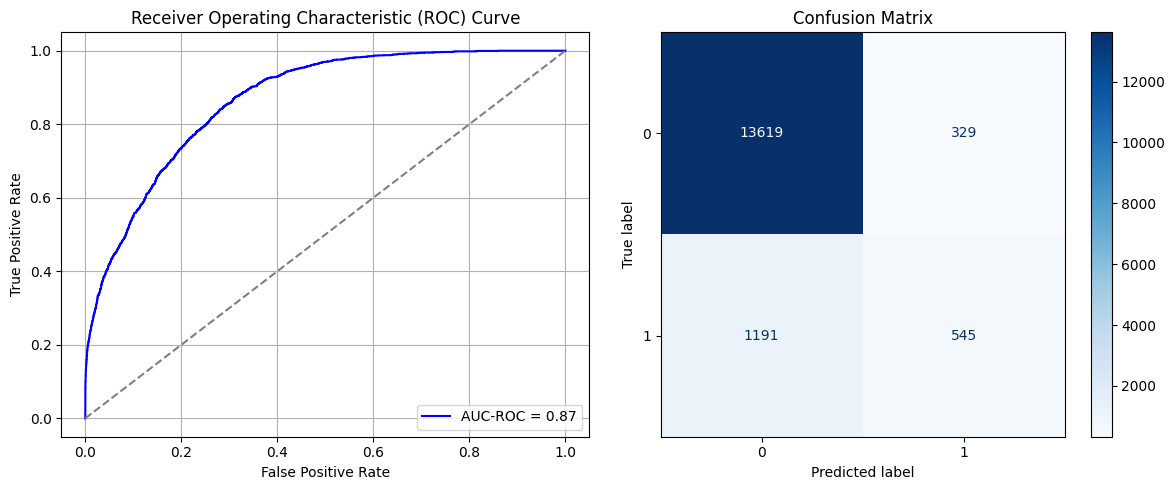

Best threshold based on F1-score: 0.2365211844444275
False Negative Rate: 0.6860599078341014
Time elapsed (performance): 1.7187610470000436
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7836 - loss: 0.5641 - val_AUC: 0.8703 - val_loss: 0.4446
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8777 - loss: 0.4324 - val_AUC: 0.8733 - val_loss: 0.4428
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8749 - loss: 0.4364 - val_AUC: 0.8754 - val_loss: 0.4375
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8746 - loss: 0.4370 - val_AUC: 0.8756 - val_loss: 0.4386
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8789 - loss: 0.4296 - val_AUC: 0.8766 - val_loss: 0.4367
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8786 - loss: 0.4302 - val_AUC: 0.8762 - val_loss: 0.4424
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8783 - loss: 0.4296 - val_AUC: 0.8773 - val_loss: 0.4327
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8815 - loss: 0.4251 - val_AUC: 0.8770 - val_loss: 0.4379
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8804 -

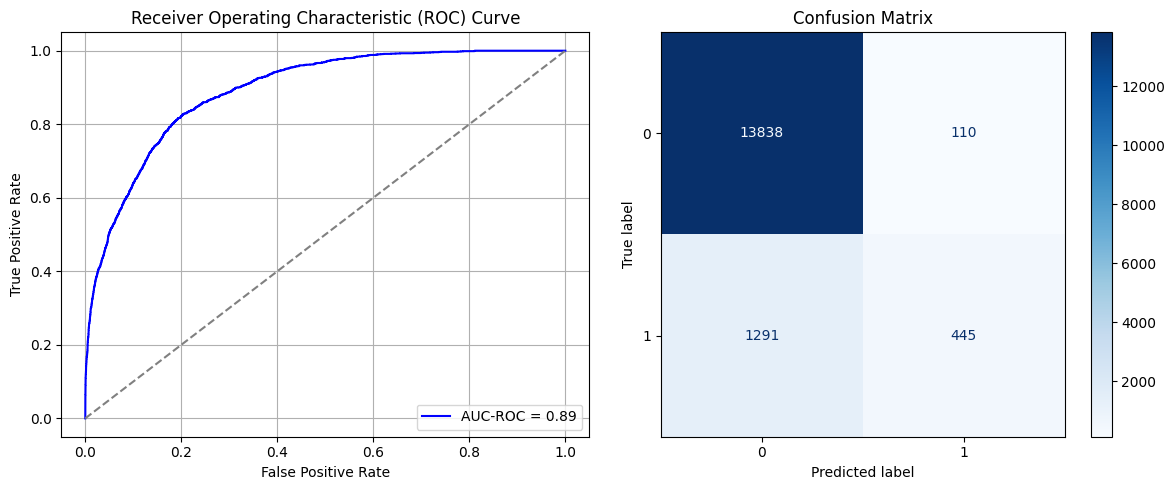

Best threshold based on F1-score: 0.2104119211435318
False Negative Rate: 0.743663594470046
Time elapsed (performance): 1.7098097879998022
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7766 - loss: 0.5676 - val_AUC: 0.8642 - val_loss: 0.4601
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8679 - loss: 0.4484 - val_AUC: 0.8695 - val_loss: 0.4459
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8746 - loss: 0.4377 - val_AUC: 0.8725 - val_loss: 0.4393
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8751 - loss: 0.4365 - val_AUC: 0.8731 - val_loss: 0.4383
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8798 - loss: 0.4294 - val_AUC: 0.8727 - val_loss: 0.4402
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8796 - loss: 0.4295 - val_AUC: 0.8738 - val_loss: 0.4371
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8784 - loss: 0.4313 - val_AUC: 0.8748 - val_loss: 0.4354
Epoch 8/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8777 - loss: 0.4316 - val_AUC: 0.8748 - val_loss: 0.4460
Epoch 9/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8805 -

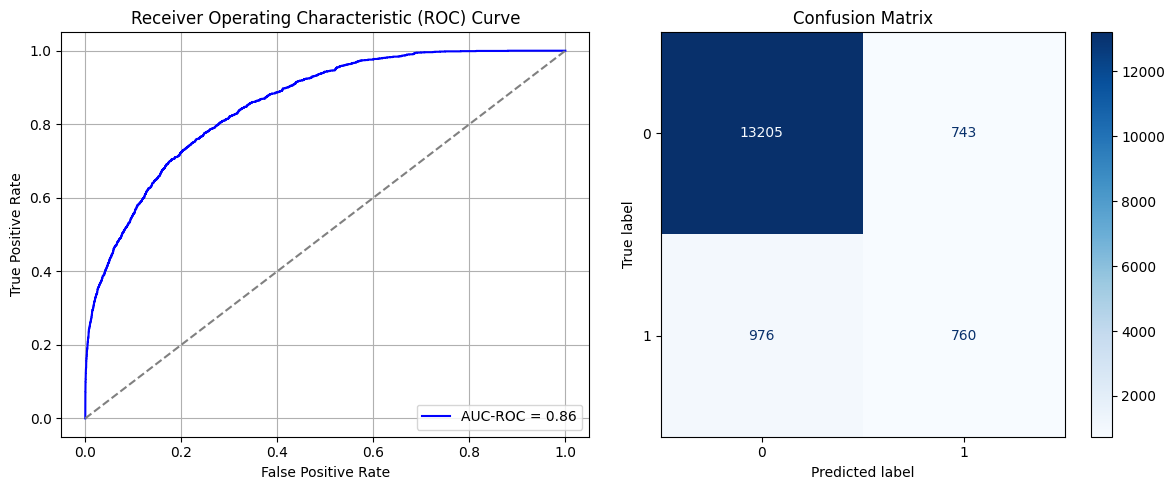

Best threshold based on F1-score: 0.4749445617198944
False Negative Rate: 0.5622119815668203
Time elapsed (performance): 1.5220981580000625


In [49]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = 10
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_S_min_ros = pd.DataFrame()
    data_S_min_ros = data_S_minority.iloc[Row]
    data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_Sy_ROS = data_S_Sy_ROS.iloc[:, :-1]
    y_S_Sy_ROS = data_S_Sy_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy_ROS, y_S_Sy_ROS, test_size=0.20, random_state=0)
    model_Sy_ROS = create_dnn_model(X_S_train.shape[1])
    result_Sy_ROS = train_and_evaluate(model_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy_ROS = Transductive_TL(model_Sy_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_Sy_ROS)
    FPR.append(result_TL_Sy_ROS[0])
    TNR.append(result_TL_Sy_ROS[1])
    FNR.append(result_TL_Sy_ROS[2])
    TPR.append(result_TL_Sy_ROS[3])
    TL_time.append(result_TL_Sy_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [50]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    46.156283  0.021007  0.978993  0.621544  0.378456     1.257445
1    47.715521  0.142888  0.857112  0.325461  0.674539     1.204533
2    45.085124  0.073774  0.926226  0.427995  0.572005     1.333645
3    45.654526  0.066748  0.933252  0.601382  0.398618     1.541812
4    46.690998  0.023444  0.976556  0.728111  0.271889     1.714235
5    44.498133  0.006094  0.993906  0.792627  0.207373     1.706610
6    52.085488  0.076140  0.923860  0.552419  0.447581     1.928058
7    46.465158  0.023588  0.976412  0.686060  0.313940     1.718761
8    43.036680  0.007886  0.992114  0.743664  0.256336     1.709810
9    53.932182  0.053269  0.946731  0.562212  0.437788     1.522098
